In [1]:
import sys
import os

# Get the root directory
root_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Add the root directory to the Python path
sys.path.append(root_dir)

In [2]:
from tqdm import tqdm
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import OneCycleLR
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from TINTOlib.igtd import IGTD
from kan import *
from tqdm import tqdm


import traceback
import time
import gc
import copy
import traceback
import torch.nn as nn
import cv2
import math
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
#from torch.optim import LBFGS


if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")

print(device)

cuda


In [3]:
SEED = 381
# SET RANDOM SEED FOR REPRODUCIBILITY
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

# Best 0.212

In [4]:
folder="data/treasury"
x_col=["1Y-CMaturityRate", "30Y-CMortgageRate", "3M-Rate-AuctionAverage", "3M-Rate-SecondaryMarket", "3Y-CMaturityRate", 
       "5Y-CMaturityRate", "bankCredit", "currency", "demandDeposits", "federalFunds", "moneyStock", "checkableDeposits", 
       "loansLeases", "savingsDeposits", "tradeCurrencies"]

target_col=["target"]

# Functions

### Load Dataset and Images

In [5]:
def load_and_clean(npy_filename, y_filename, x_col, target_col):
    """
    Load the feature array (npy_filename) and label array (y_filename),
    drop rows in the feature array that contain any NaNs, and apply
    the same mask to the label array.
    """
    # Load numpy arrays
    X = np.load(os.path.join(folder, npy_filename))
    y = np.load(os.path.join(folder, y_filename))
    
    # Ensure the number of rows matches between X and y
    if X.shape[0] != y.shape[0]:
        raise ValueError("The number of rows in {} and {} do not match.".format(npy_filename, y_filename))
    
    # Create a boolean mask for rows that do NOT have any NaN values in X
    valid_rows = ~np.isnan(X).any(axis=1)
    #print(valid_rows)
    # Filter both arrays using the valid_rows mask
    X_clean = X[valid_rows]
    y_clean = y[valid_rows]
    
    # Convert arrays to DataFrames
    df_X = pd.DataFrame(X_clean)
    df_y = pd.DataFrame(y_clean)
    df_X.columns = x_col
    df_y.columns = target_col

    return df_X, df_y

In [6]:
def load_and_preprocess_data(X_train, y_train, X_test, y_test, X_val, y_val, image_model, problem_type, batch_size=32):
    # Add target column to input for IGTD
    X_train_full = X_train.copy()
    X_train_full["target"] = y_train.values

    X_val_full = X_val.copy()
    X_val_full["target"] = y_val.values

    X_test_full = X_test.copy()
    X_test_full["target"] = y_test.values

    # Generate the images if the folder does not exist
    if not os.path.exists(f'{images_folder}/train'):
        image_model.fit_transform(X_train_full, f'{images_folder}/train')
        image_model.saveHyperparameters(f'{images_folder}/model.pkl')
    else:
        print("The images are already generated")

    # Load image paths
    imgs_train = pd.read_csv(os.path.join(f'{images_folder}/train', f'{problem_type}.csv'))
    imgs_train["images"] = images_folder + "/train/" + imgs_train["images"]

    if not os.path.exists(f'{images_folder}/val'):
        image_model.transform(X_val_full, f'{images_folder}/val')
    else:
        print("The images are already generated")

    imgs_val = pd.read_csv(os.path.join(f'{images_folder}/val', f'{problem_type}.csv'))
    imgs_val["images"] = images_folder + "/val/" + imgs_val["images"]

    if not os.path.exists(f'{images_folder}/test'):
        image_model.transform(X_test_full, f'{images_folder}/test')
    else:
        print("The images are already generated")

    imgs_test = pd.read_csv(os.path.join(f'{images_folder}/test', f'{problem_type}.csv'))
    imgs_test["images"] = images_folder + "/test/" + imgs_test["images"]

    # Image data
    X_train_img = np.array([cv2.imread(img) for img in imgs_train["images"]])
    X_val_img = np.array([cv2.imread(img) for img in imgs_val["images"]])
    X_test_img = np.array([cv2.imread(img) for img in imgs_test["images"]])

    # Create a MinMaxScaler object
    scaler = MinMaxScaler()

    # Scale numerical data
    X_train_num = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
    X_val_num = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns)
    X_test_num = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

    attributes = len(X_train_num.columns)
    height, width, channels = X_train_img[0].shape
    imgs_shape = (channels, height, width)

    print("Images shape: ", imgs_shape)
    print("Attributes: ", attributes)

    # Convert data to PyTorch tensors
    X_train_num_tensor = torch.as_tensor(X_train_num.values, dtype=torch.float32)
    X_val_num_tensor = torch.as_tensor(X_val_num.values, dtype=torch.float32)
    X_test_num_tensor = torch.as_tensor(X_test_num.values, dtype=torch.float32)
    X_train_img_tensor = torch.as_tensor(X_train_img, dtype=torch.float32).permute(0, 3, 1, 2) / 255.0
    X_val_img_tensor = torch.as_tensor(X_val_img, dtype=torch.float32).permute(0, 3, 1, 2) / 255.0
    X_test_img_tensor = torch.as_tensor(X_test_img, dtype=torch.float32).permute(0, 3, 1, 2) / 255.0
    y_train_tensor = torch.as_tensor(y_train.values, dtype=torch.float32).reshape(-1, 1)
    y_val_tensor = torch.as_tensor(y_val.values, dtype=torch.float32).reshape(-1, 1)
    y_test_tensor = torch.as_tensor(y_test.values, dtype=torch.float32).reshape(-1, 1)

    # Create DataLoaders
    train_dataset = TensorDataset(X_train_num_tensor, X_train_img_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_num_tensor, X_val_img_tensor, y_val_tensor)
    test_dataset = TensorDataset(X_test_num_tensor, X_test_img_tensor, y_test_tensor)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

    return train_loader, val_loader, test_loader, attributes, imgs_shape

In [7]:
def combine_loader(loader):
    """
    Combines all batches from a DataLoader into three tensors.
    Assumes each batch is a tuple: (mlp_tensor, img_tensor, target_tensor)
    """
    mlp_list, img_list, target_list = [], [], []
    for mlp, img, target in loader:
        mlp_list.append(mlp)
        img_list.append(img)
        target_list.append(target)
    return torch.cat(mlp_list, dim=0), torch.cat(img_list, dim=0), torch.cat(target_list, dim=0)

### Functions for KAN

In [8]:
def average_rmse(output, val_target):
    """
    Computes the root mean squared error (RMSE) between output and val_target.

    Args:
        output (torch.Tensor): The predicted output tensor.
        val_target (torch.Tensor): The ground truth tensor.
    
    Returns:
        float: The RMSE value.
    """
    mse = torch.mean((output - val_target) ** 2)
    rmse = torch.sqrt(mse)
    return rmse.item()

In [9]:
def custom_fit(model, dataset, opt="LBFGS", steps=100, log=1, lamb=0., lamb_l1=1., lamb_entropy=2., lamb_coef=0., lamb_coefdiff=0., update_grid=True, 
               grid_update_num=10, loss_fn=None, lr=1.,start_grid_update_step=-1, stop_grid_update_step=50, batch=-1,
            metrics=None, save_fig=False, in_vars=None, out_vars=None, beta=3, save_fig_freq=1, img_folder='./video', 
               singularity_avoiding=False, y_th=1000., reg_metric='edge_forward_spline_n', display_metrics=None):
    '''
    training

    Args:
    -----
        dataset : dic
            contains dataset['train_input'], dataset['train_label'], dataset['val_input'], dataset['val_label']
        opt : str
            "LBFGS" or "Adam"
        steps : int
            training steps
        log : int
            logging frequency
        lamb : float
            overall penalty strength
        lamb_l1 : float
            l1 penalty strength
        lamb_entropy : float
            entropy penalty strength
        lamb_coef : float
            coefficient magnitude penalty strength
        lamb_coefdiff : float
            difference of nearby coefficits (smoothness) penalty strength
        update_grid : bool
            If True, update grid regularly before stop_grid_update_step
        grid_update_num : int
            the number of grid updates before stop_grid_update_step
        start_grid_update_step : int
            no grid updates before this training step
        stop_grid_update_step : int
            no grid updates after this training step
        loss_fn : function
            loss function
        lr : float
            learning rate
        batch : int
            batch size, if -1 then full.
        save_fig_freq : int
            save figure every (save_fig_freq) steps
        singularity_avoiding : bool
            indicate whether to avoid singularity for the symbolic part
        y_th : float
            singularity threshold (anything above the threshold is considered singular and is softened in some ways)
        reg_metric : str
            regularization metric. Choose from {'edge_forward_spline_n', 'edge_forward_spline_u', 'edge_forward_sum', 'edge_backward', 'node_backward'}
        metrics : a list of metrics (as functions)
            the metrics to be computed in training
        display_metrics : a list of functions
            the metric to be displayed in tqdm progress bar

    Returns:
    --------
        results : dic
            results['train_loss'], 1D array of training losses (RMSE)
            results['val_loss'], 1D array of val losses (RMSE)
            results['reg'], 1D array of regularization
            other metrics specified in metrics
        best_model:
    '''

    if lamb > 0. and not model.save_act:
        print('setting lamb=0. If you want to set lamb > 0, set model.save_act=True')
        
    old_save_act, old_symbolic_enabled = model.disable_symbolic_in_fit(lamb)

    pbar = tqdm(range(steps), desc='description', ncols=100)

    if loss_fn == None:
        loss_fn = loss_fn_eval = lambda x, y: torch.mean((x - y) ** 2)
    else:
        loss_fn = loss_fn_eval = loss_fn

    grid_update_freq = int(stop_grid_update_step / grid_update_num)

    if opt == "Adam":
        optimizer = torch.optim.Adam(model.get_params(), lr=lr)
    elif opt == "LBFGS":
        optimizer = LBFGS(model.get_params(), lr=lr, history_size=10, 
                          line_search_fn="strong_wolfe", 
                          tolerance_grad=1e-32,
                          tolerance_change=1e-32,
                          tolerance_ys=1e-32)

    results = {}
    results['train_loss'] = []
    results['val_loss'] = []
    results['reg'] = []
    if metrics != None:
        for i in range(len(metrics)):
            results[metrics[i].__name__] = []

    if batch == -1 or batch > dataset['train_input'].shape[0]:
        batch_size = dataset['train_input'].shape[0]
        batch_size_val = dataset['val_input'].shape[0]
    else:
        batch_size = batch
        batch_size_val = batch

    global train_loss, reg_

    def closure():
        global train_loss, reg_
        optimizer.zero_grad()
        pred = model.forward(dataset['train_input'][train_id], singularity_avoiding=singularity_avoiding, y_th=y_th)
        train_loss = loss_fn(pred, dataset['train_label'][train_id])
        if model.save_act:
            if reg_metric == 'edge_backward':
                model.attribute()
            if reg_metric == 'node_backward':
                model.node_attribute()
            reg_ = model.get_reg(reg_metric, lamb_l1, lamb_entropy, lamb_coef, lamb_coefdiff)
        else:
            reg_ = torch.tensor(0.)
        objective = train_loss + lamb * reg_
        objective.backward()
        return objective

    if save_fig:
        if not os.path.exists(img_folder):
            os.makedirs(img_folder)
    
    best_model_state = None
    best_epoch = -1
    best_loss = float('inf')
    
    for epoch in pbar:
        
        if epoch == steps-1 and old_save_act:
            model.save_act = True
            
        if save_fig and epoch % save_fig_freq == 0:
            save_act = model.save_act
            model.save_act = True
        
        train_id = np.random.choice(dataset['train_input'].shape[0], batch_size, replace=False)
        val_id = np.random.choice(dataset['val_input'].shape[0], batch_size_val, replace=False)

        if epoch % grid_update_freq == 0 and epoch < stop_grid_update_step and update_grid and epoch >= start_grid_update_step:
            model.update_grid(dataset['train_input'][train_id])

        if opt == "LBFGS":
            optimizer.step(closure)

        if opt == "Adam":
            pred = model.forward(dataset['train_input'][train_id], singularity_avoiding=singularity_avoiding, y_th=y_th)
            train_loss = loss_fn(pred, dataset['train_label'][train_id])
            if model.save_act:
                if reg_metric == 'edge_backward':
                    model.attribute()
                if reg_metric == 'node_backward':
                    model.node_attribute()
                reg_ = model.get_reg(reg_metric, lamb_l1, lamb_entropy, lamb_coef, lamb_coefdiff)
            else:
                reg_ = torch.tensor(0.)
            loss = train_loss + lamb * reg_
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        val_loss = loss_fn_eval(model.forward(dataset['val_input'][val_id]), dataset['val_label'][val_id])
        
        
        if metrics != None:
            for i in range(len(metrics)):
                results[metrics[i].__name__].append(metrics[i]().item())

        if val_loss < best_loss:
            best_epoch = epoch
            best_loss = val_loss
            best_model_state = copy.deepcopy(model.state_dict())
        
        results['train_loss'].append(torch.sqrt(train_loss).cpu().detach().numpy())
        results['val_loss'].append(torch.sqrt(val_loss).cpu().detach().numpy())
        results['reg'].append(reg_.cpu().detach().numpy())

        if epoch % log == 0:
            if display_metrics == None:
                pbar.set_description("| train_loss: %.2e | val_loss: %.2e | reg: %.2e | " % (torch.sqrt(train_loss).cpu().detach().numpy(), torch.sqrt(val_loss).cpu().detach().numpy(), reg_.cpu().detach().numpy()))
            else:
                string = ''
                data = ()
                for metric in display_metrics:
                    string += f' {metric}: %.2e |'
                    try:
                        results[metric]
                    except:
                        raise Exception(f'{metric} not recognized')
                    data += (results[metric][-1],)
                pbar.set_description(string % data)
                
        
        if save_fig and epoch % save_fig_freq == 0:
            model.plot(folder=img_folder, in_vars=in_vars, out_vars=out_vars, title="Step {}".format(_), beta=beta)
            plt.savefig(img_folder + '/' + str(_) + '.jpg', bbox_inches='tight', dpi=200)
            plt.close()
            model.save_act = save_act

    model.log_history('fit')
    # revert back to original state
    model.symbolic_enabled = old_symbolic_enabled
    #print(f"Best epoch: {best_epoch} ")
    return best_model_state, results, best_epoch

In [10]:
def grid_search_kan(dataset, output_dim=1):
    hidden_neuron_options = list(range(1, attributes // 2 + 1))
    grid_options = list(range(3, 8))
    lamb_options = [1., 0.1, 0.01, 0.001, 0.0001, 0.00001]

    top_models = []  # list of dicts: each will have 'loss', 'config', 'state_dict'

    for hidden in hidden_neuron_options:
        for grid in grid_options:
            for lamb in lamb_options:
                print(f"Testing width=[{attributes}, {hidden}, {output_dim}], lamb={lamb}, grid={grid}")
                model = KAN(width=[attributes, hidden, output_dim], grid=grid, k=3, seed=381, device=device)
                
                # Custom training
                model_state, _, best_epoch = custom_fit(model, dataset, opt="LBFGS", steps=40, lamb=lamb)
                model.load_state_dict(model_state)

                # Evaluate
                avg_loss = average_rmse(model(dataset['test_input']), dataset['test_label'])

                # Save this model info
                top_models.append({
                    "loss": avg_loss,
                    "config": {"hidden": hidden, "grid": grid, "lamb": lamb},
                    "state_dict": copy.deepcopy(model_state),
                    "best_epoch": best_epoch
                })

                # Keep only top 5
                top_models = sorted(top_models, key=lambda x: x["loss"])[:5]

    print("\n✅ Top 5 Configurations:")
    for i, entry in enumerate(top_models):
        cfg = entry["config"]
        print(f"{i+1}. width=[{attributes}, {cfg['hidden']}, {output_dim}], grid={cfg['grid']}, lamb={cfg['lamb']} | best_epoch={entry['best_epoch']} | loss={entry['loss']:.5f}")

    #return top_models

### Functions for CNN

In [11]:
def fit_cnn_only_model(model, dataset, steps=100, lr=1.0, loss_fn=None, batch=-1, opt="LBFGS"):
    """
    Trains a CNN-only model using LBFGS.

    Args:
        model: CNN-only PyTorch model.
        dataset: Dictionary with keys: 'train_img', 'train_label', 'val_img', 'val_label'.
        steps: Number of training iterations.
        lr: Learning rate.
        loss_fn: Loss function. Defaults to MSE.

    Returns:
        results: Dict with lists of train/val losses.
        best_model_state: Best weights based on val loss.
    """
    device = model.device
    if loss_fn is None:
        loss_fn = nn.MSELoss()

    # Optimizer selection
    if opt == "LBFGS":
        optimizer = LBFGS(model.parameters(), lr=lr, history_size=10, 
                          line_search_fn="strong_wolfe", 
                          tolerance_grad=1e-32, 
                          tolerance_change=1e-32, 
                          tolerance_ys=1e-32)
    elif opt == "AdamW":
        optimizer = optim.AdamW(model.parameters(), lr=lr)
    else:
        raise ValueError(f"Unsupported optimizer '{opt}'")

    n_train = dataset["train_img"].shape[0]
    n_val = dataset["val_img"].shape[0]
    batch_size = n_train if batch == -1 or batch > n_train else batch

    results = {'train_loss': [], 'val_loss': []}
    best_model_state = None
    best_loss = float("inf")
    best_epoch = -1

    pbar = tqdm(range(steps), desc="Training CNN Only ({opt})", ncols=100)

    for step in pbar:
        train_idx = np.random.choice(n_train, batch_size, replace=False)
        #train_idx = torch.randperm(n_train)[:min(32, n_train)]  # small batch
        x_train = dataset["train_img"][train_idx].to(device)
        y_train = dataset["train_label"][train_idx].to(device)
        if opt == "LBFGS":
            def closure():
                optimizer.zero_grad()
                output = model(0, x_train)
                loss = loss_fn(output, y_train)
                loss.backward()
                return loss
            optimizer.step(closure)
            train_loss = closure().item()

        else:  # AdamW
            optimizer.zero_grad()
            output = model(0, x_train)
            loss = loss_fn(output, y_train)
            loss.backward()
            optimizer.step()
            train_loss = loss.item()

        with torch.no_grad():
            val_output = model(0, dataset["val_img"].to(device))
            val_loss = loss_fn(val_output, dataset["val_label"].to(device)).item()

        results["train_loss"].append(train_loss)
        results["val_loss"].append(val_loss)

        if val_loss < best_loss:
            best_loss = val_loss
            best_epoch = step
            best_model_state = copy.deepcopy(model.state_dict())

        pbar.set_description(f"| Train: {train_loss:.4e} | Val: {val_loss:.4e} |")

    print(f"✅ Best validation loss: {best_loss:.4e} at {best_epoch} epoch")
    return best_model_state, results, best_epoch

In [12]:
def build_custom_cnn_model(cnn_blocks, dense_layers, imgs_shape, device='cuda'):
    class CustomCNNModel(nn.Module):
        def __init__(self):
            super(CustomCNNModel, self).__init__()
            self.device = device

            cnn_layers = []
            in_channels = imgs_shape[0]
            out_channels = 16
            cnn_blocks_list = [10, 7 , 5]
            size_layer_norm = cnn_blocks_list[cnn_blocks-1]
            
            f_layer_size = 10 - cnn_blocks*2
            for i in range(cnn_blocks):
                cnn_layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=2))
                
                if i < cnn_blocks - 1:
                    cnn_layers.append(nn.BatchNorm2d(out_channels))
                    cnn_layers.append(nn.ReLU())
                    cnn_layers.append(nn.MaxPool2d(2))
                else:
                    # Last block: LayerNorm + Sigmoid + Flatten
                    cnn_layers.append(nn.LayerNorm([out_channels, size_layer_norm, size_layer_norm]))
                    cnn_layers.append(nn.Sigmoid())
                    cnn_layers.append(nn.Flatten())
                in_channels = out_channels
                out_channels *= 2

            self.cnn_branch = nn.Sequential(*cnn_layers).to(device)
            self.flat_size = self._get_flat_size(imgs_shape)

            # Dense (FC) layers
            fc_layers = []
            input_dim = self.flat_size
            for i in range(dense_layers - 1):
                fc_layers.append(nn.Linear(int(input_dim), int(input_dim // 2)))
                fc_layers.append(nn.ReLU())
                input_dim = input_dim // 2
            fc_layers.append(nn.Linear(int(input_dim), 1))

            self.fc = nn.Sequential(*fc_layers).to(device)

        def _get_flat_size(self, imgs_shape):
            dummy_input = torch.zeros(1, *imgs_shape, device=self.device)
            x = self.cnn_branch(dummy_input)
            return x.shape[1]

        def forward(self, num_input, img_input):
            img_input = img_input.to(self.device)
            features = self.cnn_branch(img_input)
            output = self.fc(features)
            return output

    return CustomCNNModel()

In [13]:
def grid_search_cnn(dataset, steps=110, opt='LBFGS', batch=-1):
    cnn_blocks_options = list(range(1, 4))
    dense_layers_options = list(range(1, 4))

    top_models = []  # list of dicts: each will have 'loss', 'config', 'state_dict'

    for cnn_blocks in cnn_blocks_options:
        for dense_layers in dense_layers_options:
            print(f"Testing cnn_blocks={cnn_blocks}, dense_layers={dense_layers}")
            model = build_custom_cnn_model(cnn_blocks, dense_layers, imgs_shape)
            
            # Custom training
            model_state, _, best_epoch = fit_cnn_only_model(model, dataset, steps=steps, opt=opt, batch=batch)
            model.load_state_dict(model_state)

            # Evaluate
            avg_loss = average_rmse(model(0, dataset['test_img']), dataset['test_label'])

            # Save this model info
            top_models.append({
                "loss": avg_loss,
                "config": {"cnn_blocks": cnn_blocks, "dense_layers": dense_layers},
                "state_dict": copy.deepcopy(model_state),
                "best_epoch": best_epoch
            })

            # Keep only top 5
            top_models = sorted(top_models, key=lambda x: x["loss"])[:5]

    print("\n✅ Top 5 Configurations:")
    for i, entry in enumerate(top_models):
        cfg = entry["config"]
        print(f"{i+1}. cnn_blocks={cfg['cnn_blocks']}, dense_layers={cfg['dense_layers']} | best_epoch={entry['best_epoch']} | loss={entry['loss']:.5f}")

    #return top_models

### Hybrid Functions

In [15]:
def fit_hybrid_dataloaders(model, 
                           dataset,
                           opt="AdamW", 
                           steps=100, 
                           log=1, 
                           lamb=0., 
                           lamb_l1=1., 
                           lamb_entropy=2., 
                           lamb_coef=0., 
                           lamb_coefdiff=0., 
                           update_grid=True, 
                           grid_update_num=10, 
                           loss_fn=None, 
                           lr=1., 
                           start_grid_update_step=-1, 
                           stop_grid_update_step=50, 
                           batch=-1,
                           metrics=None, 
                           save_fig=False, 
                           in_vars=None, 
                           out_vars=None, 
                           beta=3, 
                           save_fig_freq=1, 
                           img_folder='./video', 
                           singularity_avoiding=False, 
                           y_th=1000., 
                           reg_metric='edge_forward_spline_n', 
                           display_metrics=None,
                           sum_f_reg=True):
    """
    Trains the hybrid model (with a KAN branch and a CNN branch) using a steps-based loop
    adapted from KAN.fit(), with grid updates and regularization.
    
    Instead of a single dataset dict, this function accepts three DataLoaders:
        - train_loader: provides (mlp, img, target) for training
        - val_loader: provides (mlp, img, target) for evaluation during training
        - test_loader: provides (mlp, img, target) for validation

    Internally, the function combines each loader into a dataset dictionary.
    
    Returns:
        results: dictionary containing training loss, evaluation loss, regularization values,
                 and any additional metrics recorded during training.
    """
    #device = next(model.parameters()).device

    # Warn if regularization is requested but model's internal flag isn't enabled.
    if lamb > 0. and not getattr(model.m_kan, "save_act", False):
        print("setting lamb=0. If you want to set lamb > 0, set model.m_kan.save_act=True")
    
    # Disable symbolic processing for training if applicable (KAN internal logic)
    if hasattr(model.m_kan, "disable_symbolic_in_fit"):
        old_save_act, old_symbolic_enabled = model.m_kan.disable_symbolic_in_fit(lamb)
        f_old_save_act, f_old_symbolic_enabled = model.final_kan.disable_symbolic_in_fit(lamb)
    else:
        old_save_act, old_symbolic_enabled = None, None

    pbar = tqdm(range(steps), desc='Training', ncols=100)

    # Default loss function (mean squared error) if not provided
    if loss_fn is None:
        loss_fn = lambda x, y: torch.mean((x - y) ** 2)

    # Determine grid update frequency
    grid_update_freq = int(stop_grid_update_step / grid_update_num) if grid_update_num > 0 else 1

    # Determine total number of training examples
    n_train = dataset["train_input"].shape[0]
    n_eval  = dataset["val_input"].shape[0]  # using val set for evaluation during training
    batch_size = n_train if batch == -1 or batch > n_train else batch

    # Set up optimizer: choose between Adam and LBFGS (removed tolerance_ys)
    if opt == "AdamW":
        optimizer = optim.AdamW(model.parameters(), lr=lr)
    elif opt == "LBFGS":        
        optimizer = LBFGS(model.parameters(), lr=lr, history_size=10, 
                          line_search_fn="strong_wolfe", 
                          tolerance_grad=1e-32, 
                          tolerance_change=1e-32, 
                          tolerance_ys=1e-32)
    else:
        raise ValueError("Optimizer not recognized. Use 'Adam' or 'LBFGS'.")

    # Prepare results dictionary.
    results = {'train_loss': [], 'eval_loss': [], 'reg': []}
    
    if metrics is not None:
        for metric in metrics:
            results[metric.__name__] = []

    best_model_state = None
    best_epoch = -1
    best_loss = float('inf')

    for step in pbar:
        # Randomly sample indices for a mini-batch from the training set.
        train_indices = np.random.choice(n_train, batch_size, replace=False)
        # Use full evaluation set for evaluation; you can also sample if desired.
        eval_indices = np.arange(n_eval)
        
        cached_loss = {}
        # Closure for LBFGS
        def closure():
            optimizer.zero_grad()
            mlp_batch = dataset["train_input"][train_indices]
            img_batch = dataset["train_img"][train_indices]
            target_batch = dataset["train_label"][train_indices]
            outputs = model(mlp_batch, img_batch)
            train_loss = loss_fn(outputs, target_batch)
            # Compute regularization term if enabled.
            if hasattr(model.m_kan, "save_act") and model.m_kan.save_act:
                if reg_metric == 'edge_backward':
                    model.m_kan.attribute()
                    model.final_kan.attribute()
                if reg_metric == 'node_backward':
                    model.m_kan.node_attribute()
                    model.final_kan.node_attribute()
                reg_val_inner = model.m_kan.get_reg(reg_metric, lamb_l1, lamb_entropy, lamb_coef, lamb_coefdiff)
                if sum_f_reg:
                    reg_val_inner += model.final_kan.get_reg(reg_metric, lamb_l1, lamb_entropy, lamb_coef, lamb_coefdiff)
            else:
                reg_val_inner = torch.tensor(0., device=device)
            loss_val_inner = train_loss + lamb * reg_val_inner
            loss_val_inner.backward()
            cached_loss['loss'] = loss_val_inner.detach()
            cached_loss['reg'] = reg_val_inner.detach()
            return loss_val_inner

        # Perform grid update if applicable.
        if (step % grid_update_freq == 0 and step < stop_grid_update_step 
            and update_grid and step >= start_grid_update_step):
            
            mlp_batch = dataset['train_input'][train_indices]
            cnn_batch = dataset['train_img'][train_indices]
            
            model.m_kan.update_grid(mlp_batch)
            #cnn_output = model.cnn_branch(cnn_batch)  # Process image input
            concatenated = model.get_concat_output(mlp_batch, cnn_batch)

            model.final_kan.update_grid(concatenated)

        # Perform an optimizer step.
        if opt == "LBFGS":
            optimizer.step(closure)
            loss_val = cached_loss['loss']
            reg_val = cached_loss['reg']
        else:  # AdamW branch
            optimizer.zero_grad()
            mlp_batch = dataset["train_input"][train_indices]
            img_batch = dataset["train_img"][train_indices]
            target_batch = dataset["train_label"][train_indices]
            outputs = model(mlp_batch, img_batch)
            train_loss = loss_fn(outputs, target_batch)
            if hasattr(model.m_kan, "save_act") and model.m_kan.save_act:
                if reg_metric == 'edge_backward':
                    model.m_kan.attribute()
                    model.final_kan.attribute()
                if reg_metric == 'node_backward':
                    model.m_kan.node_attribute()
                    model.final_kan.node_attribute()
                reg_val = model.m_kan.get_reg(reg_metric, lamb_l1, lamb_entropy, lamb_coef, lamb_coefdiff)
                if sum_f_reg:
                    reg_val = reg_val + model.final_kan.get_reg(reg_metric, lamb_l1, lamb_entropy, lamb_coef, lamb_coefdiff)
            else:
                reg_val = torch.tensor(0., device=device)
            loss_val = train_loss + lamb * reg_val
            loss_val.backward()
            optimizer.step()


        with torch.no_grad():
            mlp_eval = dataset["val_input"][eval_indices]
            img_eval = dataset["val_img"][eval_indices]
            target_eval = dataset["val_label"][eval_indices]
            eval_loss = loss_fn(model(mlp_eval, img_eval), target_eval)

        # Record results (using square-root of loss similar to KAN.fit)
        results['train_loss'].append(torch.sqrt(loss_val.detach()).item())
        results['eval_loss'].append(torch.sqrt(eval_loss.detach()).item())
        results['reg'].append(reg_val.detach().item())

        if metrics is not None:
            for metric in metrics:
                # Here, we assume each metric returns a tensor.
                results[metric.__name__].append(metric().item())

        if eval_loss < best_loss:
            best_epoch = step
            best_loss = eval_loss
            best_model_state = copy.deepcopy(model.state_dict())

        # Update progress bar.
        if display_metrics is None:
            pbar.set_description("| train_loss: %.2e | eval_loss: %.2e | reg: %.2e |" %
                                 (torch.sqrt(loss_val.detach()).item(),
                                  torch.sqrt(eval_loss.detach()).item(),
                                  reg_val.detach().item()))
        else:
            string = ''
            data = ()
            for metric in display_metrics:
                string += f' {metric}: %.2e |'
                try:
                    results[metric]
                except:
                    raise Exception(f'{metric} not recognized')
                data += (results[metric][-1],)
            pbar.set_description(string % data)
        # Optionally save a figure snapshot.
        if save_fig and step % save_fig_freq == 0:
            save_act_backup = getattr(model.m_kan, "save_act", False)
            model.m_kan.save_act = True
            model.plot(folder=img_folder, in_vars=in_vars, out_vars=out_vars, title=f"Step {step}", beta=beta)
            plt.savefig(os.path.join(img_folder, f"{step}.jpg"), bbox_inches='tight', dpi=200)
            plt.close()
            model.m_kan.save_act = save_act_backup

    # Restore original settings if applicable.
    if old_symbolic_enabled is not None:
        model.m_kan.symbolic_enabled = old_symbolic_enabled
    if hasattr(model.m_kan, "log_history"):
        model.m_kan.log_history('fit')
    print(f"Best epoch {best_epoch}")
    return best_model_state, results, best_epoch

In [16]:
def try_create_model(model_class, attributes, imgs_shape, kan_neurons, kan_grid):
    try:
        model = model_class(attributes, imgs_shape, kan_neurons, kan_grid)
        
        # Test the model with a sample input
        num_input = torch.randn(4, attributes)
        img_input = torch.randn(4, *imgs_shape)
        output = model(num_input, img_input)
        
        print(f"Successfully created and tested {model_class.__name__}")
        
        return model
    except Exception as e:
        print(f"Error creating or testing {model_class.__name__}:")
        traceback.print_exc()
        return None

In [17]:
def grid_search_kan_hybrid(dataset, model_class, max_steps=30, output_dim=1):
    hidden_neuron_options = list(range(1, attributes // 2 + 1))
    grid_options = list(range(3, 9))
    lamb_options = [1., 0.1, 0.01, 0.001, 0.0001, 0.00001]

    top_models = []  # list of dicts: each will have 'loss', 'config', 'state_dict'

    for hidden in hidden_neuron_options:
        for grid in grid_options:
            for lamb in lamb_options:
                print(f"Testing {hidden} hidden neurons, lamb={lamb}, grid={grid}")
                model = try_create_model(model_class, attributes, imgs_shape, kan_neurons=hidden, kan_grid=grid)  # Attempt to create Model3
                
                # Custom training
                model_state, _, best_epoch = fit_hybrid_dataloaders(model, dataset, opt="LBFGS", steps=max_steps, lamb=lamb)
                model.load_state_dict(model_state)

                # Evaluate
                avg_loss = average_rmse(model(dataset['test_input'], dataset['test_img']), dataset['test_label'])
                print(avg_loss)
                # Save this model info
                top_models.append({
                    "loss": avg_loss,
                    "config": {"hidden": hidden, "grid": grid, "lamb": lamb},
                    #"state_dict": copy.deepcopy(model_state),
                    "best_epoch": best_epoch
                })

                # Keep only top 5
                top_models = sorted(top_models, key=lambda x: x["loss"])[:5]

    print("\n✅ Top 5 Configurations:")
    for i, entry in enumerate(top_models):
        cfg = entry["config"]
        print(f"{i+1}. width=[{attributes}, {cfg['hidden']}, {output_dim}], grid={cfg['grid']}, lamb={cfg['lamb']}| best_epoch={entry['best_epoch']} | loss={entry['loss']:.5f}")

# Load Data and Images

In [18]:
X_train, y_train = load_and_clean('N_train.npy', 'y_train.npy',x_col, target_col)
X_test, y_test   = load_and_clean('N_test.npy',  'y_test.npy', x_col, target_col)
X_val, y_val     = load_and_clean('N_val.npy',   'y_val.npy', x_col, target_col)

In [19]:
# Get the shape of the dataframe
num_columns = X_train.shape[1]

# Calculate number of columns - 1
columns_minus_one = num_columns - 1

# Calculate the square root for image size

image_size = math.ceil(math.sqrt(columns_minus_one))
print(image_size)

4


In [20]:
dataset_name = 'treasury'
#Select the model and the parameters
problem_type = "regression"
image_model = IGTD(problem=problem_type, 
                   scale=[image_size,image_size],
                   fea_dist_method='Euclidean',
                   image_dist_method='Euclidean',
                   error='abs',
                   max_step=30000,
                   val_step=300,
                   zoom=2,
                   random_seed=SEED)

name = f"IGTD_{image_size}x{image_size}_fEuclidean_iEuclidean_abs"

#Define the dataset path and the folder where the images will be saved
images_folder = f"HyNNImages/Regression2/{dataset_name}/images_{dataset_name}_{name}"

In [21]:
train_loader, val_loader, test_loader, attributes, imgs_shape = load_and_preprocess_data(
    X_train, y_train, X_test, y_test, X_val, y_val,
    image_model=image_model,
    problem_type=problem_type,
    batch_size=16
)

The images are already generated
The images are already generated
The images are already generated
Images shape:  (3, 8, 8)
Attributes:  15


In [22]:
# Combine dataloaders into tensors.
train_mlp, train_img, train_target = combine_loader(train_loader)
val_mlp, val_img, val_target = combine_loader(val_loader)
test_mlp, test_img, test_target = combine_loader(test_loader)

dataset = {
    "train_input": train_mlp.to(device),
    "train_img": train_img.to(device),
    "train_label": train_target.to(device),
    "val_input": val_mlp.to(device),
    "val_img": val_img.to(device),
    "val_label": val_target.to(device),
    "test_input": test_mlp.to(device),
    "test_img": test_img.to(device),
    "test_label": test_target.to(device),
}

In [23]:
# Print the shapes of the tensors
print("Train data shape:", dataset['train_input'].shape)
print("Train target shape:", dataset['train_label'].shape)
print("Test data shape:", dataset['test_input'].shape)
print("Test target shape:", dataset['test_label'].shape)
print("Validation data shape:", dataset['val_input'].shape)
print("Validation target shape:", dataset['val_label'].shape)

Train data shape: torch.Size([671, 15])
Train target shape: torch.Size([671, 1])
Test data shape: torch.Size([210, 15])
Test target shape: torch.Size([210, 1])
Validation data shape: torch.Size([168, 15])
Validation target shape: torch.Size([168, 1])


# Grid Search for KAN

In [18]:
grid_search_kan(dataset)

Testing width=[15, 1, 1], lamb=1.0, grid=3
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.04e+00 | val_loss: 9.43e-01 | reg: 8.06e+00 | : 100%|█| 40/40 [00:07<00:00,  5.01it/


saving model version 0.1
Testing width=[15, 1, 1], lamb=0.1, grid=3
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 4.38e-01 | val_loss: 3.88e-01 | reg: 1.14e+01 | : 100%|█| 40/40 [00:10<00:00,  3.90it/


saving model version 0.1
Testing width=[15, 1, 1], lamb=0.01, grid=3
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 5.80e-01 | val_loss: 5.82e-01 | reg: 1.95e+01 | : 100%|█| 40/40 [00:10<00:00,  3.83it/


saving model version 0.1
Testing width=[15, 1, 1], lamb=0.001, grid=3
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 4.71e-01 | val_loss: 4.60e-01 | reg: 2.24e+01 | : 100%|█| 40/40 [00:10<00:00,  3.88it/


saving model version 0.1
Testing width=[15, 1, 1], lamb=0.0001, grid=3
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 4.65e-01 | val_loss: 4.39e-01 | reg: 2.29e+01 | : 100%|█| 40/40 [00:10<00:00,  3.94it/


saving model version 0.1
Testing width=[15, 1, 1], lamb=1e-05, grid=3
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 4.57e-01 | val_loss: 5.26e-01 | reg: 2.48e+01 | : 100%|█| 40/40 [00:10<00:00,  3.78it/


saving model version 0.1
Testing width=[15, 1, 1], lamb=1.0, grid=4
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.68e+00 | val_loss: 2.35e+00 | reg: 9.80e+00 | : 100%|█| 40/40 [00:10<00:00,  3.75it/


saving model version 0.1
Testing width=[15, 1, 1], lamb=0.1, grid=4
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.60e+00 | val_loss: 1.52e+00 | reg: 1.67e+01 | : 100%|█| 40/40 [00:10<00:00,  3.83it/


saving model version 0.1
Testing width=[15, 1, 1], lamb=0.01, grid=4
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.56e+00 | val_loss: 1.90e+00 | reg: 6.78e+01 | : 100%|█| 40/40 [00:10<00:00,  3.89it/


saving model version 0.1
Testing width=[15, 1, 1], lamb=0.001, grid=4
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.44e+00 | val_loss: 2.00e+00 | reg: 3.15e+01 | : 100%|█| 40/40 [00:10<00:00,  3.93it/


saving model version 0.1
Testing width=[15, 1, 1], lamb=0.0001, grid=4
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.57e+00 | val_loss: 1.87e+00 | reg: 2.74e+01 | : 100%|█| 40/40 [00:10<00:00,  3.83it/


saving model version 0.1
Testing width=[15, 1, 1], lamb=1e-05, grid=4
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.74e+00 | val_loss: 2.07e+00 | reg: 7.30e+01 | : 100%|█| 40/40 [00:09<00:00,  4.03it/


saving model version 0.1
Testing width=[15, 1, 1], lamb=1.0, grid=5
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.47e+00 | val_loss: 2.98e+00 | reg: 1.66e+00 | : 100%|█| 40/40 [00:09<00:00,  4.01it/


saving model version 0.1
Testing width=[15, 1, 1], lamb=0.1, grid=5
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.32e-01 | val_loss: 2.94e-01 | reg: 8.39e+00 | : 100%|█| 40/40 [00:10<00:00,  3.88it/


saving model version 0.1
Testing width=[15, 1, 1], lamb=0.01, grid=5
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.15e-01 | val_loss: 1.91e-01 | reg: 1.11e+01 | : 100%|█| 40/40 [00:09<00:00,  4.12it/


saving model version 0.1
Testing width=[15, 1, 1], lamb=0.001, grid=5
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.83e-01 | val_loss: 1.98e-01 | reg: 1.48e+01 | : 100%|█| 40/40 [00:09<00:00,  4.04it/


saving model version 0.1
Testing width=[15, 1, 1], lamb=0.0001, grid=5
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.71e-01 | val_loss: 2.00e-01 | reg: 2.42e+01 | : 100%|█| 40/40 [00:10<00:00,  3.99it/


saving model version 0.1
Testing width=[15, 1, 1], lamb=1e-05, grid=5
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.69e-01 | val_loss: 2.05e-01 | reg: 3.11e+01 | : 100%|█| 40/40 [00:10<00:00,  3.91it/


saving model version 0.1
Testing width=[15, 1, 1], lamb=1.0, grid=6
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.67e+00 | val_loss: 2.27e+00 | reg: 7.36e+00 | : 100%|█| 40/40 [00:09<00:00,  4.01it/


saving model version 0.1
Testing width=[15, 1, 1], lamb=0.1, grid=6
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.39e-01 | val_loss: 2.98e-01 | reg: 8.28e+00 | : 100%|█| 40/40 [00:07<00:00,  5.09it/


saving model version 0.1
Testing width=[15, 1, 1], lamb=0.01, grid=6
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.15e-01 | val_loss: 1.96e-01 | reg: 1.08e+01 | : 100%|█| 40/40 [00:10<00:00,  3.90it/


saving model version 0.1
Testing width=[15, 1, 1], lamb=0.001, grid=6
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.67e-01 | val_loss: 1.88e-01 | reg: 1.52e+01 | : 100%|█| 40/40 [00:10<00:00,  3.96it/


saving model version 0.1
Testing width=[15, 1, 1], lamb=0.0001, grid=6
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.57e-01 | val_loss: 1.95e-01 | reg: 2.91e+01 | : 100%|█| 40/40 [00:09<00:00,  4.11it/


saving model version 0.1
Testing width=[15, 1, 1], lamb=1e-05, grid=6
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.59e-01 | val_loss: 2.00e-01 | reg: 3.78e+01 | : 100%|█| 40/40 [00:09<00:00,  4.01it/


saving model version 0.1
Testing width=[15, 1, 1], lamb=1.0, grid=7
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.46e+00 | val_loss: 2.98e+00 | reg: 7.37e-01 | : 100%|█| 40/40 [00:06<00:00,  5.76it/


saving model version 0.1
Testing width=[15, 1, 1], lamb=0.1, grid=7
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.68e-01 | val_loss: 2.33e-01 | reg: 9.55e+00 | : 100%|█| 40/40 [00:09<00:00,  4.08it/


saving model version 0.1
Testing width=[15, 1, 1], lamb=0.01, grid=7
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.07e-01 | val_loss: 1.93e-01 | reg: 1.11e+01 | : 100%|█| 40/40 [00:08<00:00,  4.88it/


saving model version 0.1
Testing width=[15, 1, 1], lamb=0.001, grid=7
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.63e-01 | val_loss: 1.90e-01 | reg: 1.59e+01 | : 100%|█| 40/40 [00:10<00:00,  3.83it/


saving model version 0.1
Testing width=[15, 1, 1], lamb=0.0001, grid=7
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.57e-01 | val_loss: 1.92e-01 | reg: 2.51e+01 | : 100%|█| 40/40 [00:10<00:00,  3.76it/


saving model version 0.1
Testing width=[15, 1, 1], lamb=1e-05, grid=7
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.58e-01 | val_loss: 1.96e-01 | reg: 2.92e+01 | : 100%|█| 40/40 [00:11<00:00,  3.49it/


saving model version 0.1
Testing width=[15, 2, 1], lamb=1.0, grid=3
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.18e+00 | val_loss: 9.54e-01 | reg: 1.03e+01 | : 100%|█| 40/40 [00:07<00:00,  5.30it/


saving model version 0.1
Testing width=[15, 2, 1], lamb=0.1, grid=3
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.81e-01 | val_loss: 2.48e-01 | reg: 9.44e+00 | : 100%|█| 40/40 [00:11<00:00,  3.61it/


saving model version 0.1
Testing width=[15, 2, 1], lamb=0.01, grid=3
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.24e-01 | val_loss: 1.91e-01 | reg: 9.96e+00 | : 100%|█| 40/40 [00:11<00:00,  3.52it/


saving model version 0.1
Testing width=[15, 2, 1], lamb=0.001, grid=3
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.57e-01 | val_loss: 1.85e-01 | reg: 1.88e+01 | : 100%|█| 40/40 [00:10<00:00,  3.95it/


saving model version 0.1
Testing width=[15, 2, 1], lamb=0.0001, grid=3
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.57e-01 | val_loss: 1.94e-01 | reg: 2.29e+01 | : 100%|█| 40/40 [00:10<00:00,  3.94it/


saving model version 0.1
Testing width=[15, 2, 1], lamb=1e-05, grid=3
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.55e-01 | val_loss: 2.00e-01 | reg: 2.41e+01 | : 100%|█| 40/40 [00:10<00:00,  3.79it/


saving model version 0.1
Testing width=[15, 2, 1], lamb=1.0, grid=4
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.98e+00 | val_loss: 2.52e+00 | reg: 5.53e+00 | : 100%|█| 40/40 [00:07<00:00,  5.68it/


saving model version 0.1
Testing width=[15, 2, 1], lamb=0.1, grid=4
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 7.01e-01 | val_loss: 6.54e-01 | reg: 1.00e+01 | : 100%|█| 40/40 [00:10<00:00,  3.89it/


saving model version 0.1
Testing width=[15, 2, 1], lamb=0.01, grid=4
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.15e-01 | val_loss: 2.20e-01 | reg: 1.26e+01 | : 100%|█| 40/40 [00:10<00:00,  3.96it/


saving model version 0.1
Testing width=[15, 2, 1], lamb=0.001, grid=4
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.74e-01 | val_loss: 1.95e-01 | reg: 2.76e+01 | : 100%|█| 40/40 [00:10<00:00,  3.88it/


saving model version 0.1
Testing width=[15, 2, 1], lamb=0.0001, grid=4
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.65e-01 | val_loss: 1.98e-01 | reg: 3.56e+01 | : 100%|█| 40/40 [00:10<00:00,  3.86it/


saving model version 0.1
Testing width=[15, 2, 1], lamb=1e-05, grid=4
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.63e-01 | val_loss: 2.04e-01 | reg: 3.61e+01 | : 100%|█| 40/40 [00:10<00:00,  3.93it/


saving model version 0.1
Testing width=[15, 2, 1], lamb=1.0, grid=5
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.96e+00 | val_loss: 1.67e+00 | reg: 8.57e+00 | : 100%|█| 40/40 [00:09<00:00,  4.44it/


saving model version 0.1
Testing width=[15, 2, 1], lamb=0.1, grid=5
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 8.94e-01 | val_loss: 8.04e-01 | reg: 1.42e+01 | : 100%|█| 40/40 [00:10<00:00,  3.90it/


saving model version 0.1
Testing width=[15, 2, 1], lamb=0.01, grid=5
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.31e-01 | val_loss: 4.00e-01 | reg: 2.22e+01 | : 100%|█| 40/40 [00:10<00:00,  3.78it/


saving model version 0.1
Testing width=[15, 2, 1], lamb=0.001, grid=5
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.59e-01 | val_loss: 3.82e-01 | reg: 2.99e+01 | : 100%|█| 40/40 [00:10<00:00,  3.98it/


saving model version 0.1
Testing width=[15, 2, 1], lamb=0.0001, grid=5
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 4.46e-01 | val_loss: 4.01e-01 | reg: 3.11e+01 | : 100%|█| 40/40 [00:10<00:00,  3.71it/


saving model version 0.1
Testing width=[15, 2, 1], lamb=1e-05, grid=5
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 4.01e-01 | val_loss: 3.63e-01 | reg: 3.11e+01 | : 100%|█| 40/40 [00:10<00:00,  3.94it/


saving model version 0.1
Testing width=[15, 2, 1], lamb=1.0, grid=6
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.40e+00 | val_loss: 1.12e+00 | reg: 1.01e+01 | : 100%|█| 40/40 [00:06<00:00,  6.44it/


saving model version 0.1
Testing width=[15, 2, 1], lamb=0.1, grid=6
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.50e-01 | val_loss: 2.25e-01 | reg: 9.43e+00 | : 100%|█| 40/40 [00:06<00:00,  6.61it/


saving model version 0.1
Testing width=[15, 2, 1], lamb=0.01, grid=6
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.13e-01 | val_loss: 1.95e-01 | reg: 1.01e+01 | : 100%|█| 40/40 [00:08<00:00,  4.86it/


saving model version 0.1
Testing width=[15, 2, 1], lamb=0.001, grid=6
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.35e-01 | val_loss: 1.85e-01 | reg: 1.92e+01 | : 100%|█| 40/40 [00:09<00:00,  4.17it/


saving model version 0.1
Testing width=[15, 2, 1], lamb=0.0001, grid=6
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.36e-01 | val_loss: 1.92e-01 | reg: 2.88e+01 | : 100%|█| 40/40 [00:09<00:00,  4.15it/


saving model version 0.1
Testing width=[15, 2, 1], lamb=1e-05, grid=6
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.35e-01 | val_loss: 1.90e-01 | reg: 3.38e+01 | : 100%|█| 40/40 [00:09<00:00,  4.05it/


saving model version 0.1
Testing width=[15, 2, 1], lamb=1.0, grid=7
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 5.78e-01 | val_loss: 4.69e-01 | reg: 8.56e+00 | : 100%|█| 40/40 [00:09<00:00,  4.05it/


saving model version 0.1
Testing width=[15, 2, 1], lamb=0.1, grid=7
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.49e-01 | val_loss: 2.28e-01 | reg: 9.11e+00 | : 100%|█| 40/40 [00:10<00:00,  4.00it/


saving model version 0.1
Testing width=[15, 2, 1], lamb=0.01, grid=7
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.01e-01 | val_loss: 1.86e-01 | reg: 9.77e+00 | : 100%|█| 40/40 [00:09<00:00,  4.06it/


saving model version 0.1
Testing width=[15, 2, 1], lamb=0.001, grid=7
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.34e-01 | val_loss: 2.28e-01 | reg: 1.79e+01 | : 100%|█| 40/40 [00:09<00:00,  4.05it/


saving model version 0.1
Testing width=[15, 2, 1], lamb=0.0001, grid=7
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.27e-01 | val_loss: 2.06e-01 | reg: 3.61e+01 | : 100%|█| 40/40 [00:10<00:00,  3.98it/


saving model version 0.1
Testing width=[15, 2, 1], lamb=1e-05, grid=7
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.24e-01 | val_loss: 2.05e-01 | reg: 3.64e+01 | : 100%|█| 40/40 [00:09<00:00,  4.00it/


saving model version 0.1
Testing width=[15, 3, 1], lamb=1.0, grid=3
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 7.65e-01 | val_loss: 5.94e-01 | reg: 8.73e+00 | : 100%|█| 40/40 [00:09<00:00,  4.10it/


saving model version 0.1
Testing width=[15, 3, 1], lamb=0.1, grid=3
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.83e-01 | val_loss: 2.49e-01 | reg: 8.75e+00 | : 100%|█| 40/40 [00:09<00:00,  4.07it/


saving model version 0.1
Testing width=[15, 3, 1], lamb=0.01, grid=3
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.21e-01 | val_loss: 1.91e-01 | reg: 9.40e+00 | : 100%|█| 40/40 [00:10<00:00,  3.92it/


saving model version 0.1
Testing width=[15, 3, 1], lamb=0.001, grid=3
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.69e-01 | val_loss: 1.93e-01 | reg: 1.69e+01 | : 100%|█| 40/40 [00:09<00:00,  4.01it/


saving model version 0.1
Testing width=[15, 3, 1], lamb=0.0001, grid=3
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.54e-01 | val_loss: 1.94e-01 | reg: 4.09e+01 | : 100%|█| 40/40 [00:09<00:00,  4.15it/


saving model version 0.1
Testing width=[15, 3, 1], lamb=1e-05, grid=3
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.52e-01 | val_loss: 1.93e-01 | reg: 4.32e+01 | : 100%|█| 40/40 [00:09<00:00,  4.05it/


saving model version 0.1
Testing width=[15, 3, 1], lamb=1.0, grid=4
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 7.56e-01 | val_loss: 5.93e-01 | reg: 8.75e+00 | : 100%|█| 40/40 [00:09<00:00,  4.09it/


saving model version 0.1
Testing width=[15, 3, 1], lamb=0.1, grid=4
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.56e-01 | val_loss: 2.28e-01 | reg: 8.73e+00 | : 100%|█| 40/40 [00:10<00:00,  3.87it/


saving model version 0.1
Testing width=[15, 3, 1], lamb=0.01, grid=4
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.19e-01 | val_loss: 1.96e-01 | reg: 9.19e+00 | : 100%|█| 40/40 [00:09<00:00,  4.42it/


saving model version 0.1
Testing width=[15, 3, 1], lamb=0.001, grid=4
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.57e-01 | val_loss: 1.84e-01 | reg: 1.74e+01 | : 100%|█| 40/40 [00:09<00:00,  4.11it/


saving model version 0.1
Testing width=[15, 3, 1], lamb=0.0001, grid=4
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.49e-01 | val_loss: 1.84e-01 | reg: 4.03e+01 | : 100%|█| 40/40 [00:10<00:00,  3.83it/


saving model version 0.1
Testing width=[15, 3, 1], lamb=1e-05, grid=4
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.43e-01 | val_loss: 1.83e-01 | reg: 4.52e+01 | : 100%|█| 40/40 [00:10<00:00,  3.69it/


saving model version 0.1
Testing width=[15, 3, 1], lamb=1.0, grid=5
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.50e+00 | val_loss: 3.02e+00 | reg: 3.19e+00 | : 100%|█| 40/40 [00:08<00:00,  4.87it/


saving model version 0.1
Testing width=[15, 3, 1], lamb=0.1, grid=5
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.46e-01 | val_loss: 3.09e-01 | reg: 1.57e+01 | : 100%|█| 40/40 [00:09<00:00,  4.18it/


saving model version 0.1
Testing width=[15, 3, 1], lamb=0.01, grid=5
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.17e-01 | val_loss: 2.06e-01 | reg: 2.67e+01 | : 100%|█| 40/40 [00:09<00:00,  4.13it/


saving model version 0.1
Testing width=[15, 3, 1], lamb=0.001, grid=5
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.03e-01 | val_loss: 2.10e-01 | reg: 6.09e+01 | : 100%|█| 40/40 [00:10<00:00,  3.85it/


saving model version 0.1
Testing width=[15, 3, 1], lamb=0.0001, grid=5
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.49e-01 | val_loss: 2.70e-01 | reg: 4.62e+01 | : 100%|█| 40/40 [00:10<00:00,  3.98it/


saving model version 0.1
Testing width=[15, 3, 1], lamb=1e-05, grid=5
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.50e-01 | val_loss: 2.03e-01 | reg: 4.88e+01 | : 100%|█| 40/40 [00:10<00:00,  3.95it/


saving model version 0.1
Testing width=[15, 3, 1], lamb=1.0, grid=6
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.35e+00 | val_loss: 1.95e+00 | reg: 6.76e+00 | : 100%|█| 40/40 [00:10<00:00,  3.89it/


saving model version 0.1
Testing width=[15, 3, 1], lamb=0.1, grid=6
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 5.02e-01 | val_loss: 4.77e-01 | reg: 1.05e+01 | : 100%|█| 40/40 [00:10<00:00,  3.99it/


saving model version 0.1
Testing width=[15, 3, 1], lamb=0.01, grid=6
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.22e-01 | val_loss: 2.59e-01 | reg: 3.90e+01 | : 100%|█| 40/40 [00:10<00:00,  3.93it/


saving model version 0.1
Testing width=[15, 3, 1], lamb=0.001, grid=6
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.63e-01 | val_loss: 2.07e-01 | reg: 3.93e+01 | : 100%|█| 40/40 [00:10<00:00,  3.92it/


saving model version 0.1
Testing width=[15, 3, 1], lamb=0.0001, grid=6
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.45e-01 | val_loss: 1.78e-01 | reg: 4.99e+01 | : 100%|█| 40/40 [00:10<00:00,  4.00it/


saving model version 0.1
Testing width=[15, 3, 1], lamb=1e-05, grid=6
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.52e-01 | val_loss: 1.85e-01 | reg: 5.07e+01 | : 100%|█| 40/40 [00:10<00:00,  3.98it/


saving model version 0.1
Testing width=[15, 3, 1], lamb=1.0, grid=7
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.55e+00 | val_loss: 2.11e+00 | reg: 9.43e+00 | : 100%|█| 40/40 [00:10<00:00,  3.84it/


saving model version 0.1
Testing width=[15, 3, 1], lamb=0.1, grid=7
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.46e-01 | val_loss: 2.17e-01 | reg: 8.83e+00 | : 100%|█| 40/40 [00:09<00:00,  4.15it/


saving model version 0.1
Testing width=[15, 3, 1], lamb=0.01, grid=7
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.04e-01 | val_loss: 1.88e-01 | reg: 9.32e+00 | : 100%|█| 40/40 [00:09<00:00,  4.16it/


saving model version 0.1
Testing width=[15, 3, 1], lamb=0.001, grid=7
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.26e-01 | val_loss: 1.96e-01 | reg: 2.03e+01 | : 100%|█| 40/40 [00:09<00:00,  4.02it/


saving model version 0.1
Testing width=[15, 3, 1], lamb=0.0001, grid=7
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.17e-01 | val_loss: 1.87e-01 | reg: 3.40e+01 | : 100%|█| 40/40 [00:09<00:00,  4.09it/


saving model version 0.1
Testing width=[15, 3, 1], lamb=1e-05, grid=7
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.17e-01 | val_loss: 1.85e-01 | reg: 4.31e+01 | : 100%|█| 40/40 [00:10<00:00,  3.95it/


saving model version 0.1
Testing width=[15, 4, 1], lamb=1.0, grid=3
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.39e+00 | val_loss: 1.23e+00 | reg: 7.22e+00 | : 100%|█| 40/40 [00:09<00:00,  4.24it/


saving model version 0.1
Testing width=[15, 4, 1], lamb=0.1, grid=3
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.74e-01 | val_loss: 2.46e-01 | reg: 8.61e+00 | : 100%|█| 40/40 [00:09<00:00,  4.22it/


saving model version 0.1
Testing width=[15, 4, 1], lamb=0.01, grid=3
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.20e-01 | val_loss: 1.90e-01 | reg: 9.36e+00 | : 100%|█| 40/40 [00:09<00:00,  4.07it/


saving model version 0.1
Testing width=[15, 4, 1], lamb=0.001, grid=3
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.52e-01 | val_loss: 1.89e-01 | reg: 2.35e+01 | : 100%|█| 40/40 [00:09<00:00,  4.08it/


saving model version 0.1
Testing width=[15, 4, 1], lamb=0.0001, grid=3
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.49e-01 | val_loss: 1.92e-01 | reg: 3.70e+01 | : 100%|█| 40/40 [00:09<00:00,  4.06it/


saving model version 0.1
Testing width=[15, 4, 1], lamb=1e-05, grid=3
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.46e-01 | val_loss: 1.76e-01 | reg: 3.76e+01 | : 100%|█| 40/40 [00:09<00:00,  4.02it/


saving model version 0.1
Testing width=[15, 4, 1], lamb=1.0, grid=4
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.91e+00 | val_loss: 1.57e+00 | reg: 1.12e+01 | : 100%|█| 40/40 [00:09<00:00,  4.12it/


saving model version 0.1
Testing width=[15, 4, 1], lamb=0.1, grid=4
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.11e-01 | val_loss: 3.07e-01 | reg: 1.26e+01 | : 100%|█| 40/40 [00:10<00:00,  3.71it/


saving model version 0.1
Testing width=[15, 4, 1], lamb=0.01, grid=4
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.95e-01 | val_loss: 2.08e-01 | reg: 1.86e+01 | : 100%|█| 40/40 [00:09<00:00,  4.04it/


saving model version 0.1
Testing width=[15, 4, 1], lamb=0.001, grid=4
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.56e-01 | val_loss: 1.92e-01 | reg: 3.61e+01 | : 100%|█| 40/40 [00:11<00:00,  3.58it/


saving model version 0.1
Testing width=[15, 4, 1], lamb=0.0001, grid=4
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.53e-01 | val_loss: 1.87e-01 | reg: 4.29e+01 | : 100%|█| 40/40 [00:12<00:00,  3.28it/


saving model version 0.1
Testing width=[15, 4, 1], lamb=1e-05, grid=4
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.53e-01 | val_loss: 1.88e-01 | reg: 4.23e+01 | : 100%|█| 40/40 [00:12<00:00,  3.27it/


saving model version 0.1
Testing width=[15, 4, 1], lamb=1.0, grid=5
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 8.51e-01 | val_loss: 7.01e-01 | reg: 1.04e+01 | : 100%|█| 40/40 [00:10<00:00,  3.99it/


saving model version 0.1
Testing width=[15, 4, 1], lamb=0.1, grid=5
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.65e-01 | val_loss: 2.39e-01 | reg: 8.56e+00 | : 100%|█| 40/40 [00:12<00:00,  3.27it/


saving model version 0.1
Testing width=[15, 4, 1], lamb=0.01, grid=5
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.14e-01 | val_loss: 1.95e-01 | reg: 8.99e+00 | : 100%|█| 40/40 [00:10<00:00,  3.76it/


saving model version 0.1
Testing width=[15, 4, 1], lamb=0.001, grid=5
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.45e-01 | val_loss: 1.93e-01 | reg: 1.67e+01 | : 100%|█| 40/40 [00:09<00:00,  4.00it/


saving model version 0.1
Testing width=[15, 4, 1], lamb=0.0001, grid=5
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.20e-01 | val_loss: 1.86e-01 | reg: 3.79e+01 | : 100%|█| 40/40 [00:10<00:00,  3.99it/


saving model version 0.1
Testing width=[15, 4, 1], lamb=1e-05, grid=5
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.13e-01 | val_loss: 2.82e-01 | reg: 4.87e+01 | : 100%|█| 40/40 [00:10<00:00,  3.98it/


saving model version 0.1
Testing width=[15, 4, 1], lamb=1.0, grid=6
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.46e+00 | val_loss: 2.02e+00 | reg: 6.15e+00 | : 100%|█| 40/40 [00:11<00:00,  3.42it/


saving model version 0.1
Testing width=[15, 4, 1], lamb=0.1, grid=6
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.50e-01 | val_loss: 2.30e-01 | reg: 8.78e+00 | : 100%|█| 40/40 [00:10<00:00,  3.91it/


saving model version 0.1
Testing width=[15, 4, 1], lamb=0.01, grid=6
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.99e-01 | val_loss: 1.89e-01 | reg: 9.23e+00 | : 100%|█| 40/40 [00:10<00:00,  3.73it/


saving model version 0.1
Testing width=[15, 4, 1], lamb=0.001, grid=6
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.27e-01 | val_loss: 1.84e-01 | reg: 2.45e+01 | : 100%|█| 40/40 [00:09<00:00,  4.08it/


saving model version 0.1
Testing width=[15, 4, 1], lamb=0.0001, grid=6
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.08e-01 | val_loss: 2.09e-01 | reg: 3.54e+01 | : 100%|█| 40/40 [00:10<00:00,  4.00it/


saving model version 0.1
Testing width=[15, 4, 1], lamb=1e-05, grid=6
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.07e-01 | val_loss: 1.97e-01 | reg: 4.11e+01 | : 100%|█| 40/40 [00:09<00:00,  4.10it/


saving model version 0.1
Testing width=[15, 4, 1], lamb=1.0, grid=7
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.90e+00 | val_loss: 1.55e+00 | reg: 7.76e+00 | : 100%|█| 40/40 [00:12<00:00,  3.31it/


saving model version 0.1
Testing width=[15, 4, 1], lamb=0.1, grid=7
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.45e-01 | val_loss: 2.21e-01 | reg: 8.76e+00 | : 100%|█| 40/40 [00:10<00:00,  3.87it/


saving model version 0.1
Testing width=[15, 4, 1], lamb=0.01, grid=7
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.96e-01 | val_loss: 1.87e-01 | reg: 9.18e+00 | : 100%|█| 40/40 [00:10<00:00,  3.98it/


saving model version 0.1
Testing width=[15, 4, 1], lamb=0.001, grid=7
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.25e-01 | val_loss: 1.92e-01 | reg: 2.08e+01 | : 100%|█| 40/40 [00:10<00:00,  3.97it/


saving model version 0.1
Testing width=[15, 4, 1], lamb=0.0001, grid=7
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.14e-01 | val_loss: 2.08e-01 | reg: 3.54e+01 | : 100%|█| 40/40 [00:09<00:00,  4.06it/


saving model version 0.1
Testing width=[15, 4, 1], lamb=1e-05, grid=7
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.13e-01 | val_loss: 2.12e-01 | reg: 3.68e+01 | : 100%|█| 40/40 [00:09<00:00,  4.01it/


saving model version 0.1
Testing width=[15, 5, 1], lamb=1.0, grid=3
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 8.07e-01 | val_loss: 6.33e-01 | reg: 8.13e+00 | : 100%|█| 40/40 [00:09<00:00,  4.09it/


saving model version 0.1
Testing width=[15, 5, 1], lamb=0.1, grid=3
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.74e-01 | val_loss: 2.45e-01 | reg: 8.32e+00 | : 100%|█| 40/40 [00:09<00:00,  4.15it/


saving model version 0.1
Testing width=[15, 5, 1], lamb=0.01, grid=3
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.19e-01 | val_loss: 1.88e-01 | reg: 8.73e+00 | : 100%|█| 40/40 [00:09<00:00,  4.12it/


saving model version 0.1
Testing width=[15, 5, 1], lamb=0.001, grid=3
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.64e-01 | val_loss: 1.85e-01 | reg: 1.65e+01 | : 100%|█| 40/40 [00:09<00:00,  4.12it/


saving model version 0.1
Testing width=[15, 5, 1], lamb=0.0001, grid=3
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.42e-01 | val_loss: 1.80e-01 | reg: 3.33e+01 | : 100%|█| 40/40 [00:09<00:00,  4.07it/


saving model version 0.1
Testing width=[15, 5, 1], lamb=1e-05, grid=3
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.27e-01 | val_loss: 1.82e-01 | reg: 4.76e+01 | : 100%|█| 40/40 [00:09<00:00,  4.08it/


saving model version 0.1
Testing width=[15, 5, 1], lamb=1.0, grid=4
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.37e+00 | val_loss: 1.21e+00 | reg: 7.99e+00 | : 100%|█| 40/40 [00:10<00:00,  3.94it/


saving model version 0.1
Testing width=[15, 5, 1], lamb=0.1, grid=4
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.87e-01 | val_loss: 2.67e-01 | reg: 8.71e+00 | : 100%|█| 40/40 [00:10<00:00,  3.66it/


saving model version 0.1
Testing width=[15, 5, 1], lamb=0.01, grid=4
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.18e-01 | val_loss: 1.94e-01 | reg: 9.45e+00 | : 100%|█| 40/40 [00:10<00:00,  3.93it/


saving model version 0.1
Testing width=[15, 5, 1], lamb=0.001, grid=4
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.40e-01 | val_loss: 1.81e-01 | reg: 2.41e+01 | : 100%|█| 40/40 [00:10<00:00,  3.89it/


saving model version 0.1
Testing width=[15, 5, 1], lamb=0.0001, grid=4
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.36e-01 | val_loss: 1.81e-01 | reg: 4.61e+01 | : 100%|█| 40/40 [00:10<00:00,  3.66it/


saving model version 0.1
Testing width=[15, 5, 1], lamb=1e-05, grid=4
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.43e-01 | val_loss: 1.81e-01 | reg: 4.71e+01 | : 100%|█| 40/40 [00:10<00:00,  3.69it/


saving model version 0.1
Testing width=[15, 5, 1], lamb=1.0, grid=5
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.19e+00 | val_loss: 1.79e+00 | reg: 6.31e+00 | : 100%|█| 40/40 [00:09<00:00,  4.02it/


saving model version 0.1
Testing width=[15, 5, 1], lamb=0.1, grid=5
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.57e-01 | val_loss: 2.31e-01 | reg: 8.29e+00 | : 100%|█| 40/40 [00:09<00:00,  4.01it/


saving model version 0.1
Testing width=[15, 5, 1], lamb=0.01, grid=5
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.15e-01 | val_loss: 1.95e-01 | reg: 8.72e+00 | : 100%|█| 40/40 [00:09<00:00,  4.13it/


saving model version 0.1
Testing width=[15, 5, 1], lamb=0.001, grid=5
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.22e-01 | val_loss: 1.88e-01 | reg: 1.93e+01 | : 100%|█| 40/40 [00:09<00:00,  4.26it/


saving model version 0.1
Testing width=[15, 5, 1], lamb=0.0001, grid=5
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 9.49e-02 | val_loss: 1.79e-01 | reg: 3.79e+01 | : 100%|█| 40/40 [00:09<00:00,  4.10it/


saving model version 0.1
Testing width=[15, 5, 1], lamb=1e-05, grid=5
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 9.98e-02 | val_loss: 1.99e-01 | reg: 4.32e+01 | : 100%|█| 40/40 [00:09<00:00,  4.10it/


saving model version 0.1
Testing width=[15, 5, 1], lamb=1.0, grid=6
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 8.37e-01 | val_loss: 6.51e-01 | reg: 8.21e+00 | : 100%|█| 40/40 [00:11<00:00,  3.58it/


saving model version 0.1
Testing width=[15, 5, 1], lamb=0.1, grid=6
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.52e-01 | val_loss: 2.29e-01 | reg: 8.39e+00 | : 100%|█| 40/40 [00:10<00:00,  3.85it/


saving model version 0.1
Testing width=[15, 5, 1], lamb=0.01, grid=6
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.97e-01 | val_loss: 1.86e-01 | reg: 8.59e+00 | : 100%|█| 40/40 [00:10<00:00,  3.85it/


saving model version 0.1
Testing width=[15, 5, 1], lamb=0.001, grid=6
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.15e-01 | val_loss: 1.85e-01 | reg: 2.04e+01 | : 100%|█| 40/40 [00:09<00:00,  4.11it/


saving model version 0.1
Testing width=[15, 5, 1], lamb=0.0001, grid=6
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.01e-01 | val_loss: 2.04e-01 | reg: 3.79e+01 | : 100%|█| 40/40 [00:09<00:00,  4.01it/


saving model version 0.1
Testing width=[15, 5, 1], lamb=1e-05, grid=6
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.01e-01 | val_loss: 1.97e-01 | reg: 4.53e+01 | : 100%|█| 40/40 [00:10<00:00,  3.98it/


saving model version 0.1
Testing width=[15, 5, 1], lamb=1.0, grid=7
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.18e+00 | val_loss: 2.70e+00 | reg: 4.17e+00 | : 100%|█| 40/40 [00:07<00:00,  5.07it/


saving model version 0.1
Testing width=[15, 5, 1], lamb=0.1, grid=7
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.82e-01 | val_loss: 2.66e-01 | reg: 9.43e+00 | : 100%|█| 40/40 [00:09<00:00,  4.00it/


saving model version 0.1
Testing width=[15, 5, 1], lamb=0.01, grid=7
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.14e-01 | val_loss: 2.00e-01 | reg: 8.94e+00 | : 100%|█| 40/40 [00:09<00:00,  4.10it/


saving model version 0.1
Testing width=[15, 5, 1], lamb=0.001, grid=7
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.22e-01 | val_loss: 1.93e-01 | reg: 1.88e+01 | : 100%|█| 40/40 [00:10<00:00,  3.99it/


saving model version 0.1
Testing width=[15, 5, 1], lamb=0.0001, grid=7
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 8.83e-02 | val_loss: 2.13e-01 | reg: 3.93e+01 | : 100%|█| 40/40 [00:09<00:00,  4.15it/


saving model version 0.1
Testing width=[15, 5, 1], lamb=1e-05, grid=7
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.16e-01 | val_loss: 2.67e-01 | reg: 4.85e+01 | : 100%|█| 40/40 [00:10<00:00,  3.84it/


saving model version 0.1
Testing width=[15, 6, 1], lamb=1.0, grid=3
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.30e+00 | val_loss: 1.15e+00 | reg: 7.60e+00 | : 100%|█| 40/40 [00:10<00:00,  3.86it/


saving model version 0.1
Testing width=[15, 6, 1], lamb=0.1, grid=3
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.89e-01 | val_loss: 2.61e-01 | reg: 8.39e+00 | : 100%|█| 40/40 [00:09<00:00,  4.00it/


saving model version 0.1
Testing width=[15, 6, 1], lamb=0.01, grid=3
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.21e-01 | val_loss: 1.91e-01 | reg: 8.79e+00 | : 100%|█| 40/40 [00:09<00:00,  4.22it/


saving model version 0.1
Testing width=[15, 6, 1], lamb=0.001, grid=3
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.55e-01 | val_loss: 1.69e-01 | reg: 1.79e+01 | : 100%|█| 40/40 [00:09<00:00,  4.16it/


saving model version 0.1
Testing width=[15, 6, 1], lamb=0.0001, grid=3
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.43e-01 | val_loss: 1.86e-01 | reg: 4.34e+01 | : 100%|█| 40/40 [00:09<00:00,  4.11it/


saving model version 0.1
Testing width=[15, 6, 1], lamb=1e-05, grid=3
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.40e-01 | val_loss: 1.97e-01 | reg: 5.82e+01 | : 100%|█| 40/40 [00:09<00:00,  4.03it/


saving model version 0.1
Testing width=[15, 6, 1], lamb=1.0, grid=4
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.19e+00 | val_loss: 1.10e+00 | reg: 7.53e+00 | : 100%|█| 40/40 [00:10<00:00,  3.80it/


saving model version 0.1
Testing width=[15, 6, 1], lamb=0.1, grid=4
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.63e-01 | val_loss: 2.39e-01 | reg: 8.32e+00 | : 100%|█| 40/40 [00:09<00:00,  4.15it/


saving model version 0.1
Testing width=[15, 6, 1], lamb=0.01, grid=4
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.16e-01 | val_loss: 1.92e-01 | reg: 8.69e+00 | : 100%|█| 40/40 [00:09<00:00,  4.01it/


saving model version 0.1
Testing width=[15, 6, 1], lamb=0.001, grid=4
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.40e-01 | val_loss: 1.92e-01 | reg: 1.81e+01 | : 100%|█| 40/40 [00:09<00:00,  4.21it/


saving model version 0.1
Testing width=[15, 6, 1], lamb=0.0001, grid=4
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.24e-01 | val_loss: 2.03e-01 | reg: 4.30e+01 | : 100%|█| 40/40 [00:09<00:00,  4.12it/


saving model version 0.1
Testing width=[15, 6, 1], lamb=1e-05, grid=4
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.35e-01 | val_loss: 2.05e-01 | reg: 5.01e+01 | : 100%|█| 40/40 [00:10<00:00,  3.98it/


saving model version 0.1
Testing width=[15, 6, 1], lamb=1.0, grid=5
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.23e+00 | val_loss: 1.81e+00 | reg: 9.80e+00 | : 100%|█| 40/40 [00:11<00:00,  3.46it/


saving model version 0.1
Testing width=[15, 6, 1], lamb=0.1, grid=5
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.72e-01 | val_loss: 2.45e-01 | reg: 8.73e+00 | : 100%|█| 40/40 [00:09<00:00,  4.08it/


saving model version 0.1
Testing width=[15, 6, 1], lamb=0.01, grid=5
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.16e-01 | val_loss: 1.93e-01 | reg: 9.16e+00 | : 100%|█| 40/40 [00:10<00:00,  3.86it/


saving model version 0.1
Testing width=[15, 6, 1], lamb=0.001, grid=5
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.23e-01 | val_loss: 1.95e-01 | reg: 2.58e+01 | : 100%|█| 40/40 [00:10<00:00,  3.93it/


saving model version 0.1
Testing width=[15, 6, 1], lamb=0.0001, grid=5
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.32e-01 | val_loss: 2.52e-01 | reg: 6.20e+01 | : 100%|█| 40/40 [00:10<00:00,  3.86it/


saving model version 0.1
Testing width=[15, 6, 1], lamb=1e-05, grid=5
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.38e-01 | val_loss: 2.29e-01 | reg: 5.82e+01 | : 100%|█| 40/40 [00:10<00:00,  3.89it/


saving model version 0.1
Testing width=[15, 6, 1], lamb=1.0, grid=6
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.42e+00 | val_loss: 1.22e+00 | reg: 8.81e+00 | : 100%|█| 40/40 [00:10<00:00,  3.76it/


saving model version 0.1
Testing width=[15, 6, 1], lamb=0.1, grid=6
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.58e-01 | val_loss: 2.35e-01 | reg: 8.37e+00 | : 100%|█| 40/40 [00:10<00:00,  3.95it/


saving model version 0.1
Testing width=[15, 6, 1], lamb=0.01, grid=6
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.04e-01 | val_loss: 1.91e-01 | reg: 9.01e+00 | : 100%|█| 40/40 [00:10<00:00,  3.96it/


saving model version 0.1
Testing width=[15, 6, 1], lamb=0.001, grid=6
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.09e-01 | val_loss: 1.85e-01 | reg: 2.00e+01 | : 100%|█| 40/40 [00:09<00:00,  4.10it/


saving model version 0.1
Testing width=[15, 6, 1], lamb=0.0001, grid=6
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 8.73e-02 | val_loss: 2.24e-01 | reg: 4.40e+01 | : 100%|█| 40/40 [00:10<00:00,  3.95it/


saving model version 0.1
Testing width=[15, 6, 1], lamb=1e-05, grid=6
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 9.24e-02 | val_loss: 2.03e-01 | reg: 4.72e+01 | : 100%|█| 40/40 [00:10<00:00,  3.96it/


saving model version 0.1
Testing width=[15, 6, 1], lamb=1.0, grid=7
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.10e+00 | val_loss: 1.73e+00 | reg: 8.81e+00 | : 100%|█| 40/40 [00:11<00:00,  3.49it/


saving model version 0.1
Testing width=[15, 6, 1], lamb=0.1, grid=7
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.68e-01 | val_loss: 2.42e-01 | reg: 8.61e+00 | : 100%|█| 40/40 [00:10<00:00,  3.95it/


saving model version 0.1
Testing width=[15, 6, 1], lamb=0.01, grid=7
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.00e-01 | val_loss: 1.90e-01 | reg: 8.74e+00 | : 100%|█| 40/40 [00:09<00:00,  4.13it/


saving model version 0.1
Testing width=[15, 6, 1], lamb=0.001, grid=7
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 8.97e-02 | val_loss: 1.65e-01 | reg: 2.24e+01 | : 100%|█| 40/40 [00:09<00:00,  4.11it/


saving model version 0.1
Testing width=[15, 6, 1], lamb=0.0001, grid=7
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 7.88e-02 | val_loss: 1.92e-01 | reg: 4.53e+01 | : 100%|█| 40/40 [00:10<00:00,  3.81it/


saving model version 0.1
Testing width=[15, 6, 1], lamb=1e-05, grid=7
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 7.85e-02 | val_loss: 2.19e-01 | reg: 5.29e+01 | : 100%|█| 40/40 [00:10<00:00,  3.92it/


saving model version 0.1
Testing width=[15, 7, 1], lamb=1.0, grid=3
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.13e+00 | val_loss: 9.57e-01 | reg: 9.26e+00 | : 100%|█| 40/40 [00:10<00:00,  3.88it/


saving model version 0.1
Testing width=[15, 7, 1], lamb=0.1, grid=3
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.82e-01 | val_loss: 2.59e-01 | reg: 8.26e+00 | : 100%|█| 40/40 [00:09<00:00,  4.04it/


saving model version 0.1
Testing width=[15, 7, 1], lamb=0.01, grid=3
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.16e-01 | val_loss: 1.87e-01 | reg: 8.75e+00 | : 100%|█| 40/40 [00:09<00:00,  4.03it/


saving model version 0.1
Testing width=[15, 7, 1], lamb=0.001, grid=3
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.57e-01 | val_loss: 2.01e-01 | reg: 1.79e+01 | : 100%|█| 40/40 [00:09<00:00,  4.12it/


saving model version 0.1
Testing width=[15, 7, 1], lamb=0.0001, grid=3
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.31e-01 | val_loss: 2.11e-01 | reg: 3.46e+01 | : 100%|█| 40/40 [00:09<00:00,  4.00it/


saving model version 0.1
Testing width=[15, 7, 1], lamb=1e-05, grid=3
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.18e-01 | val_loss: 2.00e-01 | reg: 4.94e+01 | : 100%|█| 40/40 [00:10<00:00,  3.84it/


saving model version 0.1
Testing width=[15, 7, 1], lamb=1.0, grid=4
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.05e+00 | val_loss: 1.68e+00 | reg: 6.45e+00 | : 100%|█| 40/40 [00:10<00:00,  3.73it/


saving model version 0.1
Testing width=[15, 7, 1], lamb=0.1, grid=4
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.63e-01 | val_loss: 3.30e-01 | reg: 1.44e+01 | : 100%|█| 40/40 [00:10<00:00,  3.85it/


saving model version 0.1
Testing width=[15, 7, 1], lamb=0.01, grid=4
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.11e-01 | val_loss: 2.43e-01 | reg: 1.46e+01 | : 100%|█| 40/40 [00:10<00:00,  3.95it/


saving model version 0.1
Testing width=[15, 7, 1], lamb=0.001, grid=4
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.41e-01 | val_loss: 1.90e-01 | reg: 4.68e+01 | : 100%|█| 40/40 [00:10<00:00,  3.95it/


saving model version 0.1
Testing width=[15, 7, 1], lamb=0.0001, grid=4
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.40e-01 | val_loss: 1.86e-01 | reg: 5.49e+01 | : 100%|█| 40/40 [00:09<00:00,  4.21it/


saving model version 0.1
Testing width=[15, 7, 1], lamb=1e-05, grid=4
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.41e-01 | val_loss: 1.77e-01 | reg: 6.20e+01 | : 100%|█| 40/40 [00:09<00:00,  4.04it/


saving model version 0.1
Testing width=[15, 7, 1], lamb=1.0, grid=5
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.03e+00 | val_loss: 1.65e+00 | reg: 6.70e+00 | : 100%|█| 40/40 [00:10<00:00,  3.95it/


saving model version 0.1
Testing width=[15, 7, 1], lamb=0.1, grid=5
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.43e-01 | val_loss: 3.01e-01 | reg: 1.31e+01 | : 100%|█| 40/40 [00:10<00:00,  3.72it/


saving model version 0.1
Testing width=[15, 7, 1], lamb=0.01, grid=5
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.02e-01 | val_loss: 1.98e-01 | reg: 1.49e+01 | : 100%|█| 40/40 [00:10<00:00,  3.64it/


saving model version 0.1
Testing width=[15, 7, 1], lamb=0.001, grid=5
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.36e-01 | val_loss: 1.74e-01 | reg: 3.81e+01 | : 100%|█| 40/40 [00:10<00:00,  3.92it/


saving model version 0.1
Testing width=[15, 7, 1], lamb=0.0001, grid=5
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.48e-01 | val_loss: 3.00e-01 | reg: 6.00e+01 | : 100%|█| 40/40 [00:10<00:00,  3.90it/


saving model version 0.1
Testing width=[15, 7, 1], lamb=1e-05, grid=5
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.32e-01 | val_loss: 2.71e-01 | reg: 5.82e+01 | : 100%|█| 40/40 [00:11<00:00,  3.35it/


saving model version 0.1
Testing width=[15, 7, 1], lamb=1.0, grid=6
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.49e+00 | val_loss: 1.20e+00 | reg: 1.20e+01 | : 100%|█| 40/40 [00:12<00:00,  3.21it/


saving model version 0.1
Testing width=[15, 7, 1], lamb=0.1, grid=6
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.38e-01 | val_loss: 2.19e-01 | reg: 1.02e+01 | : 100%|█| 40/40 [00:10<00:00,  3.80it/


saving model version 0.1
Testing width=[15, 7, 1], lamb=0.01, grid=6
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.96e-01 | val_loss: 1.89e-01 | reg: 9.02e+00 | : 100%|█| 40/40 [00:10<00:00,  3.90it/


saving model version 0.1
Testing width=[15, 7, 1], lamb=0.001, grid=6
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.27e-01 | val_loss: 1.83e-01 | reg: 2.14e+01 | : 100%|█| 40/40 [00:10<00:00,  3.68it/


saving model version 0.1
Testing width=[15, 7, 1], lamb=0.0001, grid=6
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 8.87e-02 | val_loss: 2.93e-01 | reg: 4.83e+01 | : 100%|█| 40/40 [00:10<00:00,  3.98it/


saving model version 0.1
Testing width=[15, 7, 1], lamb=1e-05, grid=6
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 9.36e-02 | val_loss: 1.88e-01 | reg: 5.62e+01 | : 100%|█| 40/40 [00:10<00:00,  3.95it/


saving model version 0.1
Testing width=[15, 7, 1], lamb=1.0, grid=7
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 8.21e-01 | val_loss: 6.33e-01 | reg: 7.84e+00 | : 100%|█| 40/40 [00:09<00:00,  4.01it/


saving model version 0.1
Testing width=[15, 7, 1], lamb=0.1, grid=7
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.48e-01 | val_loss: 2.26e-01 | reg: 8.17e+00 | : 100%|█| 40/40 [00:11<00:00,  3.39it/


saving model version 0.1
Testing width=[15, 7, 1], lamb=0.01, grid=7
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.00e-01 | val_loss: 1.93e-01 | reg: 8.71e+00 | : 100%|█| 40/40 [00:11<00:00,  3.45it/


saving model version 0.1
Testing width=[15, 7, 1], lamb=0.001, grid=7
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.03e-01 | val_loss: 1.85e-01 | reg: 2.10e+01 | : 100%|█| 40/40 [00:12<00:00,  3.27it/


saving model version 0.1
Testing width=[15, 7, 1], lamb=0.0001, grid=7
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 6.31e-02 | val_loss: 2.15e-01 | reg: 5.35e+01 | : 100%|█| 40/40 [00:10<00:00,  3.95it/


saving model version 0.1
Testing width=[15, 7, 1], lamb=1e-05, grid=7
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 7.05e-02 | val_loss: 1.85e-01 | reg: 6.14e+01 | : 100%|█| 40/40 [00:10<00:00,  3.85it/

saving model version 0.1

✅ Top 5 Configurations:
1. width=[15, 7, 1], grid=4, lamb=0.001 | loss=0.18885
2. width=[15, 5, 1], grid=4, lamb=0.0001 | loss=0.19097
3. width=[15, 5, 1], grid=5, lamb=0.0001 | loss=0.19372
4. width=[15, 5, 1], grid=4, lamb=1e-05 | loss=0.19793
5. width=[15, 4, 1], grid=6, lamb=0.001 | loss=0.19893


## ✅ Top 5 Configurations for KAN:
1. width=[15, 7, 1], grid=4, lamb=0.001 | loss=0.18885
2. width=[15, 5, 1], grid=4, lamb=0.0001 | loss=0.19097
3. width=[15, 5, 1], grid=5, lamb=0.0001 | loss=0.19372
4. width=[15, 5, 1], grid=4, lamb=1e-05 | loss=0.19793
5. width=[15, 4, 1], grid=6, lamb=0.001 | loss=0.19893413

checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.50e-01 | val_loss: 1.87e-01 | reg: 4.85e+01 | : 100%|█| 30/30 [00:07<00:00,  3.96it/

saving model version 0.1
Best epoch 22
0.1912766695022583


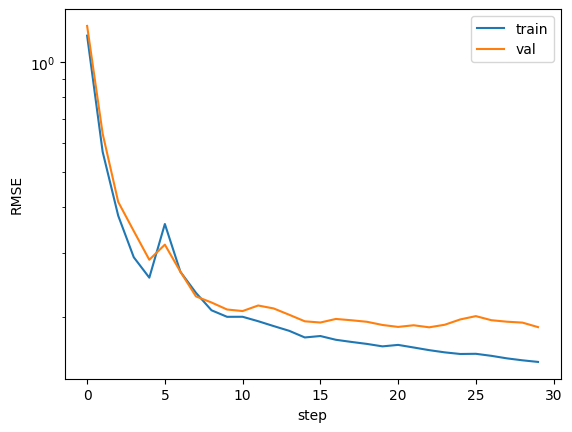

In [32]:
model = KAN(width=[attributes, 7, 1], grid=4, k=3, seed=381, device=device)
best_model_state, results, best_epoch  = custom_fit(model, dataset, opt="LBFGS", steps=30, lamb=0.001)
print(f'Best epoch {best_epoch}')
model.load_state_dict(best_model_state)
print(average_rmse(model(dataset['test_input']), dataset['test_label']))
plt.plot(results['train_loss'])
plt.plot(results['val_loss'])
plt.legend(['train', 'val'])
plt.ylabel('RMSE')
plt.xlabel('step')
plt.yscale('log')

# Grid Search for CNN

In [33]:
grid_search_cnn(dataset)

Testing cnn_blocks=1, dense_layers=1


| Train: 3.2993e-02 | Val: 4.1288e-02 |: 100%|████████████████████| 110/110 [00:39<00:00,  2.80it/s]


✅ Best validation loss: 3.5382e-02 at 59 epoch
Testing cnn_blocks=1, dense_layers=2


| Train: 3.4478e-02 | Val: 3.7311e-02 |: 100%|████████████████████| 110/110 [00:42<00:00,  2.59it/s]


✅ Best validation loss: 3.6314e-02 at 21 epoch
Testing cnn_blocks=1, dense_layers=3


| Train: 4.2882e-02 | Val: 3.7688e-02 |: 100%|████████████████████| 110/110 [00:27<00:00,  3.97it/s]


✅ Best validation loss: 3.7508e-02 at 51 epoch
Testing cnn_blocks=2, dense_layers=1


| Train: 1.4148e-02 | Val: 5.4010e-02 |: 100%|████████████████████| 110/110 [00:47<00:00,  2.29it/s]


✅ Best validation loss: 3.5957e-02 at 29 epoch
Testing cnn_blocks=2, dense_layers=2


| Train: 1.5092e-02 | Val: 3.6514e-02 |: 100%|████████████████████| 110/110 [00:53<00:00,  2.06it/s]


✅ Best validation loss: 3.3131e-02 at 70 epoch
Testing cnn_blocks=2, dense_layers=3


| Train: 2.0192e-02 | Val: 4.4046e-02 |: 100%|████████████████████| 110/110 [00:55<00:00,  1.98it/s]


✅ Best validation loss: 3.7776e-02 at 21 epoch
Testing cnn_blocks=3, dense_layers=1


| Train: 4.5006e-03 | Val: 4.1945e-02 |: 100%|████████████████████| 110/110 [00:56<00:00,  1.95it/s]


✅ Best validation loss: 3.1164e-02 at 23 epoch
Testing cnn_blocks=3, dense_layers=2


| Train: 5.1458e-03 | Val: 3.5636e-02 |: 100%|████████████████████| 110/110 [01:00<00:00,  1.81it/s]


✅ Best validation loss: 3.3005e-02 at 28 epoch
Testing cnn_blocks=3, dense_layers=3


| Train: 3.1348e-02 | Val: 3.7474e-02 |: 100%|████████████████████| 110/110 [00:54<00:00,  2.01it/s]

✅ Best validation loss: 3.6896e-02 at 35 epoch

✅ Top 5 Configurations:
1. cnn_blocks=2, dense_layers=3 | best_epoch=21 | loss=0.24021
2. cnn_blocks=2, dense_layers=2 | best_epoch=70 | loss=0.24137
3. cnn_blocks=3, dense_layers=3 | best_epoch=35 | loss=0.24607
4. cnn_blocks=3, dense_layers=1 | best_epoch=23 | loss=0.24712
5. cnn_blocks=2, dense_layers=1 | best_epoch=29 | loss=0.24810


In [34]:
grid_search_cnn(dataset)

Testing cnn_blocks=1, dense_layers=1


| Train: 3.2307e-02 | Val: 3.7762e-02 |: 100%|████████████████████| 110/110 [00:39<00:00,  2.82it/s]


✅ Best validation loss: 3.5784e-02 at 64 epoch
Testing cnn_blocks=1, dense_layers=2


| Train: 3.2531e-02 | Val: 3.3572e-02 |: 100%|████████████████████| 110/110 [00:44<00:00,  2.49it/s]


✅ Best validation loss: 3.2790e-02 at 98 epoch
Testing cnn_blocks=1, dense_layers=3


| Train: 4.4558e-02 | Val: 3.9682e-02 |: 100%|████████████████████| 110/110 [00:21<00:00,  5.09it/s]


✅ Best validation loss: 3.8894e-02 at 29 epoch
Testing cnn_blocks=2, dense_layers=1


| Train: 1.6109e-02 | Val: 5.7294e-02 |: 100%|████████████████████| 110/110 [00:47<00:00,  2.33it/s]


✅ Best validation loss: 3.6935e-02 at 46 epoch
Testing cnn_blocks=2, dense_layers=2


| Train: 1.6951e-02 | Val: 4.3216e-02 |: 100%|████████████████████| 110/110 [00:43<00:00,  2.50it/s]


✅ Best validation loss: 3.8969e-02 at 14 epoch
Testing cnn_blocks=2, dense_layers=3


| Train: 3.2372e-02 | Val: 3.9066e-02 |: 100%|████████████████████| 110/110 [00:13<00:00,  7.90it/s]


✅ Best validation loss: 3.7464e-02 at 88 epoch
Testing cnn_blocks=3, dense_layers=1


| Train: 5.7168e-03 | Val: 4.9340e-02 |: 100%|████████████████████| 110/110 [00:12<00:00,  9.08it/s]


✅ Best validation loss: 3.6456e-02 at 15 epoch
Testing cnn_blocks=3, dense_layers=2


| Train: 8.2892e-03 | Val: 4.3909e-02 |: 100%|████████████████████| 110/110 [00:15<00:00,  7.09it/s]


✅ Best validation loss: 3.2070e-02 at 37 epoch
Testing cnn_blocks=3, dense_layers=3


| Train: 5.5360e-03 | Val: 4.0641e-02 |: 100%|████████████████████| 110/110 [00:16<00:00,  6.53it/s]

✅ Best validation loss: 3.3493e-02 at 39 epoch

✅ Top 5 Configurations:
1. cnn_blocks=2, dense_layers=2 | best_epoch=14 | loss=0.24152
2. cnn_blocks=2, dense_layers=1 | best_epoch=46 | loss=0.24273
3. cnn_blocks=3, dense_layers=1 | best_epoch=15 | loss=0.24286
4. cnn_blocks=2, dense_layers=3 | best_epoch=88 | loss=0.24750
5. cnn_blocks=3, dense_layers=3 | best_epoch=39 | loss=0.24943


## ✅ Top 5 Configurations for CNN with opt=LBFGS:
1. cnn_blocks=2, dense_layers=2 | best_epoch=14 | loss=0.24152
2. cnn_blocks=2, dense_layers=1 | best_epoch=46 | loss=0.24273
3. cnn_blocks=3, dense_layers=1 | best_epoch=15 | loss=0.24286
4. cnn_blocks=2, dense_layers=3 | best_epoch=88 | loss=0.24750
5. cnn_blocks=3, dense_layers=3 | best_epoch=39 | loss=0.24943

| Train: 1.7114e-02 | Val: 3.4100e-02 |: 100%|████████████████████| 100/100 [00:46<00:00,  2.16it/s]


✅ Best validation loss: 3.3958e-02 at 93 epoch
0.20813524723052979


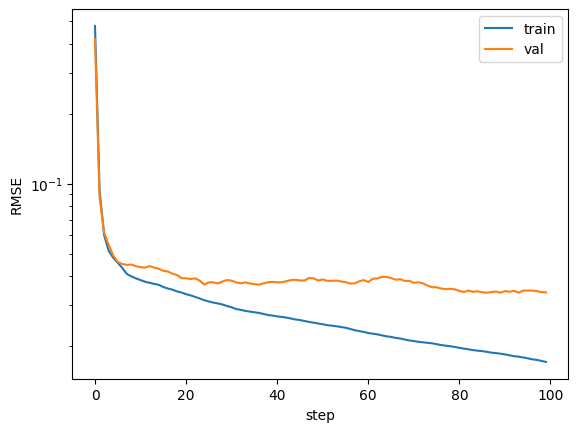

In [36]:
model0 = build_custom_cnn_model(cnn_blocks=2, dense_layers=2, imgs_shape=imgs_shape)
model_state, results, _ = fit_cnn_only_model(model0, dataset, steps=100)
model0.load_state_dict(model_state)
print(average_rmse(model0(0, dataset['test_img']), dataset['test_label']))
plt.plot(results['train_loss'])
plt.plot(results['val_loss'])
plt.legend(['train', 'val'])
plt.ylabel('RMSE')
plt.xlabel('step')
plt.yscale('log')

| Train: 2.0031e-02 | Val: 4.0847e-02 |: 100%|████████████████████| 100/100 [00:47<00:00,  2.09it/s]


✅ Best validation loss: 3.4506e-02 at 30 epoch
0.24176405370235443


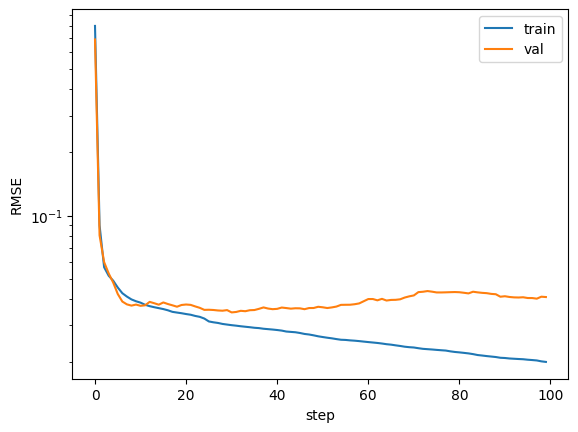

In [37]:
model0 = build_custom_cnn_model(cnn_blocks=2, dense_layers=2, imgs_shape=imgs_shape)
model_state, results, _ = fit_cnn_only_model(model0, dataset, steps=100)
model0.load_state_dict(model_state)
print(average_rmse(model0(0, dataset['test_img']), dataset['test_label']))
plt.plot(results['train_loss'])
plt.plot(results['val_loss'])
plt.legend(['train', 'val'])
plt.ylabel('RMSE')
plt.xlabel('step')
plt.yscale('log')

In [55]:
grid_search_cnn(dataset, steps=500, opt='AdamW', batch=-1)

Testing cnn_blocks=1, dense_layers=1


| Train: 8.7191e-01 | Val: 9.8407e-01 |: 100%|████████████████████| 500/500 [00:05<00:00, 95.53it/s]


✅ Best validation loss: 4.6698e-01 at 437 epoch
Testing cnn_blocks=1, dense_layers=2


| Train: 1.1943e+01 | Val: 8.8508e+00 |: 100%|████████████████████| 500/500 [00:05<00:00, 94.96it/s]


✅ Best validation loss: 3.4843e-01 at 242 epoch
Testing cnn_blocks=1, dense_layers=3


| Train: 1.1320e+01 | Val: 8.3809e+00 |: 100%|████████████████████| 500/500 [00:05<00:00, 92.06it/s]


✅ Best validation loss: 1.8981e+00 at 256 epoch
Testing cnn_blocks=2, dense_layers=1


| Train: 1.3512e+00 | Val: 4.4788e+00 |: 100%|████████████████████| 500/500 [00:06<00:00, 78.88it/s]


✅ Best validation loss: 1.6773e-01 at 245 epoch
Testing cnn_blocks=2, dense_layers=2


| Train: 6.9258e+01 | Val: 6.5784e+01 |: 100%|████████████████████| 500/500 [00:06<00:00, 77.07it/s]


✅ Best validation loss: 7.3670e-01 at 122 epoch
Testing cnn_blocks=2, dense_layers=3


| Train: 7.0460e+01 | Val: 6.6985e+01 |: 100%|████████████████████| 500/500 [00:07<00:00, 71.29it/s]


✅ Best validation loss: 9.9523e+00 at 296 epoch
Testing cnn_blocks=3, dense_layers=1


| Train: 3.9741e-01 | Val: 2.7043e-01 |: 100%|████████████████████| 500/500 [00:07<00:00, 66.75it/s]


✅ Best validation loss: 2.0316e-01 at 383 epoch
Testing cnn_blocks=3, dense_layers=2


| Train: 1.1547e+01 | Val: 8.5090e+00 |: 100%|████████████████████| 500/500 [00:07<00:00, 66.06it/s]


✅ Best validation loss: 2.8890e+00 at 212 epoch
Testing cnn_blocks=3, dense_layers=3


| Train: 1.2489e+01 | Val: 9.3498e+00 |: 100%|████████████████████| 500/500 [00:08<00:00, 57.62it/s]

✅ Best validation loss: 8.7217e+00 at 45 epoch

✅ Top 5 Configurations:
1. cnn_blocks=2, dense_layers=1 | best_epoch=245 | loss=0.55694
2. cnn_blocks=3, dense_layers=1 | best_epoch=383 | loss=0.56895
3. cnn_blocks=1, dense_layers=2 | best_epoch=242 | loss=0.76437
4. cnn_blocks=1, dense_layers=1 | best_epoch=437 | loss=0.86496
5. cnn_blocks=2, dense_layers=2 | best_epoch=122 | loss=0.99447


In [52]:
grid_search_cnn(dataset, steps=500, opt='AdamW', batch=32)

Testing cnn_blocks=1, dense_layers=1


| Train: 1.2741e+01 | Val: 3.1798e+00 |: 100%|███████████████████| 500/500 [00:04<00:00, 106.63it/s]


✅ Best validation loss: 3.8615e-01 at 487 epoch
Testing cnn_blocks=1, dense_layers=2


| Train: 8.6403e+00 | Val: 9.4239e+00 |: 100%|████████████████████| 500/500 [00:05<00:00, 91.13it/s]


✅ Best validation loss: 4.5604e+00 at 41 epoch
Testing cnn_blocks=1, dense_layers=3


| Train: 1.0781e+01 | Val: 8.8935e+00 |: 100%|████████████████████| 500/500 [00:06<00:00, 75.16it/s]


✅ Best validation loss: 4.4140e+00 at 192 epoch
Testing cnn_blocks=2, dense_layers=1


| Train: 4.2502e+01 | Val: 9.2398e+00 |: 100%|████████████████████| 500/500 [00:06<00:00, 77.92it/s]


✅ Best validation loss: 1.9458e-01 at 267 epoch
Testing cnn_blocks=2, dense_layers=2


| Train: 7.3034e+01 | Val: 6.5740e+01 |: 100%|████████████████████| 500/500 [00:07<00:00, 69.55it/s]


✅ Best validation loss: 1.2644e+00 at 200 epoch
Testing cnn_blocks=2, dense_layers=3


| Train: 6.4224e+01 | Val: 6.6965e+01 |: 100%|████████████████████| 500/500 [00:08<00:00, 59.27it/s]


✅ Best validation loss: 5.7320e+01 at 267 epoch
Testing cnn_blocks=3, dense_layers=1


| Train: 7.1168e-01 | Val: 4.8857e-01 |: 100%|████████████████████| 500/500 [00:07<00:00, 64.68it/s]


✅ Best validation loss: 2.4748e-01 at 382 epoch
Testing cnn_blocks=3, dense_layers=2


| Train: 6.6342e+01 | Val: 6.5161e+01 |: 100%|████████████████████| 500/500 [00:08<00:00, 57.84it/s]


✅ Best validation loss: 1.0096e+00 at 175 epoch
Testing cnn_blocks=3, dense_layers=3


| Train: 7.9336e+01 | Val: 6.6770e+01 |: 100%|████████████████████| 500/500 [00:09<00:00, 52.51it/s]

✅ Best validation loss: 8.8980e+00 at 138 epoch

✅ Top 5 Configurations:
1. cnn_blocks=2, dense_layers=1 | best_epoch=267 | loss=0.59095
2. cnn_blocks=3, dense_layers=1 | best_epoch=382 | loss=0.61400
3. cnn_blocks=1, dense_layers=1 | best_epoch=487 | loss=0.72442
4. cnn_blocks=3, dense_layers=2 | best_epoch=175 | loss=1.21525
5. cnn_blocks=2, dense_layers=2 | best_epoch=200 | loss=1.35100


## ✅ Top 5 Configurations for CNN with opt='AdamW':
1. cnn_blocks=2, dense_layers=1 | best_epoch=267 | loss=0.59095
2. cnn_blocks=3, dense_layers=1 | best_epoch=382 | loss=0.61400
3. cnn_blocks=1, dense_layers=1 | best_epoch=487 | loss=0.72442
4. cnn_blocks=3, dense_layers=2 | best_epoch=175 | loss=1.21525
5. cnn_blocks=2, dense_layers=2 | best_epoch=200 | loss=1.35100

| Train: 2.8664e+00 | Val: 1.3955e+00 |: 100%|████████████████████| 500/500 [00:07<00:00, 71.02it/s]


✅ Best validation loss: 2.7948e-01 at 310 epoch
0.672490656375885


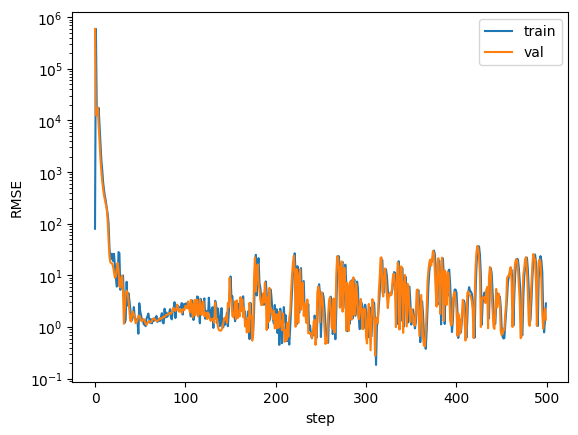

In [53]:
model0 = build_custom_cnn_model(cnn_blocks=2, dense_layers=1, imgs_shape=imgs_shape)
model_state, results, _ = fit_cnn_only_model(model0, dataset, steps=500, opt='AdamW', batch=32)
model0.load_state_dict(model_state)
print(average_rmse(model0(0, dataset['test_img']), dataset['test_label']))
plt.plot(results['train_loss'])
plt.plot(results['val_loss'])
plt.legend(['train', 'val'])
plt.ylabel('RMSE')
plt.xlabel('step')
plt.yscale('log')

| Train: 4.9167e+00 | Val: 7.7040e+00 |: 100%|████████████████████| 500/500 [00:06<00:00, 74.55it/s]


✅ Best validation loss: 1.0114e-01 at 470 epoch
0.4170120656490326


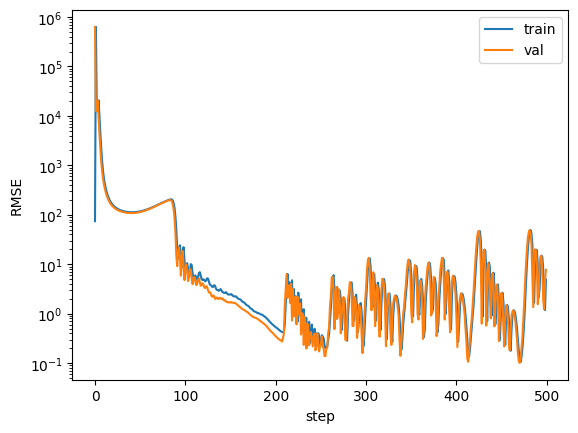

In [54]:
model0 = build_custom_cnn_model(cnn_blocks=2, dense_layers=1, imgs_shape=imgs_shape)
model_state, results, _ = fit_cnn_only_model(model0, dataset, steps=500, opt='AdamW', batch=-1)
model0.load_state_dict(model_state)
print(average_rmse(model0(0, dataset['test_img']), dataset['test_label']))
plt.plot(results['train_loss'])
plt.plot(results['val_loss'])
plt.legend(['train', 'val'])
plt.ylabel('RMSE')
plt.xlabel('step')
plt.yscale('log')

# Grid Search for Hibrid Model3

In [27]:
class Model3(nn.Module):
    def __init__(self, attributes, imgs_shape, kan_neurons, kan_grid, device=device):
        super(Model3, self).__init__()
        # CNN branch
        self.cnn_branch = nn.Sequential(
            nn.Conv2d(imgs_shape[0], 16, kernel_size=3, padding=2),     # out: 16 x 9 x 9
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2),                                            # out: 16 x 4 x 4
            
            nn.Conv2d(16, 32, kernel_size=3, padding=2),                # out: 32 x 5 x 5
            nn.LayerNorm([32, 7, 7]),
            nn.Sigmoid(),
            nn.Flatten()
        ).to(device)
        # Final KAN layers
        self.m_kan = KAN(
            width=[attributes, kan_neurons],
            grid=kan_grid,
            k=3,
            seed=SEED,
            device=device
        )

        # Calculate the size of the flattened output
        self.flat_size = self._get_flat_size(imgs_shape)

        # Final MLP layers
        self.final_kan = KAN(
            width=[self.flat_size + kan_neurons, 1],
            grid=kan_grid,
            k=3,
            seed=SEED,
            device=device
        )

        self.device = device


    def _get_flat_size(self, imgs_shape):
        # Forward pass with dummy input to calculate flat size
        dummy_input = torch.zeros(4, *imgs_shape, device=device)
        x = self.cnn_branch(dummy_input)
        return x.size(1)

    def get_concat_output(self, mlp_input, cnn_input):
        # Ensure inputs are moved to the correct device
        kan_input = mlp_input.to(self.device)
        cnn_input = cnn_input.to(self.device)
        
        cnn_output = self.cnn_branch(cnn_input)  # Process image input
        kan_output = self.m_kan(kan_input)  # Process numerical input
        
        return torch.cat((kan_output, cnn_output), dim=1)

    
    def forward(self, mlp_input, cnn_input):
        concat_output = self.get_concat_output(mlp_input, cnn_input)
        return self.final_kan(concat_output)

In [28]:
grid_search_kan_hybrid(dataset, Model3, max_steps=40)

Testing 1 hidden neurons, lamb=1.0, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 3.82e+00 | eval_loss: 2.83e+00 | reg: 3.65e+00 |: 100%|█| 40/40 [01:14<00:00,  1.87s/i


saving model version 0.1
Best epoch 0
3.0182387828826904
Testing 1 hidden neurons, lamb=0.1, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 1.55e+00 | eval_loss: 3.63e-01 | reg: 2.21e+01 |: 100%|█| 40/40 [01:13<00:00,  1.84s/i


saving model version 0.1
Best epoch 13
0.5103750824928284
Testing 1 hidden neurons, lamb=0.01, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 5.39e-01 | eval_loss: 2.04e-01 | reg: 2.47e+01 |: 100%|█| 40/40 [01:14<00:00,  1.85s/i


saving model version 0.1
Best epoch 37
0.29194995760917664
Testing 1 hidden neurons, lamb=0.001, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 2.37e-01 | eval_loss: 1.87e-01 | reg: 2.95e+01 |: 100%|█| 40/40 [01:17<00:00,  1.93s/i


saving model version 0.1
Best epoch 39
0.2526634931564331
Testing 1 hidden neurons, lamb=0.0001, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 1.69e-01 | eval_loss: 1.87e-01 | reg: 8.29e+01 |: 100%|█| 40/40 [01:18<00:00,  1.97s/i


saving model version 0.1
Best epoch 39
0.23753900825977325
Testing 1 hidden neurons, lamb=1e-05, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 1.57e-01 | eval_loss: 1.85e-01 | reg: 1.06e+02 |: 100%|█| 40/40 [01:17<00:00,  1.95s/i


saving model version 0.1
Best epoch 39
0.22614799439907074
Testing 1 hidden neurons, lamb=1.0, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 3.65e+00 | eval_loss: 2.91e+00 | reg: 1.88e+00 |: 100%|█| 40/40 [01:14<00:00,  1.87s/i


saving model version 0.1
Best epoch 0
3.103954553604126
Testing 1 hidden neurons, lamb=0.1, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 1.57e+00 | eval_loss: 3.72e-01 | reg: 2.29e+01 |: 100%|█| 40/40 [01:15<00:00,  1.89s/i


saving model version 0.1
Best epoch 22
0.5249603986740112
Testing 1 hidden neurons, lamb=0.01, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 5.38e-01 | eval_loss: 2.05e-01 | reg: 2.49e+01 |: 100%|█| 40/40 [01:16<00:00,  1.92s/i


saving model version 0.1
Best epoch 39
0.2850266396999359
Testing 1 hidden neurons, lamb=0.001, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 2.29e-01 | eval_loss: 1.95e-01 | reg: 3.20e+01 |: 100%|█| 40/40 [01:21<00:00,  2.04s/i


saving model version 0.1
Best epoch 36
0.2522721588611603
Testing 1 hidden neurons, lamb=0.0001, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 1.63e-01 | eval_loss: 1.81e-01 | reg: 8.23e+01 |: 100%|█| 40/40 [01:20<00:00,  2.02s/i


saving model version 0.1
Best epoch 39
0.2526945173740387
Testing 1 hidden neurons, lamb=1e-05, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 1.44e-01 | eval_loss: 2.00e-01 | reg: 1.29e+02 |: 100%|█| 40/40 [01:21<00:00,  2.04s/i


saving model version 0.1
Best epoch 32
0.2312689870595932
Testing 1 hidden neurons, lamb=1.0, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 3.69e+00 | eval_loss: 2.90e+00 | reg: 2.19e+00 |: 100%|█| 40/40 [01:17<00:00,  1.94s/i


saving model version 0.1
Best epoch 0
3.0857467651367188
Testing 1 hidden neurons, lamb=0.1, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 1.57e+00 | eval_loss: 3.58e-01 | reg: 2.28e+01 |: 100%|█| 40/40 [01:17<00:00,  1.95s/i


saving model version 0.1
Best epoch 39
0.5175555348396301
Testing 1 hidden neurons, lamb=0.01, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 5.41e-01 | eval_loss: 2.01e-01 | reg: 2.51e+01 |: 100%|█| 40/40 [01:18<00:00,  1.96s/i


saving model version 0.1
Best epoch 37
0.28350111842155457
Testing 1 hidden neurons, lamb=0.001, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 2.26e-01 | eval_loss: 1.81e-01 | reg: 3.22e+01 |: 100%|█| 40/40 [01:24<00:00,  2.10s/i


saving model version 0.1
Best epoch 39
0.26543670892715454
Testing 1 hidden neurons, lamb=0.0001, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 1.54e-01 | eval_loss: 1.87e-01 | reg: 8.83e+01 |: 100%|█| 40/40 [01:23<00:00,  2.08s/i


saving model version 0.1
Best epoch 32
0.2585146725177765
Testing 1 hidden neurons, lamb=1e-05, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 1.28e-01 | eval_loss: 1.90e-01 | reg: 1.37e+02 |: 100%|█| 40/40 [01:24<00:00,  2.11s/i


saving model version 0.1
Best epoch 30
0.21210351586341858
Testing 1 hidden neurons, lamb=1.0, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 3.70e+00 | eval_loss: 2.89e+00 | reg: 2.33e+00 |: 100%|█| 40/40 [01:20<00:00,  2.00s/i


saving model version 0.1
Best epoch 0
3.056384563446045
Testing 1 hidden neurons, lamb=0.1, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 1.56e+00 | eval_loss: 3.68e-01 | reg: 2.26e+01 |: 100%|█| 40/40 [01:19<00:00,  1.99s/i


saving model version 0.1
Best epoch 14
0.5259497165679932
Testing 1 hidden neurons, lamb=0.01, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 5.31e-01 | eval_loss: 2.03e-01 | reg: 2.42e+01 |: 100%|█| 40/40 [01:20<00:00,  2.02s/i


saving model version 0.1
Best epoch 37
0.28907787799835205
Testing 1 hidden neurons, lamb=0.001, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 2.18e-01 | eval_loss: 1.92e-01 | reg: 3.26e+01 |: 100%|█| 40/40 [01:25<00:00,  2.13s/i


saving model version 0.1
Best epoch 24
0.24709144234657288
Testing 1 hidden neurons, lamb=0.0001, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 1.43e-01 | eval_loss: 1.75e-01 | reg: 7.14e+01 |: 100%|█| 40/40 [01:24<00:00,  2.11s/i


saving model version 0.1
Best epoch 33
0.22014334797859192
Testing 1 hidden neurons, lamb=1e-05, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 1.20e-01 | eval_loss: 1.90e-01 | reg: 9.40e+01 |: 100%|█| 40/40 [01:24<00:00,  2.11s/i


saving model version 0.1
Best epoch 26
0.22597526013851166
Testing 1 hidden neurons, lamb=1.0, grid=7
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 3.76e+00 | eval_loss: 2.65e+00 | reg: 4.33e+00 |: 100%|█| 40/40 [01:21<00:00,  2.04s/i


saving model version 0.1
Best epoch 16
3.0563573837280273
Testing 1 hidden neurons, lamb=0.1, grid=7
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 1.56e+00 | eval_loss: 3.55e-01 | reg: 2.27e+01 |: 100%|█| 40/40 [01:21<00:00,  2.04s/i


saving model version 0.1
Best epoch 39
0.5188037157058716
Testing 1 hidden neurons, lamb=0.01, grid=7
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 5.34e-01 | eval_loss: 2.00e-01 | reg: 2.46e+01 |: 100%|█| 40/40 [01:22<00:00,  2.07s/i


saving model version 0.1
Best epoch 39
0.28507792949676514
Testing 1 hidden neurons, lamb=0.001, grid=7
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 2.15e-01 | eval_loss: 1.71e-01 | reg: 3.23e+01 |: 100%|█| 40/40 [01:27<00:00,  2.18s/i


saving model version 0.1
Best epoch 38
0.2618795931339264
Testing 1 hidden neurons, lamb=0.0001, grid=7
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 1.38e-01 | eval_loss: 1.65e-01 | reg: 8.48e+01 |: 100%|█| 40/40 [01:25<00:00,  2.14s/i


saving model version 0.1
Best epoch 38
0.2426527887582779
Testing 1 hidden neurons, lamb=1e-05, grid=7
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 1.15e-01 | eval_loss: 1.86e-01 | reg: 9.88e+01 |: 100%|█| 40/40 [01:24<00:00,  2.12s/i


saving model version 0.1
Best epoch 27
0.23800905048847198
Testing 1 hidden neurons, lamb=1.0, grid=8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 3.68e+00 | eval_loss: 2.80e+00 | reg: 2.81e+00 |: 100%|█| 40/40 [01:24<00:00,  2.12s/i


saving model version 0.1
Best epoch 0
3.080634117126465
Testing 1 hidden neurons, lamb=0.1, grid=8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 1.58e+00 | eval_loss: 3.58e-01 | reg: 2.32e+01 |: 100%|█| 40/40 [01:25<00:00,  2.14s/i


saving model version 0.1
Best epoch 39
0.5171948671340942
Testing 1 hidden neurons, lamb=0.01, grid=8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 5.40e-01 | eval_loss: 2.08e-01 | reg: 2.49e+01 |: 100%|█| 40/40 [01:25<00:00,  2.13s/i


saving model version 0.1
Best epoch 39
0.2876339256763458
Testing 1 hidden neurons, lamb=0.001, grid=8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 2.17e-01 | eval_loss: 1.80e-01 | reg: 3.31e+01 |: 100%|█| 40/40 [01:29<00:00,  2.23s/i


saving model version 0.1
Best epoch 26
0.2542000710964203
Testing 1 hidden neurons, lamb=0.0001, grid=8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 1.32e-01 | eval_loss: 1.87e-01 | reg: 8.89e+01 |: 100%|█| 40/40 [01:28<00:00,  2.22s/i


saving model version 0.1
Best epoch 34
0.23603874444961548
Testing 1 hidden neurons, lamb=1e-05, grid=8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 9.38e-02 | eval_loss: 2.01e-01 | reg: 9.93e+01 |: 100%|█| 40/40 [01:29<00:00,  2.23s/i


saving model version 0.1
Best epoch 22
0.23505041003227234
Testing 2 hidden neurons, lamb=1.0, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 3.72e+00 | eval_loss: 2.60e+00 | reg: 4.39e+00 |: 100%|█| 40/40 [01:13<00:00,  1.84s/i


saving model version 0.1
Best epoch 21
3.007385492324829
Testing 2 hidden neurons, lamb=0.1, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 1.53e+00 | eval_loss: 3.62e-01 | reg: 2.18e+01 |: 100%|█| 40/40 [01:13<00:00,  1.83s/i


saving model version 0.1
Best epoch 21
0.5122784376144409
Testing 2 hidden neurons, lamb=0.01, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 5.36e-01 | eval_loss: 2.10e-01 | reg: 2.43e+01 |: 100%|█| 40/40 [01:14<00:00,  1.86s/i


saving model version 0.1
Best epoch 39
0.29224488139152527
Testing 2 hidden neurons, lamb=0.001, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 2.30e-01 | eval_loss: 1.78e-01 | reg: 3.00e+01 |: 100%|█| 40/40 [01:18<00:00,  1.96s/i


saving model version 0.1
Best epoch 39
0.2511485815048218
Testing 2 hidden neurons, lamb=0.0001, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 1.75e-01 | eval_loss: 1.89e-01 | reg: 6.75e+01 |: 100%|█| 40/40 [01:20<00:00,  2.00s/i


saving model version 0.1
Best epoch 34
0.2550356090068817
Testing 2 hidden neurons, lamb=1e-05, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 1.57e-01 | eval_loss: 1.86e-01 | reg: 1.00e+02 |: 100%|█| 40/40 [01:19<00:00,  1.99s/i


saving model version 0.1
Best epoch 38
0.23781849443912506
Testing 2 hidden neurons, lamb=1.0, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 3.78e+00 | eval_loss: 2.80e+00 | reg: 3.57e+00 |: 100%|█| 40/40 [01:16<00:00,  1.90s/i


saving model version 0.1
Best epoch 0
3.0793826580047607
Testing 2 hidden neurons, lamb=0.1, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 1.54e+00 | eval_loss: 3.49e-01 | reg: 2.21e+01 |: 100%|█| 40/40 [01:16<00:00,  1.92s/i


saving model version 0.1
Best epoch 39
0.5108949542045593
Testing 2 hidden neurons, lamb=0.01, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 5.25e-01 | eval_loss: 2.02e-01 | reg: 2.35e+01 |: 100%|█| 40/40 [01:16<00:00,  1.92s/i


saving model version 0.1
Best epoch 37
0.28063732385635376
Testing 2 hidden neurons, lamb=0.001, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 2.27e-01 | eval_loss: 1.74e-01 | reg: 3.24e+01 |: 100%|█| 40/40 [01:21<00:00,  2.05s/i


saving model version 0.1
Best epoch 36
0.24347025156021118
Testing 2 hidden neurons, lamb=0.0001, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 1.62e-01 | eval_loss: 1.86e-01 | reg: 8.30e+01 |: 100%|█| 40/40 [01:20<00:00,  2.02s/i


saving model version 0.1
Best epoch 39
0.2523078918457031
Testing 2 hidden neurons, lamb=1e-05, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 1.40e-01 | eval_loss: 1.83e-01 | reg: 1.19e+02 |: 100%|█| 40/40 [01:21<00:00,  2.03s/i


saving model version 0.1
Best epoch 34
0.2526470720767975
Testing 2 hidden neurons, lamb=1.0, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 3.77e+00 | eval_loss: 2.69e+00 | reg: 4.19e+00 |: 100%|█| 40/40 [01:18<00:00,  1.97s/i


saving model version 0.1
Best epoch 0
3.024312734603882
Testing 2 hidden neurons, lamb=0.1, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 1.52e+00 | eval_loss: 3.52e-01 | reg: 2.15e+01 |: 100%|█| 40/40 [01:18<00:00,  1.97s/i


saving model version 0.1
Best epoch 39
0.5149192214012146
Testing 2 hidden neurons, lamb=0.01, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 5.18e-01 | eval_loss: 1.96e-01 | reg: 2.29e+01 |: 100%|█| 40/40 [01:19<00:00,  1.98s/i


saving model version 0.1
Best epoch 39
0.2816965878009796
Testing 2 hidden neurons, lamb=0.001, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 2.32e-01 | eval_loss: 1.71e-01 | reg: 3.34e+01 |: 100%|█| 40/40 [01:24<00:00,  2.12s/i


saving model version 0.1
Best epoch 39
0.24396657943725586
Testing 2 hidden neurons, lamb=0.0001, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 1.57e-01 | eval_loss: 1.73e-01 | reg: 8.95e+01 |: 100%|█| 40/40 [01:24<00:00,  2.11s/i


saving model version 0.1
Best epoch 39
0.25351855158805847
Testing 2 hidden neurons, lamb=1e-05, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 1.37e-01 | eval_loss: 1.75e-01 | reg: 1.06e+02 |: 100%|█| 40/40 [01:23<00:00,  2.10s/i


saving model version 0.1
Best epoch 39
0.23162870109081268
Testing 2 hidden neurons, lamb=1.0, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 3.78e+00 | eval_loss: 2.76e+00 | reg: 3.84e+00 |: 100%|█| 40/40 [01:17<00:00,  1.93s/i


saving model version 0.1
Best epoch 0
3.066338539123535
Testing 2 hidden neurons, lamb=0.1, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 1.51e+00 | eval_loss: 3.36e-01 | reg: 2.13e+01 |: 100%|█| 40/40 [01:20<00:00,  2.00s/i


saving model version 0.1
Best epoch 39
0.5026146173477173
Testing 2 hidden neurons, lamb=0.01, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 5.20e-01 | eval_loss: 2.01e-01 | reg: 2.32e+01 |: 100%|█| 40/40 [01:21<00:00,  2.03s/i


saving model version 0.1
Best epoch 34
0.2796619236469269
Testing 2 hidden neurons, lamb=0.001, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 2.16e-01 | eval_loss: 1.64e-01 | reg: 3.39e+01 |: 100%|█| 40/40 [01:24<00:00,  2.12s/i


saving model version 0.1
Best epoch 37
0.26116645336151123
Testing 2 hidden neurons, lamb=0.0001, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 1.41e-01 | eval_loss: 1.70e-01 | reg: 8.17e+01 |: 100%|█| 40/40 [01:24<00:00,  2.12s/i


saving model version 0.1
Best epoch 35
0.24631188809871674
Testing 2 hidden neurons, lamb=1e-05, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 1.20e-01 | eval_loss: 1.92e-01 | reg: 1.10e+02 |: 100%|█| 40/40 [01:25<00:00,  2.14s/i


saving model version 0.1
Best epoch 24
0.2264695018529892
Testing 2 hidden neurons, lamb=1.0, grid=7
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 3.71e+00 | eval_loss: 2.76e+00 | reg: 3.29e+00 |: 100%|█| 40/40 [01:24<00:00,  2.12s/i


saving model version 0.1
Best epoch 0
3.0834128856658936
Testing 2 hidden neurons, lamb=0.1, grid=7
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 1.53e+00 | eval_loss: 3.46e-01 | reg: 2.19e+01 |: 100%|█| 40/40 [01:21<00:00,  2.04s/i


saving model version 0.1
Best epoch 39
0.5131946802139282
Testing 2 hidden neurons, lamb=0.01, grid=7
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 5.25e-01 | eval_loss: 2.04e-01 | reg: 2.36e+01 |: 100%|█| 40/40 [01:22<00:00,  2.07s/i


saving model version 0.1
Best epoch 37
0.29159051179885864
Testing 2 hidden neurons, lamb=0.001, grid=7
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 2.16e-01 | eval_loss: 1.74e-01 | reg: 3.29e+01 |: 100%|█| 40/40 [01:28<00:00,  2.20s/i


saving model version 0.1
Best epoch 29
0.24319221079349518
Testing 2 hidden neurons, lamb=0.0001, grid=7
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 1.44e-01 | eval_loss: 1.83e-01 | reg: 7.47e+01 |: 100%|█| 40/40 [01:27<00:00,  2.19s/i


saving model version 0.1
Best epoch 35
0.24193622171878815
Testing 2 hidden neurons, lamb=1e-05, grid=7
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 1.13e-01 | eval_loss: 1.89e-01 | reg: 1.11e+02 |: 100%|█| 40/40 [01:28<00:00,  2.20s/i


saving model version 0.1
Best epoch 39
0.23763994872570038
Testing 2 hidden neurons, lamb=1.0, grid=8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 3.76e+00 | eval_loss: 2.79e+00 | reg: 3.45e+00 |: 100%|█| 40/40 [01:24<00:00,  2.11s/i


saving model version 0.1
Best epoch 0
3.067426919937134
Testing 2 hidden neurons, lamb=0.1, grid=8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 1.52e+00 | eval_loss: 3.61e-01 | reg: 2.14e+01 |: 100%|█| 40/40 [01:24<00:00,  2.11s/i


saving model version 0.1
Best epoch 29
0.5132119059562683
Testing 2 hidden neurons, lamb=0.01, grid=8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 5.22e-01 | eval_loss: 1.92e-01 | reg: 2.35e+01 |: 100%|█| 40/40 [01:24<00:00,  2.11s/i


saving model version 0.1
Best epoch 39
0.28275159001350403
Testing 2 hidden neurons, lamb=0.001, grid=8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 2.07e-01 | eval_loss: 1.66e-01 | reg: 3.40e+01 |: 100%|█| 40/40 [01:31<00:00,  2.29s/i


saving model version 0.1
Best epoch 39
0.26348331570625305
Testing 2 hidden neurons, lamb=0.0001, grid=8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 1.25e-01 | eval_loss: 1.87e-01 | reg: 6.89e+01 |: 100%|█| 40/40 [01:31<00:00,  2.30s/i


saving model version 0.1
Best epoch 24
0.23081430792808533
Testing 2 hidden neurons, lamb=1e-05, grid=8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 1.04e-01 | eval_loss: 1.96e-01 | reg: 1.27e+02 |: 100%|█| 40/40 [01:30<00:00,  2.27s/i


saving model version 0.1
Best epoch 26
0.2473825365304947
Testing 3 hidden neurons, lamb=1.0, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 3.73e+00 | eval_loss: 2.75e+00 | reg: 3.53e+00 |: 100%|█| 40/40 [01:12<00:00,  1.80s/i


saving model version 0.1
Best epoch 0
3.0920543670654297
Testing 3 hidden neurons, lamb=0.1, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 1.54e+00 | eval_loss: 3.40e-01 | reg: 2.20e+01 |: 100%|█| 40/40 [01:13<00:00,  1.83s/i


saving model version 0.1
Best epoch 23
0.5050898194313049
Testing 3 hidden neurons, lamb=0.01, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 5.28e-01 | eval_loss: 2.03e-01 | reg: 2.36e+01 |: 100%|█| 40/40 [01:13<00:00,  1.85s/i


saving model version 0.1
Best epoch 34
0.2913414239883423
Testing 3 hidden neurons, lamb=0.001, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 2.32e-01 | eval_loss: 1.89e-01 | reg: 2.98e+01 |: 100%|█| 40/40 [01:17<00:00,  1.95s/i


saving model version 0.1
Best epoch 33
0.25422203540802
Testing 3 hidden neurons, lamb=0.0001, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 1.71e-01 | eval_loss: 2.04e-01 | reg: 7.29e+01 |: 100%|█| 40/40 [01:19<00:00,  1.99s/i


saving model version 0.1
Best epoch 32
0.22858290374279022
Testing 3 hidden neurons, lamb=1e-05, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 1.55e-01 | eval_loss: 1.90e-01 | reg: 1.20e+02 |: 100%|█| 40/40 [01:20<00:00,  2.02s/i


saving model version 0.1
Best epoch 34
0.2396799921989441
Testing 3 hidden neurons, lamb=1.0, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 3.75e+00 | eval_loss: 2.41e+00 | reg: 5.77e+00 |: 100%|█| 40/40 [01:16<00:00,  1.91s/i


saving model version 0.1
Best epoch 29
2.8196394443511963
Testing 3 hidden neurons, lamb=0.1, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 1.51e+00 | eval_loss: 3.48e-01 | reg: 2.12e+01 |: 100%|█| 40/40 [01:16<00:00,  1.90s/i


saving model version 0.1
Best epoch 39
0.5111916065216064
Testing 3 hidden neurons, lamb=0.01, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 5.25e-01 | eval_loss: 2.03e-01 | reg: 2.33e+01 |: 100%|█| 40/40 [01:16<00:00,  1.92s/i


saving model version 0.1
Best epoch 36
0.28951603174209595
Testing 3 hidden neurons, lamb=0.001, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 2.26e-01 | eval_loss: 1.92e-01 | reg: 3.44e+01 |: 100%|█| 40/40 [01:22<00:00,  2.06s/i


saving model version 0.1
Best epoch 34
0.25492751598358154
Testing 3 hidden neurons, lamb=0.0001, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 1.63e-01 | eval_loss: 2.00e-01 | reg: 9.37e+01 |: 100%|█| 40/40 [01:23<00:00,  2.10s/i


saving model version 0.1
Best epoch 26
0.2378515899181366
Testing 3 hidden neurons, lamb=1e-05, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 1.29e-01 | eval_loss: 2.14e-01 | reg: 1.17e+02 |: 100%|█| 40/40 [01:23<00:00,  2.09s/i


saving model version 0.1
Best epoch 18
0.23290961980819702
Testing 3 hidden neurons, lamb=1.0, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 3.67e+00 | eval_loss: 2.74e+00 | reg: 3.10e+00 |: 100%|█| 40/40 [01:18<00:00,  1.97s/i


saving model version 0.1
Best epoch 0
3.0372517108917236
Testing 3 hidden neurons, lamb=0.1, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 1.50e+00 | eval_loss: 3.44e-01 | reg: 2.09e+01 |: 100%|█| 40/40 [01:19<00:00,  1.99s/i


saving model version 0.1
Best epoch 35
0.512556791305542
Testing 3 hidden neurons, lamb=0.01, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 5.18e-01 | eval_loss: 1.95e-01 | reg: 2.30e+01 |: 100%|█| 40/40 [01:19<00:00,  1.98s/i


saving model version 0.1
Best epoch 38
0.2841237783432007
Testing 3 hidden neurons, lamb=0.001, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 2.24e-01 | eval_loss: 1.73e-01 | reg: 3.23e+01 |: 100%|█| 40/40 [01:25<00:00,  2.14s/i


saving model version 0.1
Best epoch 39
0.2451305091381073
Testing 3 hidden neurons, lamb=0.0001, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 1.59e-01 | eval_loss: 1.84e-01 | reg: 7.57e+01 |: 100%|█| 40/40 [01:25<00:00,  2.13s/i


saving model version 0.1
Best epoch 39
0.23764687776565552
Testing 3 hidden neurons, lamb=1e-05, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 1.29e-01 | eval_loss: 1.91e-01 | reg: 1.25e+02 |: 100%|█| 40/40 [01:24<00:00,  2.12s/i


saving model version 0.1
Best epoch 24
0.22775664925575256
Testing 3 hidden neurons, lamb=1.0, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 3.68e+00 | eval_loss: 2.71e+00 | reg: 3.32e+00 |: 100%|█| 40/40 [01:21<00:00,  2.03s/i


saving model version 0.1
Best epoch 0
3.0473482608795166
Testing 3 hidden neurons, lamb=0.1, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 1.49e+00 | eval_loss: 3.40e-01 | reg: 2.06e+01 |: 100%|█| 40/40 [01:19<00:00,  1.99s/i


saving model version 0.1
Best epoch 28
0.49907776713371277
Testing 3 hidden neurons, lamb=0.01, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 5.19e-01 | eval_loss: 2.00e-01 | reg: 2.31e+01 |: 100%|█| 40/40 [01:20<00:00,  2.02s/i


saving model version 0.1
Best epoch 39
0.2836068272590637
Testing 3 hidden neurons, lamb=0.001, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 2.20e-01 | eval_loss: 1.89e-01 | reg: 3.15e+01 |: 100%|█| 40/40 [01:26<00:00,  2.17s/i


saving model version 0.1
Best epoch 39
0.24035002291202545
Testing 3 hidden neurons, lamb=0.0001, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 1.37e-01 | eval_loss: 2.18e-01 | reg: 8.72e+01 |: 100%|█| 40/40 [01:27<00:00,  2.19s/i


saving model version 0.1
Best epoch 21
0.24601782858371735
Testing 3 hidden neurons, lamb=1e-05, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 1.10e-01 | eval_loss: 1.84e-01 | reg: 1.20e+02 |: 100%|█| 40/40 [01:27<00:00,  2.18s/i


saving model version 0.1
Best epoch 38
0.27603214979171753
Testing 3 hidden neurons, lamb=1.0, grid=7
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 3.70e+00 | eval_loss: 2.75e+00 | reg: 3.27e+00 |: 100%|█| 40/40 [01:22<00:00,  2.06s/i


saving model version 0.1
Best epoch 0
3.0606234073638916
Testing 3 hidden neurons, lamb=0.1, grid=7
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 1.51e+00 | eval_loss: 3.40e-01 | reg: 2.12e+01 |: 100%|█| 40/40 [01:22<00:00,  2.06s/i


saving model version 0.1
Best epoch 39
0.5021644830703735
Testing 3 hidden neurons, lamb=0.01, grid=7
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 5.13e-01 | eval_loss: 1.96e-01 | reg: 2.25e+01 |: 100%|█| 40/40 [01:22<00:00,  2.05s/i


saving model version 0.1
Best epoch 39
0.2788717448711395
Testing 3 hidden neurons, lamb=0.001, grid=7
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 2.12e-01 | eval_loss: 1.78e-01 | reg: 3.38e+01 |: 100%|█| 40/40 [01:28<00:00,  2.22s/i


saving model version 0.1
Best epoch 32
0.23849330842494965
Testing 3 hidden neurons, lamb=0.0001, grid=7
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 1.40e-01 | eval_loss: 1.80e-01 | reg: 8.82e+01 |: 100%|█| 40/40 [01:26<00:00,  2.16s/i


saving model version 0.1
Best epoch 39
0.24717551469802856
Testing 3 hidden neurons, lamb=1e-05, grid=7
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 9.67e-02 | eval_loss: 1.81e-01 | reg: 1.28e+02 |: 100%|█| 40/40 [01:28<00:00,  2.20s/i


saving model version 0.1
Best epoch 32
0.2383413016796112
Testing 3 hidden neurons, lamb=1.0, grid=8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 3.76e+00 | eval_loss: 2.81e+00 | reg: 3.31e+00 |: 100%|█| 40/40 [01:21<00:00,  2.03s/i


saving model version 0.1
Best epoch 0
3.085167646408081
Testing 3 hidden neurons, lamb=0.1, grid=8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 1.51e+00 | eval_loss: 3.49e-01 | reg: 2.12e+01 |: 100%|█| 40/40 [01:24<00:00,  2.11s/i


saving model version 0.1
Best epoch 39
0.5141092538833618
Testing 3 hidden neurons, lamb=0.01, grid=8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 5.19e-01 | eval_loss: 1.99e-01 | reg: 2.30e+01 |: 100%|█| 40/40 [01:26<00:00,  2.17s/i


saving model version 0.1
Best epoch 39
0.2867611050605774
Testing 3 hidden neurons, lamb=0.001, grid=8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 2.15e-01 | eval_loss: 1.77e-01 | reg: 3.66e+01 |: 100%|█| 40/40 [01:29<00:00,  2.25s/i


saving model version 0.1
Best epoch 28
0.2494843453168869
Testing 3 hidden neurons, lamb=0.0001, grid=8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 1.36e-01 | eval_loss: 1.85e-01 | reg: 8.74e+01 |: 100%|█| 40/40 [01:31<00:00,  2.30s/i


saving model version 0.1
Best epoch 36
0.24543164670467377
Testing 3 hidden neurons, lamb=1e-05, grid=8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 8.99e-02 | eval_loss: 1.90e-01 | reg: 1.04e+02 |: 100%|█| 40/40 [01:30<00:00,  2.27s/i


saving model version 0.1
Best epoch 26
0.25939348340034485
Testing 4 hidden neurons, lamb=1.0, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 3.77e+00 | eval_loss: 2.54e+00 | reg: 5.11e+00 |: 100%|█| 40/40 [01:14<00:00,  1.85s/i


saving model version 0.1
Best epoch 39
2.9568042755126953
Testing 4 hidden neurons, lamb=0.1, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 1.50e+00 | eval_loss: 3.55e-01 | reg: 2.08e+01 |: 100%|█| 40/40 [01:13<00:00,  1.83s/i


saving model version 0.1
Best epoch 39
0.5124614238739014
Testing 4 hidden neurons, lamb=0.01, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 5.18e-01 | eval_loss: 2.03e-01 | reg: 2.28e+01 |: 100%|█| 40/40 [01:13<00:00,  1.85s/i


saving model version 0.1
Best epoch 39
0.2813211977481842
Testing 4 hidden neurons, lamb=0.001, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 2.28e-01 | eval_loss: 1.80e-01 | reg: 2.95e+01 |: 100%|█| 40/40 [01:19<00:00,  1.99s/i


saving model version 0.1
Best epoch 39
0.23005932569503784
Testing 4 hidden neurons, lamb=0.0001, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 1.76e-01 | eval_loss: 1.85e-01 | reg: 7.38e+01 |: 100%|█| 40/40 [01:20<00:00,  2.00s/i


saving model version 0.1
Best epoch 26
0.2411552518606186
Testing 4 hidden neurons, lamb=1e-05, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 1.58e-01 | eval_loss: 2.00e-01 | reg: 1.30e+02 |: 100%|█| 40/40 [01:20<00:00,  2.01s/i


saving model version 0.1
Best epoch 26
0.23854266107082367
Testing 4 hidden neurons, lamb=1.0, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 3.77e+00 | eval_loss: 2.63e+00 | reg: 4.62e+00 |: 100%|█| 40/40 [01:19<00:00,  1.99s/i


saving model version 0.1
Best epoch 39
3.0486578941345215
Testing 4 hidden neurons, lamb=0.1, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 1.49e+00 | eval_loss: 3.36e-01 | reg: 2.05e+01 |: 100%|█| 40/40 [01:15<00:00,  1.89s/i


saving model version 0.1
Best epoch 39
0.5021058320999146
Testing 4 hidden neurons, lamb=0.01, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 5.26e-01 | eval_loss: 2.07e-01 | reg: 2.35e+01 |: 100%|█| 40/40 [01:17<00:00,  1.93s/i


saving model version 0.1
Best epoch 39
0.28759250044822693
Testing 4 hidden neurons, lamb=0.001, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 2.25e-01 | eval_loss: 1.81e-01 | reg: 3.19e+01 |: 100%|█| 40/40 [01:22<00:00,  2.07s/i


saving model version 0.1
Best epoch 39
0.25411099195480347
Testing 4 hidden neurons, lamb=0.0001, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 1.68e-01 | eval_loss: 1.93e-01 | reg: 7.14e+01 |: 100%|█| 40/40 [01:21<00:00,  2.05s/i


saving model version 0.1
Best epoch 23
0.23948317766189575
Testing 4 hidden neurons, lamb=1e-05, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 1.40e-01 | eval_loss: 1.92e-01 | reg: 1.38e+02 |: 100%|█| 40/40 [01:22<00:00,  2.06s/i


saving model version 0.1
Best epoch 31
0.24750317633152008
Testing 4 hidden neurons, lamb=1.0, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 3.68e+00 | eval_loss: 2.36e+00 | reg: 5.52e+00 |: 100%|█| 40/40 [01:18<00:00,  1.97s/i


saving model version 0.1
Best epoch 39
2.788886070251465
Testing 4 hidden neurons, lamb=0.1, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 1.50e+00 | eval_loss: 3.50e-01 | reg: 2.08e+01 |: 100%|█| 40/40 [01:17<00:00,  1.95s/i


saving model version 0.1
Best epoch 35
0.512150764465332
Testing 4 hidden neurons, lamb=0.01, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 5.13e-01 | eval_loss: 1.96e-01 | reg: 2.25e+01 |: 100%|█| 40/40 [01:19<00:00,  1.99s/i


saving model version 0.1
Best epoch 39
0.28098347783088684
Testing 4 hidden neurons, lamb=0.001, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 2.19e-01 | eval_loss: 1.76e-01 | reg: 3.30e+01 |: 100%|█| 40/40 [01:24<00:00,  2.11s/i


saving model version 0.1
Best epoch 38
0.2395363599061966
Testing 4 hidden neurons, lamb=0.0001, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 1.40e-01 | eval_loss: 1.82e-01 | reg: 7.13e+01 |: 100%|█| 40/40 [01:25<00:00,  2.15s/i


saving model version 0.1
Best epoch 29
0.21360576152801514
Testing 4 hidden neurons, lamb=1e-05, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 1.26e-01 | eval_loss: 1.92e-01 | reg: 1.07e+02 |: 100%|█| 40/40 [01:24<00:00,  2.10s/i


saving model version 0.1
Best epoch 22
0.22797568142414093
Testing 4 hidden neurons, lamb=1.0, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 3.70e+00 | eval_loss: 2.65e+00 | reg: 3.96e+00 |: 100%|█| 40/40 [01:20<00:00,  2.01s/i


saving model version 0.1
Best epoch 17
3.023942232131958
Testing 4 hidden neurons, lamb=0.1, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 1.50e+00 | eval_loss: 3.47e-01 | reg: 2.10e+01 |: 100%|█| 40/40 [01:20<00:00,  2.00s/i


saving model version 0.1
Best epoch 39
0.5131281018257141
Testing 4 hidden neurons, lamb=0.01, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 5.16e-01 | eval_loss: 2.00e-01 | reg: 2.28e+01 |: 100%|█| 40/40 [01:20<00:00,  2.02s/i


saving model version 0.1
Best epoch 39
0.28342440724372864
Testing 4 hidden neurons, lamb=0.001, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 2.14e-01 | eval_loss: 1.78e-01 | reg: 3.31e+01 |: 100%|█| 40/40 [01:25<00:00,  2.14s/i


saving model version 0.1
Best epoch 29
0.25718045234680176
Testing 4 hidden neurons, lamb=0.0001, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 1.42e-01 | eval_loss: 1.86e-01 | reg: 7.18e+01 |: 100%|█| 40/40 [01:25<00:00,  2.14s/i


saving model version 0.1
Best epoch 24
0.23897124826908112
Testing 4 hidden neurons, lamb=1e-05, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 1.08e-01 | eval_loss: 1.96e-01 | reg: 1.22e+02 |: 100%|█| 40/40 [01:25<00:00,  2.15s/i


saving model version 0.1
Best epoch 27
0.2590189576148987
Testing 4 hidden neurons, lamb=1.0, grid=7
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 3.68e+00 | eval_loss: 2.80e+00 | reg: 2.78e+00 |: 100%|█| 40/40 [01:10<00:00,  1.77s/i


saving model version 0.1
Best epoch 0
3.099539279937744
Testing 4 hidden neurons, lamb=0.1, grid=7
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 1.49e+00 | eval_loss: 3.35e-01 | reg: 2.06e+01 |: 100%|█| 40/40 [01:21<00:00,  2.04s/i


saving model version 0.1
Best epoch 39
0.5041255354881287
Testing 4 hidden neurons, lamb=0.01, grid=7
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 5.13e-01 | eval_loss: 2.00e-01 | reg: 2.25e+01 |: 100%|█| 40/40 [01:23<00:00,  2.08s/i


saving model version 0.1
Best epoch 29
0.2911404073238373
Testing 4 hidden neurons, lamb=0.001, grid=7
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 2.18e-01 | eval_loss: 1.91e-01 | reg: 3.45e+01 |: 100%|█| 40/40 [01:28<00:00,  2.20s/i


saving model version 0.1
Best epoch 19
0.24781107902526855
Testing 4 hidden neurons, lamb=0.0001, grid=7
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 1.49e-01 | eval_loss: 1.98e-01 | reg: 8.04e+01 |: 100%|█| 40/40 [01:28<00:00,  2.20s/i


saving model version 0.1
Best epoch 20
0.26823267340660095
Testing 4 hidden neurons, lamb=1e-05, grid=7
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 1.02e-01 | eval_loss: 1.78e-01 | reg: 1.18e+02 |: 100%|█| 40/40 [01:28<00:00,  2.21s/i


saving model version 0.1
Best epoch 32
0.2514961063861847
Testing 4 hidden neurons, lamb=1.0, grid=8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 3.74e+00 | eval_loss: 2.72e+00 | reg: 3.71e+00 |: 100%|█| 40/40 [01:25<00:00,  2.14s/i


saving model version 0.1
Best epoch 0
3.093687057495117
Testing 4 hidden neurons, lamb=0.1, grid=8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 1.50e+00 | eval_loss: 3.47e-01 | reg: 2.09e+01 |: 100%|█| 40/40 [01:25<00:00,  2.13s/i


saving model version 0.1
Best epoch 30
0.5147867798805237
Testing 4 hidden neurons, lamb=0.01, grid=8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 5.17e-01 | eval_loss: 2.03e-01 | reg: 2.30e+01 |: 100%|█| 40/40 [01:25<00:00,  2.14s/i


saving model version 0.1
Best epoch 39
0.2879009544849396
Testing 4 hidden neurons, lamb=0.001, grid=8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 2.09e-01 | eval_loss: 1.74e-01 | reg: 3.31e+01 |: 100%|█| 40/40 [01:31<00:00,  2.30s/i


saving model version 0.1
Best epoch 34
0.27761712670326233
Testing 4 hidden neurons, lamb=0.0001, grid=8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 1.26e-01 | eval_loss: 1.83e-01 | reg: 7.78e+01 |: 100%|█| 40/40 [01:30<00:00,  2.27s/i


saving model version 0.1
Best epoch 23
0.2437228262424469
Testing 4 hidden neurons, lamb=1e-05, grid=8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 1.03e-01 | eval_loss: 1.79e-01 | reg: 1.21e+02 |: 100%|█| 40/40 [01:29<00:00,  2.25s/i


saving model version 0.1
Best epoch 38
0.3240533173084259
Testing 5 hidden neurons, lamb=1.0, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 3.77e+00 | eval_loss: 2.43e+00 | reg: 5.79e+00 |: 100%|█| 40/40 [01:14<00:00,  1.87s/i


saving model version 0.1
Best epoch 39
2.870060443878174
Testing 5 hidden neurons, lamb=0.1, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 1.48e+00 | eval_loss: 3.28e-01 | reg: 2.04e+01 |: 100%|█| 40/40 [01:13<00:00,  1.83s/i


saving model version 0.1
Best epoch 32
0.4991879463195801
Testing 5 hidden neurons, lamb=0.01, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 5.12e-01 | eval_loss: 2.01e-01 | reg: 2.21e+01 |: 100%|█| 40/40 [01:13<00:00,  1.84s/i


saving model version 0.1
Best epoch 38
0.29591986536979675
Testing 5 hidden neurons, lamb=0.001, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 2.31e-01 | eval_loss: 1.94e-01 | reg: 2.91e+01 |: 100%|█| 40/40 [01:19<00:00,  1.98s/i


saving model version 0.1
Best epoch 30
0.2517658770084381
Testing 5 hidden neurons, lamb=0.0001, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 1.73e-01 | eval_loss: 2.02e-01 | reg: 7.35e+01 |: 100%|█| 40/40 [01:19<00:00,  1.99s/i


saving model version 0.1
Best epoch 27
0.23998281359672546
Testing 5 hidden neurons, lamb=1e-05, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 1.58e-01 | eval_loss: 1.84e-01 | reg: 1.22e+02 |: 100%|█| 40/40 [01:19<00:00,  1.98s/i


saving model version 0.1
Best epoch 28
0.23587492108345032
Testing 5 hidden neurons, lamb=1.0, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 3.76e+00 | eval_loss: 2.59e+00 | reg: 4.77e+00 |: 100%|█| 40/40 [01:17<00:00,  1.93s/i


saving model version 0.1
Best epoch 12
2.9833486080169678
Testing 5 hidden neurons, lamb=0.1, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 1.50e+00 | eval_loss: 3.48e-01 | reg: 2.09e+01 |: 100%|█| 40/40 [01:16<00:00,  1.91s/i


saving model version 0.1
Best epoch 39
0.5099123120307922
Testing 5 hidden neurons, lamb=0.01, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 5.21e-01 | eval_loss: 2.05e-01 | reg: 2.30e+01 |: 100%|█| 40/40 [01:17<00:00,  1.93s/i


saving model version 0.1
Best epoch 29
0.2879795432090759
Testing 5 hidden neurons, lamb=0.001, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 2.20e-01 | eval_loss: 1.91e-01 | reg: 2.90e+01 |: 100%|█| 40/40 [01:22<00:00,  2.07s/i


saving model version 0.1
Best epoch 29
0.2500762939453125
Testing 5 hidden neurons, lamb=0.0001, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 1.58e-01 | eval_loss: 1.86e-01 | reg: 7.94e+01 |: 100%|█| 40/40 [01:23<00:00,  2.08s/i


saving model version 0.1
Best epoch 30
0.25368237495422363
Testing 5 hidden neurons, lamb=1e-05, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 1.40e-01 | eval_loss: 1.91e-01 | reg: 1.19e+02 |: 100%|█| 40/40 [01:22<00:00,  2.06s/i


saving model version 0.1
Best epoch 21
0.23284882307052612
Testing 5 hidden neurons, lamb=1.0, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 3.74e+00 | eval_loss: 2.52e+00 | reg: 4.99e+00 |: 100%|█| 40/40 [01:20<00:00,  2.01s/i


saving model version 0.1
Best epoch 38
2.9374239444732666
Testing 5 hidden neurons, lamb=0.1, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 1.49e+00 | eval_loss: 3.35e-01 | reg: 2.06e+01 |: 100%|█| 40/40 [01:19<00:00,  1.98s/i


saving model version 0.1
Best epoch 33
0.4969673156738281
Testing 5 hidden neurons, lamb=0.01, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 5.09e-01 | eval_loss: 1.95e-01 | reg: 2.22e+01 |: 100%|█| 40/40 [01:19<00:00,  1.99s/i


saving model version 0.1
Best epoch 39
0.2841935157775879
Testing 5 hidden neurons, lamb=0.001, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 2.24e-01 | eval_loss: 1.86e-01 | reg: 3.13e+01 |: 100%|█| 40/40 [01:25<00:00,  2.13s/i


saving model version 0.1
Best epoch 39
0.23448848724365234
Testing 5 hidden neurons, lamb=0.0001, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 1.54e-01 | eval_loss: 1.98e-01 | reg: 8.12e+01 |: 100%|█| 40/40 [01:25<00:00,  2.13s/i


saving model version 0.1
Best epoch 28
0.2419620156288147
Testing 5 hidden neurons, lamb=1e-05, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 1.39e-01 | eval_loss: 1.89e-01 | reg: 1.02e+02 |: 100%|█| 40/40 [01:24<00:00,  2.12s/i


saving model version 0.1
Best epoch 28
0.23693275451660156
Testing 5 hidden neurons, lamb=1.0, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 3.65e+00 | eval_loss: 2.83e+00 | reg: 2.41e+00 |: 100%|█| 40/40 [01:20<00:00,  2.02s/i


saving model version 0.1
Best epoch 0
3.068063497543335
Testing 5 hidden neurons, lamb=0.1, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 1.48e+00 | eval_loss: 3.36e-01 | reg: 2.05e+01 |: 100%|█| 40/40 [01:20<00:00,  2.02s/i


saving model version 0.1
Best epoch 39
0.4982682168483734
Testing 5 hidden neurons, lamb=0.01, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 5.06e-01 | eval_loss: 1.93e-01 | reg: 2.20e+01 |: 100%|█| 40/40 [01:21<00:00,  2.03s/i


saving model version 0.1
Best epoch 39
0.28879597783088684
Testing 5 hidden neurons, lamb=0.001, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 2.21e-01 | eval_loss: 1.80e-01 | reg: 3.33e+01 |: 100%|█| 40/40 [01:27<00:00,  2.19s/i


saving model version 0.1
Best epoch 27
0.2515307366847992
Testing 5 hidden neurons, lamb=0.0001, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 1.46e-01 | eval_loss: 2.05e-01 | reg: 7.35e+01 |: 100%|█| 40/40 [01:29<00:00,  2.24s/i


saving model version 0.1
Best epoch 26
0.2549249827861786
Testing 5 hidden neurons, lamb=1e-05, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 1.20e-01 | eval_loss: 1.90e-01 | reg: 1.13e+02 |: 100%|█| 40/40 [01:27<00:00,  2.18s/i


saving model version 0.1
Best epoch 17
0.23921115696430206
Testing 5 hidden neurons, lamb=1.0, grid=7
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 3.70e+00 | eval_loss: 2.42e+00 | reg: 5.32e+00 |: 100%|█| 40/40 [01:23<00:00,  2.10s/i


saving model version 0.1
Best epoch 39
2.8436288833618164
Testing 5 hidden neurons, lamb=0.1, grid=7
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 1.50e+00 | eval_loss: 3.46e-01 | reg: 2.07e+01 |: 100%|█| 40/40 [01:21<00:00,  2.05s/i


saving model version 0.1
Best epoch 37
0.5109756588935852
Testing 5 hidden neurons, lamb=0.01, grid=7
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 5.11e-01 | eval_loss: 2.01e-01 | reg: 2.24e+01 |: 100%|█| 40/40 [01:23<00:00,  2.09s/i


saving model version 0.1
Best epoch 35
0.2839038074016571
Testing 5 hidden neurons, lamb=0.001, grid=7
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 2.14e-01 | eval_loss: 1.70e-01 | reg: 3.24e+01 |: 100%|█| 40/40 [01:28<00:00,  2.21s/i


saving model version 0.1
Best epoch 37
0.250726580619812
Testing 5 hidden neurons, lamb=0.0001, grid=7
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 1.22e-01 | eval_loss: 2.01e-01 | reg: 6.82e+01 |: 100%|█| 40/40 [01:29<00:00,  2.25s/i


saving model version 0.1
Best epoch 29
0.2371821403503418
Testing 5 hidden neurons, lamb=1e-05, grid=7
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 9.80e-02 | eval_loss: 1.78e-01 | reg: 1.17e+02 |: 100%|█| 40/40 [01:29<00:00,  2.25s/i


saving model version 0.1
Best epoch 30
0.2592470347881317
Testing 5 hidden neurons, lamb=1.0, grid=8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 3.72e+00 | eval_loss: 2.72e+00 | reg: 3.55e+00 |: 100%|█| 40/40 [01:22<00:00,  2.07s/i


saving model version 0.1
Best epoch 8
3.1277830600738525
Testing 5 hidden neurons, lamb=0.1, grid=8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 1.50e+00 | eval_loss: 3.38e-01 | reg: 2.09e+01 |: 100%|█| 40/40 [01:25<00:00,  2.14s/i


saving model version 0.1
Best epoch 39
0.5065115690231323
Testing 5 hidden neurons, lamb=0.01, grid=8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 5.10e-01 | eval_loss: 1.98e-01 | reg: 2.23e+01 |: 100%|█| 40/40 [01:25<00:00,  2.14s/i


saving model version 0.1
Best epoch 39
0.28634464740753174
Testing 5 hidden neurons, lamb=0.001, grid=8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 2.16e-01 | eval_loss: 1.74e-01 | reg: 3.61e+01 |: 100%|█| 40/40 [01:29<00:00,  2.23s/i


saving model version 0.1
Best epoch 29
0.23973049223423004
Testing 5 hidden neurons, lamb=0.0001, grid=8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 1.21e-01 | eval_loss: 1.91e-01 | reg: 8.15e+01 |: 100%|█| 40/40 [01:29<00:00,  2.23s/i


saving model version 0.1
Best epoch 29
0.23222149908542633
Testing 5 hidden neurons, lamb=1e-05, grid=8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 9.33e-02 | eval_loss: 1.99e-01 | reg: 1.40e+02 |: 100%|█| 40/40 [01:29<00:00,  2.24s/i


saving model version 0.1
Best epoch 13
0.24166500568389893
Testing 6 hidden neurons, lamb=1.0, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 3.64e+00 | eval_loss: 2.38e+00 | reg: 5.09e+00 |: 100%|█| 40/40 [01:14<00:00,  1.86s/i


saving model version 0.1
Best epoch 39
2.8179802894592285
Testing 6 hidden neurons, lamb=0.1, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 1.47e+00 | eval_loss: 3.33e-01 | reg: 2.01e+01 |: 100%|█| 40/40 [01:13<00:00,  1.83s/i


saving model version 0.1
Best epoch 23
0.48874449729919434
Testing 6 hidden neurons, lamb=0.01, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 5.14e-01 | eval_loss: 2.05e-01 | reg: 2.24e+01 |: 100%|█| 40/40 [01:14<00:00,  1.85s/i


saving model version 0.1
Best epoch 38
0.2832966446876526
Testing 6 hidden neurons, lamb=0.001, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 2.25e-01 | eval_loss: 1.81e-01 | reg: 2.90e+01 |: 100%|█| 40/40 [01:19<00:00,  1.99s/i


saving model version 0.1
Best epoch 39
0.24178852140903473
Testing 6 hidden neurons, lamb=0.0001, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 1.77e-01 | eval_loss: 1.92e-01 | reg: 7.36e+01 |: 100%|█| 40/40 [01:20<00:00,  2.01s/i


saving model version 0.1
Best epoch 20
0.2448618859052658
Testing 6 hidden neurons, lamb=1e-05, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 1.56e-01 | eval_loss: 1.92e-01 | reg: 1.14e+02 |: 100%|█| 40/40 [01:19<00:00,  1.98s/i


saving model version 0.1
Best epoch 21
0.24308085441589355
Testing 6 hidden neurons, lamb=1.0, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 3.73e+00 | eval_loss: 2.75e+00 | reg: 3.53e+00 |: 100%|█| 40/40 [01:17<00:00,  1.95s/i


saving model version 0.1
Best epoch 0
3.0891201496124268
Testing 6 hidden neurons, lamb=0.1, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 1.51e+00 | eval_loss: 3.42e-01 | reg: 2.10e+01 |: 100%|█| 40/40 [01:16<00:00,  1.92s/i


saving model version 0.1
Best epoch 39
0.5115834474563599
Testing 6 hidden neurons, lamb=0.01, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 5.10e-01 | eval_loss: 1.99e-01 | reg: 2.22e+01 |: 100%|█| 40/40 [01:17<00:00,  1.94s/i


saving model version 0.1
Best epoch 38
0.28743594884872437
Testing 6 hidden neurons, lamb=0.001, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 2.28e-01 | eval_loss: 1.79e-01 | reg: 3.12e+01 |: 100%|█| 40/40 [01:23<00:00,  2.08s/i


saving model version 0.1
Best epoch 39
0.2612241208553314
Testing 6 hidden neurons, lamb=0.0001, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 1.54e-01 | eval_loss: 1.90e-01 | reg: 8.05e+01 |: 100%|█| 40/40 [01:22<00:00,  2.07s/i


saving model version 0.1
Best epoch 32
0.2439112514257431
Testing 6 hidden neurons, lamb=1e-05, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 1.25e-01 | eval_loss: 1.91e-01 | reg: 1.26e+02 |: 100%|█| 40/40 [01:23<00:00,  2.08s/i


saving model version 0.1
Best epoch 28
0.2530207931995392
Testing 6 hidden neurons, lamb=1.0, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 3.68e+00 | eval_loss: 2.30e+00 | reg: 5.88e+00 |: 100%|█| 40/40 [01:19<00:00,  1.99s/i


saving model version 0.1
Best epoch 39
2.7259511947631836
Testing 6 hidden neurons, lamb=0.1, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 1.48e+00 | eval_loss: 3.35e-01 | reg: 2.04e+01 |: 100%|█| 40/40 [01:18<00:00,  1.95s/i


saving model version 0.1
Best epoch 36
0.4945031404495239
Testing 6 hidden neurons, lamb=0.01, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 5.05e-01 | eval_loss: 2.02e-01 | reg: 2.18e+01 |: 100%|█| 40/40 [01:19<00:00,  2.00s/i


saving model version 0.1
Best epoch 39
0.2855563759803772
Testing 6 hidden neurons, lamb=0.001, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 2.27e-01 | eval_loss: 2.14e-01 | reg: 3.37e+01 |: 100%|█| 40/40 [01:25<00:00,  2.13s/i


saving model version 0.1
Best epoch 25
0.25035569071769714
Testing 6 hidden neurons, lamb=0.0001, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 1.48e-01 | eval_loss: 2.01e-01 | reg: 9.13e+01 |: 100%|█| 40/40 [01:25<00:00,  2.13s/i


saving model version 0.1
Best epoch 29
0.2383376806974411
Testing 6 hidden neurons, lamb=1e-05, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 1.26e-01 | eval_loss: 3.40e-01 | reg: 1.55e+02 |: 100%|█| 40/40 [01:25<00:00,  2.15s/i


saving model version 0.1
Best epoch 23
0.23181673884391785
Testing 6 hidden neurons, lamb=1.0, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 3.79e+00 | eval_loss: 2.40e+00 | reg: 6.14e+00 |: 100%|█| 40/40 [01:21<00:00,  2.03s/i


saving model version 0.1
Best epoch 39
2.820910692214966
Testing 6 hidden neurons, lamb=0.1, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 1.48e+00 | eval_loss: 3.39e-01 | reg: 2.04e+01 |: 100%|█| 40/40 [01:20<00:00,  2.00s/i


saving model version 0.1
Best epoch 39
0.5030317306518555
Testing 6 hidden neurons, lamb=0.01, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 5.12e-01 | eval_loss: 1.92e-01 | reg: 2.25e+01 |: 100%|█| 40/40 [01:20<00:00,  2.00s/i


saving model version 0.1
Best epoch 38
0.2785987854003906
Testing 6 hidden neurons, lamb=0.001, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 2.16e-01 | eval_loss: 1.69e-01 | reg: 3.49e+01 |: 100%|█| 40/40 [01:24<00:00,  2.11s/i


saving model version 0.1
Best epoch 39
0.2458307445049286
Testing 6 hidden neurons, lamb=0.0001, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 1.32e-01 | eval_loss: 1.77e-01 | reg: 7.31e+01 |: 100%|█| 40/40 [01:25<00:00,  2.15s/i


saving model version 0.1
Best epoch 38
0.25155335664749146
Testing 6 hidden neurons, lamb=1e-05, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 1.10e-01 | eval_loss: 1.93e-01 | reg: 1.03e+02 |: 100%|█| 40/40 [01:26<00:00,  2.17s/i


saving model version 0.1
Best epoch 33
0.25503823161125183
Testing 6 hidden neurons, lamb=1.0, grid=7
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 3.79e+00 | eval_loss: 2.69e+00 | reg: 4.35e+00 |: 100%|█| 40/40 [01:21<00:00,  2.05s/i


saving model version 0.1
Best epoch 8
3.0707693099975586
Testing 6 hidden neurons, lamb=0.1, grid=7
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 1.48e+00 | eval_loss: 3.33e-01 | reg: 2.04e+01 |: 100%|█| 40/40 [01:21<00:00,  2.04s/i


saving model version 0.1
Best epoch 39
0.500055193901062
Testing 6 hidden neurons, lamb=0.01, grid=7
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 5.10e-01 | eval_loss: 1.88e-01 | reg: 2.24e+01 |: 100%|█| 40/40 [01:23<00:00,  2.08s/i


saving model version 0.1
Best epoch 39
0.2801932692527771
Testing 6 hidden neurons, lamb=0.001, grid=7
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 2.20e-01 | eval_loss: 1.81e-01 | reg: 3.45e+01 |: 100%|█| 40/40 [01:27<00:00,  2.19s/i


saving model version 0.1
Best epoch 24
0.24838955700397491
Testing 6 hidden neurons, lamb=0.0001, grid=7
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 1.20e-01 | eval_loss: 1.83e-01 | reg: 6.73e+01 |: 100%|█| 40/40 [01:27<00:00,  2.20s/i


saving model version 0.1
Best epoch 33
0.23832562565803528
Testing 6 hidden neurons, lamb=1e-05, grid=7
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 8.67e-02 | eval_loss: 1.86e-01 | reg: 9.65e+01 |: 100%|█| 40/40 [01:28<00:00,  2.20s/i


saving model version 0.1
Best epoch 21
0.2129114270210266
Testing 6 hidden neurons, lamb=1.0, grid=8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 3.69e+00 | eval_loss: 2.68e+00 | reg: 3.64e+00 |: 100%|█| 40/40 [01:25<00:00,  2.13s/i


saving model version 0.1
Best epoch 25
3.096611976623535
Testing 6 hidden neurons, lamb=0.1, grid=8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 1.50e+00 | eval_loss: 3.24e-01 | reg: 2.11e+01 |: 100%|█| 40/40 [01:24<00:00,  2.10s/i


saving model version 0.1
Best epoch 39
0.4978148341178894
Testing 6 hidden neurons, lamb=0.01, grid=8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 5.05e-01 | eval_loss: 1.88e-01 | reg: 2.21e+01 |: 100%|█| 40/40 [01:25<00:00,  2.14s/i


saving model version 0.1
Best epoch 39
0.27588731050491333
Testing 6 hidden neurons, lamb=0.001, grid=8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 2.12e-01 | eval_loss: 1.87e-01 | reg: 3.48e+01 |: 100%|█| 40/40 [01:31<00:00,  2.28s/i


saving model version 0.1
Best epoch 26
0.2476193904876709
Testing 6 hidden neurons, lamb=0.0001, grid=8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 1.15e-01 | eval_loss: 1.81e-01 | reg: 7.58e+01 |: 100%|█| 40/40 [01:29<00:00,  2.25s/i


saving model version 0.1
Best epoch 32
0.2766837477684021
Testing 6 hidden neurons, lamb=1e-05, grid=8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 8.30e-02 | eval_loss: 2.01e-01 | reg: 1.04e+02 |: 100%|█| 40/40 [01:30<00:00,  2.27s/i


saving model version 0.1
Best epoch 23
0.2428288608789444
Testing 7 hidden neurons, lamb=1.0, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 3.65e+00 | eval_loss: 2.10e+00 | reg: 6.71e+00 |: 100%|█| 40/40 [01:13<00:00,  1.84s/i


saving model version 0.1
Best epoch 39
2.5273468494415283
Testing 7 hidden neurons, lamb=0.1, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 1.48e+00 | eval_loss: 3.33e-01 | reg: 2.04e+01 |: 100%|█| 40/40 [01:12<00:00,  1.82s/i


saving model version 0.1
Best epoch 39
0.5042538642883301
Testing 7 hidden neurons, lamb=0.01, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 5.04e-01 | eval_loss: 2.05e-01 | reg: 2.14e+01 |: 100%|█| 40/40 [01:14<00:00,  1.86s/i


saving model version 0.1
Best epoch 38
0.28879252076148987
Testing 7 hidden neurons, lamb=0.001, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 2.31e-01 | eval_loss: 1.86e-01 | reg: 2.93e+01 |: 100%|█| 40/40 [01:20<00:00,  2.01s/i


saving model version 0.1
Best epoch 39
0.24353310465812683
Testing 7 hidden neurons, lamb=0.0001, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 1.78e-01 | eval_loss: 1.94e-01 | reg: 6.70e+01 |: 100%|█| 40/40 [01:21<00:00,  2.03s/i


saving model version 0.1
Best epoch 27
0.260555237531662
Testing 7 hidden neurons, lamb=1e-05, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 1.58e-01 | eval_loss: 1.97e-01 | reg: 9.47e+01 |: 100%|█| 40/40 [01:19<00:00,  1.99s/i


saving model version 0.1
Best epoch 30
0.242073193192482
Testing 7 hidden neurons, lamb=1.0, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 3.62e+00 | eval_loss: 2.56e+00 | reg: 3.92e+00 |: 100%|█| 40/40 [01:17<00:00,  1.95s/i


saving model version 0.1
Best epoch 39
2.976983070373535
Testing 7 hidden neurons, lamb=0.1, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 1.48e+00 | eval_loss: 3.32e-01 | reg: 2.04e+01 |: 100%|█| 40/40 [01:15<00:00,  1.90s/i


saving model version 0.1
Best epoch 32
0.4979231059551239
Testing 7 hidden neurons, lamb=0.01, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 5.14e-01 | eval_loss: 2.00e-01 | reg: 2.25e+01 |: 100%|█| 40/40 [01:17<00:00,  1.93s/i


saving model version 0.1
Best epoch 39
0.2855061888694763
Testing 7 hidden neurons, lamb=0.001, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 2.26e-01 | eval_loss: 1.85e-01 | reg: 3.13e+01 |: 100%|█| 40/40 [01:22<00:00,  2.06s/i


saving model version 0.1
Best epoch 28
0.2518441677093506
Testing 7 hidden neurons, lamb=0.0001, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 1.54e-01 | eval_loss: 2.10e-01 | reg: 7.98e+01 |: 100%|█| 40/40 [01:22<00:00,  2.06s/i


saving model version 0.1
Best epoch 16
0.24382160604000092
Testing 7 hidden neurons, lamb=1e-05, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 1.47e-01 | eval_loss: 2.03e-01 | reg: 1.05e+02 |: 100%|█| 40/40 [01:23<00:00,  2.09s/i


saving model version 0.1
Best epoch 18
0.23744332790374756
Testing 7 hidden neurons, lamb=1.0, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 3.77e+00 | eval_loss: 2.73e+00 | reg: 4.02e+00 |: 100%|█| 40/40 [01:18<00:00,  1.97s/i


saving model version 0.1
Best epoch 0
3.0721275806427
Testing 7 hidden neurons, lamb=0.1, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 1.48e+00 | eval_loss: 3.37e-01 | reg: 2.04e+01 |: 100%|█| 40/40 [01:18<00:00,  1.96s/i


saving model version 0.1
Best epoch 39
0.5083073973655701
Testing 7 hidden neurons, lamb=0.01, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 5.04e-01 | eval_loss: 2.04e-01 | reg: 2.15e+01 |: 100%|█| 40/40 [01:20<00:00,  2.01s/i


saving model version 0.1
Best epoch 39
0.2877315878868103
Testing 7 hidden neurons, lamb=0.001, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 2.23e-01 | eval_loss: 1.79e-01 | reg: 3.23e+01 |: 100%|█| 40/40 [01:26<00:00,  2.17s/i


saving model version 0.1
Best epoch 39
0.26993775367736816
Testing 7 hidden neurons, lamb=0.0001, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 1.52e-01 | eval_loss: 1.93e-01 | reg: 8.28e+01 |: 100%|█| 40/40 [01:24<00:00,  2.12s/i


saving model version 0.1
Best epoch 25
0.24755185842514038
Testing 7 hidden neurons, lamb=1e-05, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 1.19e-01 | eval_loss: 2.02e-01 | reg: 1.22e+02 |: 100%|█| 40/40 [01:24<00:00,  2.10s/i


saving model version 0.1
Best epoch 32
0.2340555191040039
Testing 7 hidden neurons, lamb=1.0, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 3.76e+00 | eval_loss: 2.69e+00 | reg: 4.11e+00 |: 100%|█| 40/40 [01:24<00:00,  2.12s/i


saving model version 0.1
Best epoch 21
3.0988664627075195
Testing 7 hidden neurons, lamb=0.1, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 1.50e+00 | eval_loss: 3.49e-01 | reg: 2.10e+01 |: 100%|█| 40/40 [01:21<00:00,  2.03s/i


saving model version 0.1
Best epoch 23
0.5025423169136047
Testing 7 hidden neurons, lamb=0.01, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 5.09e-01 | eval_loss: 2.05e-01 | reg: 2.21e+01 |: 100%|█| 40/40 [01:21<00:00,  2.04s/i


saving model version 0.1
Best epoch 29
0.28823280334472656
Testing 7 hidden neurons, lamb=0.001, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 2.20e-01 | eval_loss: 1.74e-01 | reg: 3.54e+01 |: 100%|█| 40/40 [01:26<00:00,  2.16s/i


saving model version 0.1
Best epoch 33
0.25734323263168335
Testing 7 hidden neurons, lamb=0.0001, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 1.44e-01 | eval_loss: 1.98e-01 | reg: 8.64e+01 |: 100%|█| 40/40 [01:32<00:00,  2.32s/i


saving model version 0.1
Best epoch 21
0.2546636760234833
Testing 7 hidden neurons, lamb=1e-05, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 1.14e-01 | eval_loss: 1.90e-01 | reg: 1.21e+02 |: 100%|█| 40/40 [01:26<00:00,  2.17s/i


saving model version 0.1
Best epoch 38
0.2397737056016922
Testing 7 hidden neurons, lamb=1.0, grid=7
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 3.68e+00 | eval_loss: 2.64e+00 | reg: 3.82e+00 |: 100%|█| 40/40 [01:13<00:00,  1.83s/i


saving model version 0.1
Best epoch 7
3.0210816860198975
Testing 7 hidden neurons, lamb=0.1, grid=7
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 1.49e+00 | eval_loss: 3.21e-01 | reg: 2.06e+01 |: 100%|█| 40/40 [01:27<00:00,  2.18s/i


saving model version 0.1
Best epoch 39
0.48636069893836975
Testing 7 hidden neurons, lamb=0.01, grid=7
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 5.04e-01 | eval_loss: 1.94e-01 | reg: 2.18e+01 |: 100%|█| 40/40 [01:24<00:00,  2.11s/i


saving model version 0.1
Best epoch 37
0.2790301740169525
Testing 7 hidden neurons, lamb=0.001, grid=7
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 2.09e-01 | eval_loss: 1.58e-01 | reg: 3.37e+01 |: 100%|█| 40/40 [01:28<00:00,  2.22s/i


saving model version 0.1
Best epoch 38
0.2541278004646301
Testing 7 hidden neurons, lamb=0.0001, grid=7
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 1.23e-01 | eval_loss: 1.78e-01 | reg: 7.19e+01 |: 100%|█| 40/40 [01:28<00:00,  2.21s/i


saving model version 0.1
Best epoch 32
0.2428319752216339
Testing 7 hidden neurons, lamb=1e-05, grid=7
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 9.57e-02 | eval_loss: 1.92e-01 | reg: 9.97e+01 |: 100%|█| 40/40 [01:27<00:00,  2.19s/i


saving model version 0.1
Best epoch 31
0.2574554681777954
Testing 7 hidden neurons, lamb=1.0, grid=8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 3.72e+00 | eval_loss: 2.60e+00 | reg: 4.37e+00 |: 100%|█| 40/40 [01:28<00:00,  2.22s/i


saving model version 0.1
Best epoch 39
3.028148889541626
Testing 7 hidden neurons, lamb=0.1, grid=8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 1.49e+00 | eval_loss: 3.45e-01 | reg: 2.06e+01 |: 100%|█| 40/40 [01:25<00:00,  2.14s/i


saving model version 0.1
Best epoch 36
0.5098813772201538
Testing 7 hidden neurons, lamb=0.01, grid=8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 5.01e-01 | eval_loss: 1.83e-01 | reg: 2.18e+01 |: 100%|█| 40/40 [01:25<00:00,  2.15s/i


saving model version 0.1
Best epoch 39
0.28470608592033386
Testing 7 hidden neurons, lamb=0.001, grid=8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 2.14e-01 | eval_loss: 1.76e-01 | reg: 3.45e+01 |: 100%|█| 40/40 [01:30<00:00,  2.25s/i


saving model version 0.1
Best epoch 25
0.2554795742034912
Testing 7 hidden neurons, lamb=0.0001, grid=8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 1.29e-01 | eval_loss: 1.89e-01 | reg: 7.27e+01 |: 100%|█| 40/40 [01:31<00:00,  2.28s/i


saving model version 0.1
Best epoch 11
0.2530447244644165
Testing 7 hidden neurons, lamb=1e-05, grid=8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 9.96e-02 | eval_loss: 1.88e-01 | reg: 1.07e+02 |: 100%|█| 40/40 [01:30<00:00,  2.25s/i

saving model version 0.1
Best epoch 10
0.2589361071586609

✅ Top 5 Configurations:
1. width=[15, 1, 1], grid=5, lamb=1e-05| best_epoch=30 | loss=0.21210
2. width=[15, 6, 1], grid=7, lamb=1e-05| best_epoch=21 | loss=0.21291
3. width=[15, 4, 1], grid=5, lamb=0.0001| best_epoch=29 | loss=0.21361
4. width=[15, 1, 1], grid=6, lamb=0.0001| best_epoch=33 | loss=0.22014
5. width=[15, 1, 1], grid=6, lamb=1e-05| best_epoch=26 | loss=0.22598


## ✅ Top 5 Configurations:
1. width=[15, 7, 1], grid=4, lamb=1e-05 | loss=0.21412
2. width=[15, 6, 1], grid=4, lamb=0.001 | loss=0.21556
3. width=[15, 5, 1], grid=5, lamb=1e-05 | loss=0.21705
4. width=[15, 2, 1], grid=8, lamb=0.001 | loss=0.22572
5. width=[15, 6, 1], grid=4, lamb=0.0001 | loss=0.22918

# Grid Search for Hibrid Model4

In [24]:
class Model4(nn.Module):
    def __init__(self, attributes, imgs_shape, kan_neurons, kan_grid, device=device):
        super(Model4, self).__init__()

        self.cnn_branch = nn.Sequential(
            nn.Conv2d(imgs_shape[0], 16, kernel_size=3, padding=2),     # out: 16 x 9 x 9
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2),                                            # out: 16 x 4 x 4
            
            nn.Conv2d(16, 32, kernel_size=3, padding=2),                # out: 32 x 5 x 5
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),                                            # 32 x 2 x 2
            
            nn.Conv2d(32, 64, kernel_size=3, padding=2),
            nn.LayerNorm([64, 5, 5]),
            nn.Sigmoid(),
            nn.Flatten()
        ).to(device)

        # Middle KAN layers
        self.m_kan = KAN(
            width=[attributes, kan_neurons],
            grid=kan_grid,
            k=3,
            seed=SEED,
            device=device
        )
        # Calculate the size of the flattened output
        self.flat_size = self._get_flat_size(imgs_shape)
        # Final MLP layers
        self.final_kan = KAN(
            width=[self.flat_size + kan_neurons, 1],
            grid=kan_grid,
            k=3,
            device=device
        )
        
        self.device = device

    def _get_flat_size(self, imgs_shape):
        # Forward pass with dummy input to calculate flat size
        dummy_input = torch.zeros(4, *imgs_shape, device=device)
        x = self.cnn_branch(dummy_input)
        return x.size(1)

    def get_concat_output(self, mlp_input, cnn_input):
        # Ensure inputs are moved to the correct device
        kan_input = mlp_input.to(self.device)
        cnn_input = cnn_input.to(self.device)
        
        cnn_output = self.cnn_branch(cnn_input)  # Process image input
        kan_output = self.m_kan(kan_input)  # Process numerical input
        
        return torch.cat((kan_output, cnn_output), dim=1)

    
    def forward(self, mlp_input, cnn_input):
        concat_output = self.get_concat_output(mlp_input, cnn_input)
        return self.final_kan(concat_output)

In [25]:
grid_search_kan_hybrid(dataset, Model4, max_steps=50)

Testing 1 hidden neurons, lamb=1.0, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 3.49e+00 | eval_loss: 2.99e+00 | reg: 1.97e-01 |: 100%|█| 50/50 [00:53<00:00,  1.06s/i


saving model version 0.1
Best epoch 0
3.309527635574341
Testing 1 hidden neurons, lamb=0.1, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 1.52e+00 | eval_loss: 3.03e-01 | reg: 2.18e+01 |: 100%|█| 50/50 [00:55<00:00,  1.10s/i


saving model version 0.1
Best epoch 36
0.4823254346847534
Testing 1 hidden neurons, lamb=0.01, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 5.05e-01 | eval_loss: 1.99e-01 | reg: 2.27e+01 |: 100%|█| 50/50 [00:54<00:00,  1.10s/i


saving model version 0.1
Best epoch 49
0.3108844757080078
Testing 1 hidden neurons, lamb=0.001, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 2.05e-01 | eval_loss: 1.89e-01 | reg: 2.99e+01 |: 100%|█| 50/50 [00:58<00:00,  1.17s/i


saving model version 0.1
Best epoch 30
0.2670741081237793
Testing 1 hidden neurons, lamb=0.0001, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 1.25e-01 | eval_loss: 1.95e-01 | reg: 5.83e+01 |: 100%|█| 50/50 [00:57<00:00,  1.14s/i


saving model version 0.1
Best epoch 49
0.24077104032039642
Testing 1 hidden neurons, lamb=1e-05, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 1.04e-01 | eval_loss: 1.79e-01 | reg: 8.34e+01 |: 100%|█| 50/50 [00:57<00:00,  1.16s/i


saving model version 0.1
Best epoch 48
0.22293391823768616
Testing 1 hidden neurons, lamb=1.0, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 3.49e+00 | eval_loss: 2.99e+00 | reg: 1.70e-01 |: 100%|█| 50/50 [00:49<00:00,  1.01it/


saving model version 0.1
Best epoch 0
3.354829788208008
Testing 1 hidden neurons, lamb=0.1, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 1.52e+00 | eval_loss: 3.01e-01 | reg: 2.20e+01 |: 100%|█| 50/50 [00:58<00:00,  1.16s/i


saving model version 0.1
Best epoch 49
0.4730590581893921
Testing 1 hidden neurons, lamb=0.01, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 5.01e-01 | eval_loss: 1.98e-01 | reg: 2.24e+01 |: 100%|█| 50/50 [00:58<00:00,  1.17s/i


saving model version 0.1
Best epoch 14
0.2908843159675598
Testing 1 hidden neurons, lamb=0.001, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 1.97e-01 | eval_loss: 1.94e-01 | reg: 2.83e+01 |: 100%|█| 50/50 [01:01<00:00,  1.24s/i


saving model version 0.1
Best epoch 21
0.26197466254234314
Testing 1 hidden neurons, lamb=0.0001, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 1.23e-01 | eval_loss: 1.92e-01 | reg: 5.43e+01 |: 100%|█| 50/50 [01:02<00:00,  1.25s/i


saving model version 0.1
Best epoch 18
0.2606702148914337
Testing 1 hidden neurons, lamb=1e-05, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 1.02e-01 | eval_loss: 2.09e-01 | reg: 7.40e+01 |: 100%|█| 50/50 [01:02<00:00,  1.26s/i


saving model version 0.1
Best epoch 25
0.2660409212112427
Testing 1 hidden neurons, lamb=1.0, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 3.49e+00 | eval_loss: 2.99e+00 | reg: 1.79e-01 |: 100%|█| 50/50 [00:56<00:00,  1.13s/i


saving model version 0.1
Best epoch 1
3.382932662963867
Testing 1 hidden neurons, lamb=0.1, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 1.53e+00 | eval_loss: 2.98e-01 | reg: 2.21e+01 |: 100%|█| 50/50 [01:04<00:00,  1.28s/i


saving model version 0.1
Best epoch 49
0.473615825176239
Testing 1 hidden neurons, lamb=0.01, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 5.09e-01 | eval_loss: 1.84e-01 | reg: 2.33e+01 |: 100%|█| 50/50 [01:04<00:00,  1.29s/i


saving model version 0.1
Best epoch 49
0.2999529540538788
Testing 1 hidden neurons, lamb=0.001, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 1.94e-01 | eval_loss: 2.13e-01 | reg: 2.82e+01 |: 100%|█| 50/50 [01:08<00:00,  1.37s/i


saving model version 0.1
Best epoch 4
0.25895214080810547
Testing 1 hidden neurons, lamb=0.0001, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 1.23e-01 | eval_loss: 2.01e-01 | reg: 5.74e+01 |: 100%|█| 50/50 [01:08<00:00,  1.36s/i


saving model version 0.1
Best epoch 20
0.2730351984500885
Testing 1 hidden neurons, lamb=1e-05, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 1.09e-01 | eval_loss: 2.04e-01 | reg: 8.50e+01 |: 100%|█| 50/50 [01:09<00:00,  1.39s/i


saving model version 0.1
Best epoch 17
0.2524537444114685
Testing 1 hidden neurons, lamb=1.0, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 3.49e+00 | eval_loss: 2.98e+00 | reg: 2.05e-01 |: 100%|█| 50/50 [00:54<00:00,  1.08s/i


saving model version 0.1
Best epoch 1
3.3886425495147705
Testing 1 hidden neurons, lamb=0.1, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 1.52e+00 | eval_loss: 3.06e-01 | reg: 2.17e+01 |: 100%|█| 50/50 [01:09<00:00,  1.38s/i


saving model version 0.1
Best epoch 6
0.47546523809432983
Testing 1 hidden neurons, lamb=0.01, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 5.08e-01 | eval_loss: 1.87e-01 | reg: 2.29e+01 |: 100%|█| 50/50 [01:09<00:00,  1.39s/i


saving model version 0.1
Best epoch 49
0.3082226812839508
Testing 1 hidden neurons, lamb=0.001, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 2.04e-01 | eval_loss: 1.89e-01 | reg: 3.02e+01 |: 100%|█| 50/50 [01:12<00:00,  1.45s/i


saving model version 0.1
Best epoch 28
0.2669004499912262
Testing 1 hidden neurons, lamb=0.0001, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 1.25e-01 | eval_loss: 1.86e-01 | reg: 6.03e+01 |: 100%|█| 50/50 [01:13<00:00,  1.47s/i


saving model version 0.1
Best epoch 14
0.2315918654203415
Testing 1 hidden neurons, lamb=1e-05, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 9.40e-02 | eval_loss: 2.30e-01 | reg: 8.13e+01 |: 100%|█| 50/50 [01:11<00:00,  1.43s/i


saving model version 0.1
Best epoch 16
0.23600530624389648
Testing 1 hidden neurons, lamb=1.0, grid=7
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 3.49e+00 | eval_loss: 2.99e+00 | reg: 1.54e-01 |: 100%|█| 50/50 [01:04<00:00,  1.30s/i


saving model version 0.1
Best epoch 0
3.359649419784546
Testing 1 hidden neurons, lamb=0.1, grid=7
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 1.51e+00 | eval_loss: 3.09e-01 | reg: 2.14e+01 |: 100%|█| 50/50 [01:12<00:00,  1.44s/i


saving model version 0.1
Best epoch 49
0.482116162776947
Testing 1 hidden neurons, lamb=0.01, grid=7
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 5.10e-01 | eval_loss: 1.96e-01 | reg: 2.29e+01 |: 100%|█| 50/50 [01:12<00:00,  1.46s/i


saving model version 0.1
Best epoch 48
0.30029281973838806
Testing 1 hidden neurons, lamb=0.001, grid=7
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 1.97e-01 | eval_loss: 2.06e-01 | reg: 2.94e+01 |: 100%|█| 50/50 [01:15<00:00,  1.51s/i


saving model version 0.1
Best epoch 17
0.2629224359989166
Testing 1 hidden neurons, lamb=0.0001, grid=7
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 1.16e-01 | eval_loss: 1.95e-01 | reg: 6.65e+01 |: 100%|█| 50/50 [01:16<00:00,  1.53s/i


saving model version 0.1
Best epoch 14
0.25716283917427063
Testing 1 hidden neurons, lamb=1e-05, grid=7
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 1.04e-01 | eval_loss: 2.07e-01 | reg: 1.06e+02 |: 100%|█| 50/50 [01:18<00:00,  1.56s/i


saving model version 0.1
Best epoch 26
0.25224849581718445
Testing 1 hidden neurons, lamb=1.0, grid=8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 3.49e+00 | eval_loss: 2.99e+00 | reg: 1.57e-01 |: 100%|█| 50/50 [01:07<00:00,  1.35s/i


saving model version 0.1
Best epoch 1
3.3833394050598145
Testing 1 hidden neurons, lamb=0.1, grid=8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 1.51e+00 | eval_loss: 2.88e-01 | reg: 2.17e+01 |: 100%|█| 50/50 [01:18<00:00,  1.56s/i


saving model version 0.1
Best epoch 46
0.4687703847885132
Testing 1 hidden neurons, lamb=0.01, grid=8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 5.05e-01 | eval_loss: 1.87e-01 | reg: 2.27e+01 |: 100%|█| 50/50 [01:18<00:00,  1.57s/i


saving model version 0.1
Best epoch 39
0.308671772480011
Testing 1 hidden neurons, lamb=0.001, grid=8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 1.98e-01 | eval_loss: 1.90e-01 | reg: 3.03e+01 |: 100%|█| 50/50 [01:20<00:00,  1.61s/i


saving model version 0.1
Best epoch 26
0.28681856393814087
Testing 1 hidden neurons, lamb=0.0001, grid=8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 1.24e-01 | eval_loss: 1.91e-01 | reg: 5.73e+01 |: 100%|█| 50/50 [01:21<00:00,  1.63s/i


saving model version 0.1
Best epoch 18
0.2639360725879669
Testing 1 hidden neurons, lamb=1e-05, grid=8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 9.65e-02 | eval_loss: 2.00e-01 | reg: 7.10e+01 |: 100%|█| 50/50 [01:22<00:00,  1.65s/i


saving model version 0.1
Best epoch 35
0.26802584528923035
Testing 2 hidden neurons, lamb=1.0, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 3.50e+00 | eval_loss: 2.98e+00 | reg: 2.21e-01 |: 100%|█| 50/50 [00:40<00:00,  1.23it/


saving model version 0.1
Best epoch 1
3.3846492767333984
Testing 2 hidden neurons, lamb=0.1, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 1.50e+00 | eval_loss: 2.94e-01 | reg: 2.13e+01 |: 100%|█| 50/50 [00:54<00:00,  1.08s/i


saving model version 0.1
Best epoch 49
0.4716927409172058
Testing 2 hidden neurons, lamb=0.01, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 5.05e-01 | eval_loss: 1.91e-01 | reg: 2.27e+01 |: 100%|█| 50/50 [00:54<00:00,  1.08s/i


saving model version 0.1
Best epoch 49
0.3049435615539551
Testing 2 hidden neurons, lamb=0.001, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 1.98e-01 | eval_loss: 1.84e-01 | reg: 2.84e+01 |: 100%|█| 50/50 [00:57<00:00,  1.14s/i


saving model version 0.1
Best epoch 42
0.253299355506897
Testing 2 hidden neurons, lamb=0.0001, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 1.29e-01 | eval_loss: 1.88e-01 | reg: 5.88e+01 |: 100%|█| 50/50 [00:58<00:00,  1.17s/i


saving model version 0.1
Best epoch 28
0.23070695996284485
Testing 2 hidden neurons, lamb=1e-05, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 1.02e-01 | eval_loss: 1.89e-01 | reg: 8.76e+01 |: 100%|█| 50/50 [00:58<00:00,  1.18s/i


saving model version 0.1
Best epoch 15
0.2341252565383911
Testing 2 hidden neurons, lamb=1.0, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 3.50e+00 | eval_loss: 2.98e+00 | reg: 2.36e-01 |: 100%|█| 50/50 [00:49<00:00,  1.01it/


saving model version 0.1
Best epoch 1
3.3852076530456543
Testing 2 hidden neurons, lamb=0.1, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 1.49e+00 | eval_loss: 3.02e-01 | reg: 2.11e+01 |: 100%|█| 50/50 [00:58<00:00,  1.17s/i


saving model version 0.1
Best epoch 34
0.47652801871299744
Testing 2 hidden neurons, lamb=0.01, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 4.97e-01 | eval_loss: 1.89e-01 | reg: 2.20e+01 |: 100%|█| 50/50 [00:59<00:00,  1.19s/i


saving model version 0.1
Best epoch 33
0.2947749197483063
Testing 2 hidden neurons, lamb=0.001, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 2.01e-01 | eval_loss: 1.69e-01 | reg: 2.96e+01 |: 100%|█| 50/50 [01:01<00:00,  1.24s/i


saving model version 0.1
Best epoch 42
0.2732853591442108
Testing 2 hidden neurons, lamb=0.0001, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 1.27e-01 | eval_loss: 2.03e-01 | reg: 6.20e+01 |: 100%|█| 50/50 [01:03<00:00,  1.28s/i


saving model version 0.1
Best epoch 19
0.24705927073955536
Testing 2 hidden neurons, lamb=1e-05, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 1.10e-01 | eval_loss: 2.04e-01 | reg: 8.01e+01 |: 100%|█| 50/50 [01:04<00:00,  1.28s/i


saving model version 0.1
Best epoch 8
0.24808314442634583
Testing 2 hidden neurons, lamb=1.0, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 3.50e+00 | eval_loss: 2.98e+00 | reg: 2.50e-01 |: 100%|█| 50/50 [00:57<00:00,  1.15s/i


saving model version 0.1
Best epoch 1
3.3890902996063232
Testing 2 hidden neurons, lamb=0.1, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 1.50e+00 | eval_loss: 2.89e-01 | reg: 2.14e+01 |: 100%|█| 50/50 [01:03<00:00,  1.27s/i


saving model version 0.1
Best epoch 49
0.4581778347492218
Testing 2 hidden neurons, lamb=0.01, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 5.01e-01 | eval_loss: 1.94e-01 | reg: 2.23e+01 |: 100%|█| 50/50 [01:03<00:00,  1.27s/i


saving model version 0.1
Best epoch 49
0.30716919898986816
Testing 2 hidden neurons, lamb=0.001, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 2.01e-01 | eval_loss: 2.13e-01 | reg: 2.87e+01 |: 100%|█| 50/50 [01:09<00:00,  1.38s/i


saving model version 0.1
Best epoch 21
0.2658827602863312
Testing 2 hidden neurons, lamb=0.0001, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 1.27e-01 | eval_loss: 2.01e-01 | reg: 6.41e+01 |: 100%|█| 50/50 [01:09<00:00,  1.38s/i


saving model version 0.1
Best epoch 49
0.26164138317108154
Testing 2 hidden neurons, lamb=1e-05, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 1.03e-01 | eval_loss: 1.93e-01 | reg: 7.96e+01 |: 100%|█| 50/50 [01:10<00:00,  1.42s/i


saving model version 0.1
Best epoch 22
0.25599750876426697
Testing 2 hidden neurons, lamb=1.0, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 3.50e+00 | eval_loss: 2.98e+00 | reg: 2.48e-01 |: 100%|█| 50/50 [00:58<00:00,  1.17s/i


saving model version 0.1
Best epoch 1
3.386286973953247
Testing 2 hidden neurons, lamb=0.1, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 1.50e+00 | eval_loss: 3.03e-01 | reg: 2.12e+01 |: 100%|█| 50/50 [01:09<00:00,  1.38s/i


saving model version 0.1
Best epoch 49
0.47567862272262573
Testing 2 hidden neurons, lamb=0.01, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 5.08e-01 | eval_loss: 1.86e-01 | reg: 2.28e+01 |: 100%|█| 50/50 [01:08<00:00,  1.37s/i


saving model version 0.1
Best epoch 34
0.30741336941719055
Testing 2 hidden neurons, lamb=0.001, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 1.99e-01 | eval_loss: 1.77e-01 | reg: 2.94e+01 |: 100%|█| 50/50 [01:12<00:00,  1.44s/i


saving model version 0.1
Best epoch 48
0.2676521837711334
Testing 2 hidden neurons, lamb=0.0001, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 1.27e-01 | eval_loss: 1.85e-01 | reg: 5.98e+01 |: 100%|█| 50/50 [01:14<00:00,  1.50s/i


saving model version 0.1
Best epoch 19
0.2651405334472656
Testing 2 hidden neurons, lamb=1e-05, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 9.52e-02 | eval_loss: 1.98e-01 | reg: 9.14e+01 |: 100%|█| 50/50 [01:14<00:00,  1.48s/i


saving model version 0.1
Best epoch 15
0.25788599252700806
Testing 2 hidden neurons, lamb=1.0, grid=7
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 3.49e+00 | eval_loss: 2.98e+00 | reg: 2.04e-01 |: 100%|█| 50/50 [00:58<00:00,  1.17s/i


saving model version 0.1
Best epoch 1
3.3872528076171875
Testing 2 hidden neurons, lamb=0.1, grid=7
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 1.49e+00 | eval_loss: 3.05e-01 | reg: 2.08e+01 |: 100%|█| 50/50 [01:11<00:00,  1.43s/i


saving model version 0.1
Best epoch 41
0.4850423038005829
Testing 2 hidden neurons, lamb=0.01, grid=7
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 4.96e-01 | eval_loss: 1.86e-01 | reg: 2.18e+01 |: 100%|█| 50/50 [01:13<00:00,  1.48s/i


saving model version 0.1
Best epoch 37
0.3050438463687897
Testing 2 hidden neurons, lamb=0.001, grid=7
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 1.97e-01 | eval_loss: 1.85e-01 | reg: 2.97e+01 |: 100%|█| 50/50 [01:20<00:00,  1.61s/i


saving model version 0.1
Best epoch 27
0.26648250222206116
Testing 2 hidden neurons, lamb=0.0001, grid=7
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 1.24e-01 | eval_loss: 1.87e-01 | reg: 6.12e+01 |: 100%|█| 50/50 [01:18<00:00,  1.56s/i


saving model version 0.1
Best epoch 25
0.24613793194293976
Testing 2 hidden neurons, lamb=1e-05, grid=7
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 9.85e-02 | eval_loss: 2.01e-01 | reg: 8.47e+01 |: 100%|█| 50/50 [01:17<00:00,  1.55s/i


saving model version 0.1
Best epoch 28
0.24077646434307098
Testing 2 hidden neurons, lamb=1.0, grid=8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 3.50e+00 | eval_loss: 2.98e+00 | reg: 2.17e-01 |: 100%|█| 50/50 [01:11<00:00,  1.44s/i


saving model version 0.1
Best epoch 1
3.386979579925537
Testing 2 hidden neurons, lamb=0.1, grid=8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 1.50e+00 | eval_loss: 2.90e-01 | reg: 2.14e+01 |: 100%|█| 50/50 [01:17<00:00,  1.55s/i


saving model version 0.1
Best epoch 49
0.4669366180896759
Testing 2 hidden neurons, lamb=0.01, grid=8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 5.01e-01 | eval_loss: 1.93e-01 | reg: 2.22e+01 |: 100%|█| 50/50 [01:19<00:00,  1.59s/i


saving model version 0.1
Best epoch 45
0.30494123697280884
Testing 2 hidden neurons, lamb=0.001, grid=8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 1.97e-01 | eval_loss: 1.84e-01 | reg: 2.99e+01 |: 100%|█| 50/50 [01:22<00:00,  1.65s/i


saving model version 0.1
Best epoch 21
0.26806268095970154
Testing 2 hidden neurons, lamb=0.0001, grid=8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 1.21e-01 | eval_loss: 1.98e-01 | reg: 6.17e+01 |: 100%|█| 50/50 [01:21<00:00,  1.64s/i


saving model version 0.1
Best epoch 16
0.24864539504051208
Testing 2 hidden neurons, lamb=1e-05, grid=8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 9.51e-02 | eval_loss: 1.88e-01 | reg: 7.81e+01 |: 100%|█| 50/50 [01:21<00:00,  1.63s/i


saving model version 0.1
Best epoch 28
0.25998201966285706
Testing 3 hidden neurons, lamb=1.0, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 3.50e+00 | eval_loss: 2.99e+00 | reg: 2.41e-01 |: 100%|█| 50/50 [00:47<00:00,  1.06it/


saving model version 0.1
Best epoch 1
3.3937764167785645
Testing 3 hidden neurons, lamb=0.1, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 1.49e+00 | eval_loss: 2.95e-01 | reg: 2.10e+01 |: 100%|█| 50/50 [00:55<00:00,  1.10s/i


saving model version 0.1
Best epoch 49
0.4759683310985565
Testing 3 hidden neurons, lamb=0.01, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 4.99e-01 | eval_loss: 1.93e-01 | reg: 2.22e+01 |: 100%|█| 50/50 [00:54<00:00,  1.08s/i


saving model version 0.1
Best epoch 49
0.3073652684688568
Testing 3 hidden neurons, lamb=0.001, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 2.04e-01 | eval_loss: 1.83e-01 | reg: 3.01e+01 |: 100%|█| 50/50 [00:56<00:00,  1.14s/i


saving model version 0.1
Best epoch 20
0.2533262372016907
Testing 3 hidden neurons, lamb=0.0001, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 1.28e-01 | eval_loss: 2.00e-01 | reg: 6.37e+01 |: 100%|█| 50/50 [00:57<00:00,  1.15s/i


saving model version 0.1
Best epoch 29
0.24361048638820648
Testing 3 hidden neurons, lamb=1e-05, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 9.87e-02 | eval_loss: 2.00e-01 | reg: 8.91e+01 |: 100%|█| 50/50 [00:58<00:00,  1.16s/i


saving model version 0.1
Best epoch 27
0.23733167350292206
Testing 3 hidden neurons, lamb=1.0, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 3.50e+00 | eval_loss: 2.98e+00 | reg: 2.75e-01 |: 100%|█| 50/50 [00:50<00:00,  1.02s/i


saving model version 0.1
Best epoch 1
3.387028694152832
Testing 3 hidden neurons, lamb=0.1, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 1.49e+00 | eval_loss: 2.90e-01 | reg: 2.09e+01 |: 100%|█| 50/50 [01:01<00:00,  1.22s/i


saving model version 0.1
Best epoch 39
0.4691077768802643
Testing 3 hidden neurons, lamb=0.01, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 5.00e-01 | eval_loss: 1.90e-01 | reg: 2.22e+01 |: 100%|█| 50/50 [00:59<00:00,  1.20s/i


saving model version 0.1
Best epoch 11
0.2904955744743347
Testing 3 hidden neurons, lamb=0.001, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 2.01e-01 | eval_loss: 1.93e-01 | reg: 2.90e+01 |: 100%|█| 50/50 [01:03<00:00,  1.27s/i


saving model version 0.1
Best epoch 23
0.2627445459365845
Testing 3 hidden neurons, lamb=0.0001, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 1.28e-01 | eval_loss: 1.97e-01 | reg: 6.43e+01 |: 100%|█| 50/50 [01:02<00:00,  1.26s/i


saving model version 0.1
Best epoch 18
0.27554214000701904
Testing 3 hidden neurons, lamb=1e-05, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 9.28e-02 | eval_loss: 2.25e-01 | reg: 8.62e+01 |: 100%|█| 50/50 [01:04<00:00,  1.29s/i


saving model version 0.1
Best epoch 11
0.2543466091156006
Testing 3 hidden neurons, lamb=1.0, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 3.50e+00 | eval_loss: 2.98e+00 | reg: 2.72e-01 |: 100%|█| 50/50 [00:58<00:00,  1.18s/i


saving model version 0.1
Best epoch 1
3.386315107345581
Testing 3 hidden neurons, lamb=0.1, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 1.48e+00 | eval_loss: 2.99e-01 | reg: 2.08e+01 |: 100%|█| 50/50 [01:05<00:00,  1.32s/i


saving model version 0.1
Best epoch 33
0.4710216820240021
Testing 3 hidden neurons, lamb=0.01, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 4.96e-01 | eval_loss: 1.85e-01 | reg: 2.19e+01 |: 100%|█| 50/50 [01:04<00:00,  1.28s/i


saving model version 0.1
Best epoch 45
0.31303727626800537
Testing 3 hidden neurons, lamb=0.001, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 1.95e-01 | eval_loss: 1.89e-01 | reg: 2.84e+01 |: 100%|█| 50/50 [01:08<00:00,  1.37s/i


saving model version 0.1
Best epoch 25
0.27549710869789124
Testing 3 hidden neurons, lamb=0.0001, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 1.24e-01 | eval_loss: 1.97e-01 | reg: 6.41e+01 |: 100%|█| 50/50 [01:08<00:00,  1.37s/i


saving model version 0.1
Best epoch 28
0.2695102393627167
Testing 3 hidden neurons, lamb=1e-05, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 9.76e-02 | eval_loss: 2.02e-01 | reg: 9.05e+01 |: 100%|█| 50/50 [01:08<00:00,  1.38s/i


saving model version 0.1
Best epoch 16
0.26360660791397095
Testing 3 hidden neurons, lamb=1.0, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 3.50e+00 | eval_loss: 2.98e+00 | reg: 2.53e-01 |: 100%|█| 50/50 [01:01<00:00,  1.23s/i


saving model version 0.1
Best epoch 1
3.3897509574890137
Testing 3 hidden neurons, lamb=0.1, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 1.47e+00 | eval_loss: 2.89e-01 | reg: 2.05e+01 |: 100%|█| 50/50 [01:08<00:00,  1.38s/i


saving model version 0.1
Best epoch 29
0.4707379937171936
Testing 3 hidden neurons, lamb=0.01, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 4.97e-01 | eval_loss: 1.91e-01 | reg: 2.20e+01 |: 100%|█| 50/50 [01:09<00:00,  1.40s/i


saving model version 0.1
Best epoch 19
0.30123984813690186
Testing 3 hidden neurons, lamb=0.001, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 2.02e-01 | eval_loss: 1.95e-01 | reg: 3.05e+01 |: 100%|█| 50/50 [01:12<00:00,  1.45s/i


saving model version 0.1
Best epoch 27
0.2556729316711426
Testing 3 hidden neurons, lamb=0.0001, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 1.27e-01 | eval_loss: 1.93e-01 | reg: 6.27e+01 |: 100%|█| 50/50 [01:13<00:00,  1.47s/i


saving model version 0.1
Best epoch 44
0.25826266407966614
Testing 3 hidden neurons, lamb=1e-05, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 1.02e-01 | eval_loss: 2.02e-01 | reg: 8.52e+01 |: 100%|█| 50/50 [01:14<00:00,  1.50s/i


saving model version 0.1
Best epoch 21
0.2333485335111618
Testing 3 hidden neurons, lamb=1.0, grid=7
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 3.50e+00 | eval_loss: 2.98e+00 | reg: 2.22e-01 |: 100%|█| 50/50 [01:05<00:00,  1.30s/i


saving model version 0.1
Best epoch 1
3.3883605003356934
Testing 3 hidden neurons, lamb=0.1, grid=7
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 1.48e+00 | eval_loss: 2.93e-01 | reg: 2.06e+01 |: 100%|█| 50/50 [01:14<00:00,  1.48s/i


saving model version 0.1
Best epoch 39
0.47902435064315796
Testing 3 hidden neurons, lamb=0.01, grid=7
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 4.91e-01 | eval_loss: 1.95e-01 | reg: 2.16e+01 |: 100%|█| 50/50 [01:12<00:00,  1.46s/i


saving model version 0.1
Best epoch 49
0.31273332238197327
Testing 3 hidden neurons, lamb=0.001, grid=7
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 2.03e-01 | eval_loss: 1.87e-01 | reg: 3.05e+01 |: 100%|█| 50/50 [01:17<00:00,  1.54s/i


saving model version 0.1
Best epoch 25
0.2630208134651184
Testing 3 hidden neurons, lamb=0.0001, grid=7
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 1.23e-01 | eval_loss: 1.98e-01 | reg: 6.45e+01 |: 100%|█| 50/50 [01:17<00:00,  1.55s/i


saving model version 0.1
Best epoch 17
0.26433634757995605
Testing 3 hidden neurons, lamb=1e-05, grid=7
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 9.72e-02 | eval_loss: 1.95e-01 | reg: 9.34e+01 |: 100%|█| 50/50 [01:18<00:00,  1.57s/i


saving model version 0.1
Best epoch 20
0.24633143842220306
Testing 3 hidden neurons, lamb=1.0, grid=8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 3.49e+00 | eval_loss: 2.98e+00 | reg: 2.08e-01 |: 100%|█| 50/50 [01:05<00:00,  1.31s/i


saving model version 0.1
Best epoch 1
3.388054609298706
Testing 3 hidden neurons, lamb=0.1, grid=8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 1.50e+00 | eval_loss: 3.04e-01 | reg: 2.13e+01 |: 100%|█| 50/50 [01:17<00:00,  1.55s/i


saving model version 0.1
Best epoch 41
0.48799529671669006
Testing 3 hidden neurons, lamb=0.01, grid=8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 4.99e-01 | eval_loss: 1.85e-01 | reg: 2.19e+01 |: 100%|█| 50/50 [01:18<00:00,  1.58s/i


saving model version 0.1
Best epoch 48
0.2996487319469452
Testing 3 hidden neurons, lamb=0.001, grid=8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 1.94e-01 | eval_loss: 1.85e-01 | reg: 2.95e+01 |: 100%|█| 50/50 [01:23<00:00,  1.67s/i


saving model version 0.1
Best epoch 40
0.25825202465057373
Testing 3 hidden neurons, lamb=0.0001, grid=8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 1.23e-01 | eval_loss: 1.76e-01 | reg: 6.59e+01 |: 100%|█| 50/50 [01:22<00:00,  1.65s/i


saving model version 0.1
Best epoch 49
0.2597370445728302
Testing 3 hidden neurons, lamb=1e-05, grid=8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 9.52e-02 | eval_loss: 1.94e-01 | reg: 9.84e+01 |: 100%|█| 50/50 [01:20<00:00,  1.62s/i


saving model version 0.1
Best epoch 13
0.23959171772003174
Testing 4 hidden neurons, lamb=1.0, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 3.51e+00 | eval_loss: 2.98e+00 | reg: 3.22e-01 |: 100%|█| 50/50 [00:55<00:00,  1.11s/i


saving model version 0.1
Best epoch 1
3.3815531730651855
Testing 4 hidden neurons, lamb=0.1, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 1.48e+00 | eval_loss: 2.98e-01 | reg: 2.07e+01 |: 100%|█| 50/50 [00:54<00:00,  1.09s/i


saving model version 0.1
Best epoch 32
0.4724190831184387
Testing 4 hidden neurons, lamb=0.01, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 4.91e-01 | eval_loss: 1.84e-01 | reg: 2.19e+01 |: 100%|█| 50/50 [00:56<00:00,  1.12s/i


saving model version 0.1
Best epoch 45
0.32205891609191895
Testing 4 hidden neurons, lamb=0.001, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 2.01e-01 | eval_loss: 1.76e-01 | reg: 3.01e+01 |: 100%|█| 50/50 [00:59<00:00,  1.18s/i


saving model version 0.1
Best epoch 46
0.2820964753627777
Testing 4 hidden neurons, lamb=0.0001, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 1.21e-01 | eval_loss: 2.01e-01 | reg: 6.43e+01 |: 100%|█| 50/50 [00:58<00:00,  1.18s/i


saving model version 0.1
Best epoch 26
0.2794875502586365
Testing 4 hidden neurons, lamb=1e-05, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 9.62e-02 | eval_loss: 1.99e-01 | reg: 8.36e+01 |: 100%|█| 50/50 [00:56<00:00,  1.14s/i


saving model version 0.1
Best epoch 18
0.23681819438934326
Testing 4 hidden neurons, lamb=1.0, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 3.51e+00 | eval_loss: 2.98e+00 | reg: 3.10e-01 |: 100%|█| 50/50 [00:51<00:00,  1.04s/i


saving model version 0.1
Best epoch 1
3.3928256034851074
Testing 4 hidden neurons, lamb=0.1, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 1.47e+00 | eval_loss: 2.64e-01 | reg: 2.08e+01 |: 100%|█| 50/50 [01:00<00:00,  1.21s/i


saving model version 0.1
Best epoch 49
0.4435785114765167
Testing 4 hidden neurons, lamb=0.01, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 4.89e-01 | eval_loss: 1.93e-01 | reg: 2.12e+01 |: 100%|█| 50/50 [01:00<00:00,  1.21s/i


saving model version 0.1
Best epoch 48
0.305120050907135
Testing 4 hidden neurons, lamb=0.001, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 1.99e-01 | eval_loss: 2.11e-01 | reg: 2.94e+01 |: 100%|█| 50/50 [01:04<00:00,  1.28s/i


saving model version 0.1
Best epoch 29
0.2819220721721649
Testing 4 hidden neurons, lamb=0.0001, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 1.36e-01 | eval_loss: 2.07e-01 | reg: 6.65e+01 |: 100%|█| 50/50 [01:04<00:00,  1.29s/i


saving model version 0.1
Best epoch 24
0.25166401267051697
Testing 4 hidden neurons, lamb=1e-05, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 1.09e-01 | eval_loss: 1.93e-01 | reg: 9.79e+01 |: 100%|█| 50/50 [01:04<00:00,  1.29s/i


saving model version 0.1
Best epoch 28
0.25071045756340027
Testing 4 hidden neurons, lamb=1.0, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 3.50e+00 | eval_loss: 2.98e+00 | reg: 2.76e-01 |: 100%|█| 50/50 [00:59<00:00,  1.19s/i


saving model version 0.1
Best epoch 1
3.390601873397827
Testing 4 hidden neurons, lamb=0.1, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 1.47e+00 | eval_loss: 2.90e-01 | reg: 2.06e+01 |: 100%|█| 50/50 [01:04<00:00,  1.29s/i


saving model version 0.1
Best epoch 43
0.46506014466285706
Testing 4 hidden neurons, lamb=0.01, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 4.97e-01 | eval_loss: 1.85e-01 | reg: 2.19e+01 |: 100%|█| 50/50 [01:06<00:00,  1.33s/i


saving model version 0.1
Best epoch 49
0.3022316098213196
Testing 4 hidden neurons, lamb=0.001, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 1.98e-01 | eval_loss: 2.01e-01 | reg: 2.82e+01 |: 100%|█| 50/50 [01:08<00:00,  1.38s/i


saving model version 0.1
Best epoch 28
0.2596350610256195
Testing 4 hidden neurons, lamb=0.0001, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 1.31e-01 | eval_loss: 2.14e-01 | reg: 6.50e+01 |: 100%|█| 50/50 [01:09<00:00,  1.38s/i


saving model version 0.1
Best epoch 14
0.23841099441051483
Testing 4 hidden neurons, lamb=1e-05, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 1.05e-01 | eval_loss: 1.98e-01 | reg: 9.47e+01 |: 100%|█| 50/50 [01:09<00:00,  1.38s/i


saving model version 0.1
Best epoch 10
0.24094213545322418
Testing 4 hidden neurons, lamb=1.0, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 3.51e+00 | eval_loss: 2.98e+00 | reg: 3.20e-01 |: 100%|█| 50/50 [00:56<00:00,  1.12s/i


saving model version 0.1
Best epoch 1
3.3880207538604736
Testing 4 hidden neurons, lamb=0.1, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 1.49e+00 | eval_loss: 2.85e-01 | reg: 2.09e+01 |: 100%|█| 50/50 [01:09<00:00,  1.39s/i


saving model version 0.1
Best epoch 49
0.4676847755908966
Testing 4 hidden neurons, lamb=0.01, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 4.90e-01 | eval_loss: 1.93e-01 | reg: 2.13e+01 |: 100%|█| 50/50 [01:09<00:00,  1.38s/i


saving model version 0.1
Best epoch 29
0.30806925892829895
Testing 4 hidden neurons, lamb=0.001, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 2.01e-01 | eval_loss: 1.82e-01 | reg: 3.07e+01 |: 100%|█| 50/50 [01:13<00:00,  1.48s/i


saving model version 0.1
Best epoch 43
0.2665087878704071
Testing 4 hidden neurons, lamb=0.0001, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 1.25e-01 | eval_loss: 1.80e-01 | reg: 6.35e+01 |: 100%|█| 50/50 [01:13<00:00,  1.46s/i


saving model version 0.1
Best epoch 26
0.2587839961051941
Testing 4 hidden neurons, lamb=1e-05, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 1.09e-01 | eval_loss: 2.10e-01 | reg: 9.45e+01 |: 100%|█| 50/50 [01:13<00:00,  1.47s/i


saving model version 0.1
Best epoch 31
0.2662425935268402
Testing 4 hidden neurons, lamb=1.0, grid=7
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 3.51e+00 | eval_loss: 2.98e+00 | reg: 2.86e-01 |: 100%|█| 50/50 [01:00<00:00,  1.22s/i


saving model version 0.1
Best epoch 1
3.389755964279175
Testing 4 hidden neurons, lamb=0.1, grid=7
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 1.48e+00 | eval_loss: 2.96e-01 | reg: 2.06e+01 |: 100%|█| 50/50 [01:13<00:00,  1.46s/i


saving model version 0.1
Best epoch 49
0.4740366041660309
Testing 4 hidden neurons, lamb=0.01, grid=7
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 4.94e-01 | eval_loss: 1.87e-01 | reg: 2.18e+01 |: 100%|█| 50/50 [01:15<00:00,  1.50s/i


saving model version 0.1
Best epoch 15
0.2932332158088684
Testing 4 hidden neurons, lamb=0.001, grid=7
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 1.97e-01 | eval_loss: 1.89e-01 | reg: 2.96e+01 |: 100%|█| 50/50 [01:16<00:00,  1.53s/i


saving model version 0.1
Best epoch 14
0.2506698668003082
Testing 4 hidden neurons, lamb=0.0001, grid=7
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 1.27e-01 | eval_loss: 1.90e-01 | reg: 6.16e+01 |: 100%|█| 50/50 [01:17<00:00,  1.55s/i


saving model version 0.1
Best epoch 38
0.2240471988916397
Testing 4 hidden neurons, lamb=1e-05, grid=7
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 9.60e-02 | eval_loss: 2.07e-01 | reg: 9.03e+01 |: 100%|█| 50/50 [01:19<00:00,  1.60s/i


saving model version 0.1
Best epoch 3
0.24760515987873077
Testing 4 hidden neurons, lamb=1.0, grid=8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 3.52e+00 | eval_loss: 2.98e+00 | reg: 3.58e-01 |: 100%|█| 50/50 [00:55<00:00,  1.10s/i


saving model version 0.1
Best epoch 0
3.367048740386963
Testing 4 hidden neurons, lamb=0.1, grid=8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 1.49e+00 | eval_loss: 3.00e-01 | reg: 2.10e+01 |: 100%|█| 50/50 [01:18<00:00,  1.57s/i


saving model version 0.1
Best epoch 38
0.47769591212272644
Testing 4 hidden neurons, lamb=0.01, grid=8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 4.97e-01 | eval_loss: 1.91e-01 | reg: 2.21e+01 |: 100%|█| 50/50 [01:18<00:00,  1.56s/i


saving model version 0.1
Best epoch 24
0.29624104499816895
Testing 4 hidden neurons, lamb=0.001, grid=8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 1.96e-01 | eval_loss: 1.74e-01 | reg: 3.11e+01 |: 100%|█| 50/50 [01:22<00:00,  1.65s/i


saving model version 0.1
Best epoch 39
0.2671704590320587
Testing 4 hidden neurons, lamb=0.0001, grid=8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 1.24e-01 | eval_loss: 2.05e-01 | reg: 6.39e+01 |: 100%|█| 50/50 [01:24<00:00,  1.68s/i


saving model version 0.1
Best epoch 15
0.2547246217727661
Testing 4 hidden neurons, lamb=1e-05, grid=8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 9.65e-02 | eval_loss: 1.94e-01 | reg: 8.53e+01 |: 100%|█| 50/50 [01:22<00:00,  1.65s/i


saving model version 0.1
Best epoch 18
0.2538764476776123
Testing 5 hidden neurons, lamb=1.0, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 3.51e+00 | eval_loss: 2.98e+00 | reg: 3.26e-01 |: 100%|█| 50/50 [00:47<00:00,  1.06it/


saving model version 0.1
Best epoch 5
3.3902156352996826
Testing 5 hidden neurons, lamb=0.1, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 1.47e+00 | eval_loss: 2.91e-01 | reg: 2.05e+01 |: 100%|█| 50/50 [00:53<00:00,  1.07s/i


saving model version 0.1
Best epoch 49
0.47166094183921814
Testing 5 hidden neurons, lamb=0.01, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 4.95e-01 | eval_loss: 1.88e-01 | reg: 2.19e+01 |: 100%|█| 50/50 [00:55<00:00,  1.12s/i


saving model version 0.1
Best epoch 40
0.30710145831108093
Testing 5 hidden neurons, lamb=0.001, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 2.01e-01 | eval_loss: 1.90e-01 | reg: 2.88e+01 |: 100%|█| 50/50 [00:59<00:00,  1.18s/i


saving model version 0.1
Best epoch 23
0.26144522428512573
Testing 5 hidden neurons, lamb=0.0001, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 1.29e-01 | eval_loss: 2.00e-01 | reg: 6.84e+01 |: 100%|█| 50/50 [00:59<00:00,  1.18s/i


saving model version 0.1
Best epoch 15
0.24221549928188324
Testing 5 hidden neurons, lamb=1e-05, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 9.88e-02 | eval_loss: 1.89e-01 | reg: 8.96e+01 |: 100%|█| 50/50 [00:58<00:00,  1.17s/i


saving model version 0.1
Best epoch 35
0.26457348465919495
Testing 5 hidden neurons, lamb=1.0, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 3.51e+00 | eval_loss: 2.98e+00 | reg: 2.99e-01 |: 100%|█| 50/50 [00:47<00:00,  1.05it/


saving model version 0.1
Best epoch 1
3.38560152053833
Testing 5 hidden neurons, lamb=0.1, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 1.46e+00 | eval_loss: 2.92e-01 | reg: 2.01e+01 |: 100%|█| 50/50 [00:58<00:00,  1.18s/i


saving model version 0.1
Best epoch 46
0.47792378067970276
Testing 5 hidden neurons, lamb=0.01, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 4.92e-01 | eval_loss: 1.87e-01 | reg: 2.14e+01 |: 100%|█| 50/50 [01:00<00:00,  1.21s/i


saving model version 0.1
Best epoch 38
0.303191214799881
Testing 5 hidden neurons, lamb=0.001, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 2.01e-01 | eval_loss: 2.00e-01 | reg: 2.81e+01 |: 100%|█| 50/50 [01:04<00:00,  1.29s/i


saving model version 0.1
Best epoch 18
0.24807260930538177
Testing 5 hidden neurons, lamb=0.0001, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 1.30e-01 | eval_loss: 2.17e-01 | reg: 6.36e+01 |: 100%|█| 50/50 [01:04<00:00,  1.29s/i


saving model version 0.1
Best epoch 27
0.252975732088089
Testing 5 hidden neurons, lamb=1e-05, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 1.17e-01 | eval_loss: 2.46e-01 | reg: 8.11e+01 |: 100%|█| 50/50 [01:05<00:00,  1.32s/i


saving model version 0.1
Best epoch 11
0.25229570269584656
Testing 5 hidden neurons, lamb=1.0, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 3.51e+00 | eval_loss: 2.98e+00 | reg: 2.90e-01 |: 100%|█| 50/50 [00:53<00:00,  1.07s/i


saving model version 0.1
Best epoch 1
3.384098529815674
Testing 5 hidden neurons, lamb=0.1, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 1.47e+00 | eval_loss: 2.88e-01 | reg: 2.05e+01 |: 100%|█| 50/50 [01:03<00:00,  1.27s/i


saving model version 0.1
Best epoch 49
0.4770760238170624
Testing 5 hidden neurons, lamb=0.01, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 4.96e-01 | eval_loss: 1.90e-01 | reg: 2.19e+01 |: 100%|█| 50/50 [01:05<00:00,  1.31s/i


saving model version 0.1
Best epoch 47
0.29929253458976746
Testing 5 hidden neurons, lamb=0.001, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 1.97e-01 | eval_loss: 2.05e-01 | reg: 2.93e+01 |: 100%|█| 50/50 [01:09<00:00,  1.39s/i


saving model version 0.1
Best epoch 14
0.2593775689601898
Testing 5 hidden neurons, lamb=0.0001, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 1.27e-01 | eval_loss: 1.96e-01 | reg: 6.69e+01 |: 100%|█| 50/50 [01:09<00:00,  1.38s/i


saving model version 0.1
Best epoch 16
0.25921377539634705
Testing 5 hidden neurons, lamb=1e-05, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 1.01e-01 | eval_loss: 2.06e-01 | reg: 9.69e+01 |: 100%|█| 50/50 [01:09<00:00,  1.38s/i


saving model version 0.1
Best epoch 32
0.2678269147872925
Testing 5 hidden neurons, lamb=1.0, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 3.50e+00 | eval_loss: 2.98e+00 | reg: 2.68e-01 |: 100%|█| 50/50 [00:55<00:00,  1.11s/i


saving model version 0.1
Best epoch 1
3.386714458465576
Testing 5 hidden neurons, lamb=0.1, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 1.49e+00 | eval_loss: 2.95e-01 | reg: 2.09e+01 |: 100%|█| 50/50 [01:09<00:00,  1.39s/i


saving model version 0.1
Best epoch 49
0.46900683641433716
Testing 5 hidden neurons, lamb=0.01, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 4.90e-01 | eval_loss: 1.87e-01 | reg: 2.15e+01 |: 100%|█| 50/50 [01:10<00:00,  1.42s/i


saving model version 0.1
Best epoch 45
0.3073621690273285
Testing 5 hidden neurons, lamb=0.001, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 2.00e-01 | eval_loss: 1.92e-01 | reg: 2.93e+01 |: 100%|█| 50/50 [01:15<00:00,  1.50s/i


saving model version 0.1
Best epoch 36
0.2562602758407593
Testing 5 hidden neurons, lamb=0.0001, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 1.31e-01 | eval_loss: 1.93e-01 | reg: 6.66e+01 |: 100%|█| 50/50 [01:13<00:00,  1.47s/i


saving model version 0.1
Best epoch 19
0.23801341652870178
Testing 5 hidden neurons, lamb=1e-05, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 1.01e-01 | eval_loss: 1.87e-01 | reg: 9.35e+01 |: 100%|█| 50/50 [01:13<00:00,  1.48s/i


saving model version 0.1
Best epoch 26
0.25105980038642883
Testing 5 hidden neurons, lamb=1.0, grid=7
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 3.51e+00 | eval_loss: 2.98e+00 | reg: 3.00e-01 |: 100%|█| 50/50 [00:58<00:00,  1.17s/i


saving model version 0.1
Best epoch 0
3.364474296569824
Testing 5 hidden neurons, lamb=0.1, grid=7
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 1.46e+00 | eval_loss: 2.69e-01 | reg: 2.04e+01 |: 100%|█| 50/50 [01:13<00:00,  1.47s/i


saving model version 0.1
Best epoch 48
0.4407360255718231
Testing 5 hidden neurons, lamb=0.01, grid=7
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 4.89e-01 | eval_loss: 1.90e-01 | reg: 2.15e+01 |: 100%|█| 50/50 [01:14<00:00,  1.50s/i


saving model version 0.1
Best epoch 48
0.31645309925079346
Testing 5 hidden neurons, lamb=0.001, grid=7
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 2.03e-01 | eval_loss: 1.86e-01 | reg: 3.00e+01 |: 100%|█| 50/50 [01:18<00:00,  1.57s/i


saving model version 0.1
Best epoch 29
0.2506088316440582
Testing 5 hidden neurons, lamb=0.0001, grid=7
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 1.29e-01 | eval_loss: 2.09e-01 | reg: 6.40e+01 |: 100%|█| 50/50 [01:16<00:00,  1.54s/i


saving model version 0.1
Best epoch 17
0.23905788362026215
Testing 5 hidden neurons, lamb=1e-05, grid=7
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 1.02e-01 | eval_loss: 2.33e-01 | reg: 8.52e+01 |: 100%|█| 50/50 [01:19<00:00,  1.58s/i


saving model version 0.1
Best epoch 13
0.2372606247663498
Testing 5 hidden neurons, lamb=1.0, grid=8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 3.50e+00 | eval_loss: 2.98e+00 | reg: 2.56e-01 |: 100%|█| 50/50 [01:01<00:00,  1.23s/i


saving model version 0.1
Best epoch 1
3.3861145973205566
Testing 5 hidden neurons, lamb=0.1, grid=8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 1.47e+00 | eval_loss: 2.93e-01 | reg: 2.05e+01 |: 100%|█| 50/50 [01:18<00:00,  1.56s/i


saving model version 0.1
Best epoch 49
0.4732695519924164
Testing 5 hidden neurons, lamb=0.01, grid=8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 4.94e-01 | eval_loss: 1.86e-01 | reg: 2.17e+01 |: 100%|█| 50/50 [01:18<00:00,  1.57s/i


saving model version 0.1
Best epoch 42
0.30876389145851135
Testing 5 hidden neurons, lamb=0.001, grid=8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 2.04e-01 | eval_loss: 1.92e-01 | reg: 3.16e+01 |: 100%|█| 50/50 [01:21<00:00,  1.63s/i


saving model version 0.1
Best epoch 5
0.2658172845840454
Testing 5 hidden neurons, lamb=0.0001, grid=8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 1.18e-01 | eval_loss: 1.95e-01 | reg: 6.35e+01 |: 100%|█| 50/50 [01:21<00:00,  1.62s/i


saving model version 0.1
Best epoch 21
0.2615012526512146
Testing 5 hidden neurons, lamb=1e-05, grid=8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 9.94e-02 | eval_loss: 1.81e-01 | reg: 8.46e+01 |: 100%|█| 50/50 [01:23<00:00,  1.68s/i


saving model version 0.1
Best epoch 49
0.2506914734840393
Testing 6 hidden neurons, lamb=1.0, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 3.52e+00 | eval_loss: 2.98e+00 | reg: 3.67e-01 |: 100%|█| 50/50 [00:47<00:00,  1.06it/


saving model version 0.1
Best epoch 1
3.391078472137451
Testing 6 hidden neurons, lamb=0.1, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 1.46e+00 | eval_loss: 2.91e-01 | reg: 2.01e+01 |: 100%|█| 50/50 [00:55<00:00,  1.10s/i


saving model version 0.1
Best epoch 27
0.474118709564209
Testing 6 hidden neurons, lamb=0.01, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 4.90e-01 | eval_loss: 1.94e-01 | reg: 2.15e+01 |: 100%|█| 50/50 [00:54<00:00,  1.09s/i


saving model version 0.1
Best epoch 25
0.302193820476532
Testing 6 hidden neurons, lamb=0.001, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 2.03e-01 | eval_loss: 1.91e-01 | reg: 2.82e+01 |: 100%|█| 50/50 [00:58<00:00,  1.17s/i


saving model version 0.1
Best epoch 31
0.26505962014198303
Testing 6 hidden neurons, lamb=0.0001, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 1.32e-01 | eval_loss: 2.10e-01 | reg: 6.53e+01 |: 100%|█| 50/50 [00:58<00:00,  1.16s/i


saving model version 0.1
Best epoch 28
0.26771143078804016
Testing 6 hidden neurons, lamb=1e-05, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 1.12e-01 | eval_loss: 1.92e-01 | reg: 8.95e+01 |: 100%|█| 50/50 [00:58<00:00,  1.16s/i


saving model version 0.1
Best epoch 28
0.2545827627182007
Testing 6 hidden neurons, lamb=1.0, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 3.52e+00 | eval_loss: 2.98e+00 | reg: 3.91e-01 |: 100%|█| 50/50 [00:49<00:00,  1.01it/


saving model version 0.1
Best epoch 1
3.3860630989074707
Testing 6 hidden neurons, lamb=0.1, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 1.46e+00 | eval_loss: 2.81e-01 | reg: 2.02e+01 |: 100%|█| 50/50 [00:59<00:00,  1.19s/i


saving model version 0.1
Best epoch 38
0.46173855662345886
Testing 6 hidden neurons, lamb=0.01, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 4.83e-01 | eval_loss: 1.83e-01 | reg: 2.08e+01 |: 100%|█| 50/50 [00:59<00:00,  1.20s/i


saving model version 0.1
Best epoch 38
0.3004290461540222
Testing 6 hidden neurons, lamb=0.001, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 2.04e-01 | eval_loss: 1.92e-01 | reg: 3.08e+01 |: 100%|█| 50/50 [01:03<00:00,  1.27s/i


saving model version 0.1
Best epoch 28
0.26221099495887756
Testing 6 hidden neurons, lamb=0.0001, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 1.31e-01 | eval_loss: 2.03e-01 | reg: 6.85e+01 |: 100%|█| 50/50 [01:04<00:00,  1.30s/i


saving model version 0.1
Best epoch 18
0.26266613602638245
Testing 6 hidden neurons, lamb=1e-05, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 1.07e-01 | eval_loss: 1.94e-01 | reg: 9.37e+01 |: 100%|█| 50/50 [01:05<00:00,  1.31s/i


saving model version 0.1
Best epoch 33
0.25629550218582153
Testing 6 hidden neurons, lamb=1.0, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 3.51e+00 | eval_loss: 2.98e+00 | reg: 3.35e-01 |: 100%|█| 50/50 [00:53<00:00,  1.08s/i


saving model version 0.1
Best epoch 2
3.390170097351074
Testing 6 hidden neurons, lamb=0.1, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 1.45e+00 | eval_loss: 2.77e-01 | reg: 2.01e+01 |: 100%|█| 50/50 [01:04<00:00,  1.28s/i


saving model version 0.1
Best epoch 49
0.4653588533401489
Testing 6 hidden neurons, lamb=0.01, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 4.86e-01 | eval_loss: 1.92e-01 | reg: 2.13e+01 |: 100%|█| 50/50 [01:05<00:00,  1.30s/i


saving model version 0.1
Best epoch 32
0.30587267875671387
Testing 6 hidden neurons, lamb=0.001, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 2.02e-01 | eval_loss: 1.87e-01 | reg: 2.95e+01 |: 100%|█| 50/50 [01:09<00:00,  1.39s/i


saving model version 0.1
Best epoch 26
0.26100292801856995
Testing 6 hidden neurons, lamb=0.0001, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 1.30e-01 | eval_loss: 2.06e-01 | reg: 6.60e+01 |: 100%|█| 50/50 [01:09<00:00,  1.38s/i


saving model version 0.1
Best epoch 22
0.266376256942749
Testing 6 hidden neurons, lamb=1e-05, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 9.89e-02 | eval_loss: 2.14e-01 | reg: 8.84e+01 |: 100%|█| 50/50 [01:09<00:00,  1.39s/i


saving model version 0.1
Best epoch 14
0.25797978043556213
Testing 6 hidden neurons, lamb=1.0, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 3.51e+00 | eval_loss: 2.98e+00 | reg: 3.20e-01 |: 100%|█| 50/50 [00:56<00:00,  1.13s/i


saving model version 0.1
Best epoch 1
3.3864705562591553
Testing 6 hidden neurons, lamb=0.1, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 1.45e+00 | eval_loss: 2.89e-01 | reg: 2.00e+01 |: 100%|█| 50/50 [01:08<00:00,  1.36s/i


saving model version 0.1
Best epoch 48
0.471914678812027
Testing 6 hidden neurons, lamb=0.01, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 4.88e-01 | eval_loss: 1.99e-01 | reg: 2.13e+01 |: 100%|█| 50/50 [01:09<00:00,  1.38s/i


saving model version 0.1
Best epoch 29
0.2997475266456604
Testing 6 hidden neurons, lamb=0.001, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 2.02e-01 | eval_loss: 1.79e-01 | reg: 3.09e+01 |: 100%|█| 50/50 [01:13<00:00,  1.47s/i


saving model version 0.1
Best epoch 46
0.24770894646644592
Testing 6 hidden neurons, lamb=0.0001, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 1.26e-01 | eval_loss: 1.92e-01 | reg: 6.50e+01 |: 100%|█| 50/50 [01:14<00:00,  1.49s/i


saving model version 0.1
Best epoch 11
0.24423201382160187
Testing 6 hidden neurons, lamb=1e-05, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 1.01e-01 | eval_loss: 2.15e-01 | reg: 8.87e+01 |: 100%|█| 50/50 [01:13<00:00,  1.47s/i


saving model version 0.1
Best epoch 9
0.24391528964042664
Testing 6 hidden neurons, lamb=1.0, grid=7
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 3.51e+00 | eval_loss: 2.98e+00 | reg: 2.89e-01 |: 100%|█| 50/50 [01:08<00:00,  1.37s/i


saving model version 0.1
Best epoch 1
3.3861706256866455
Testing 6 hidden neurons, lamb=0.1, grid=7
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 1.46e+00 | eval_loss: 2.92e-01 | reg: 2.02e+01 |: 100%|█| 50/50 [01:12<00:00,  1.44s/i


saving model version 0.1
Best epoch 49
0.4738362431526184
Testing 6 hidden neurons, lamb=0.01, grid=7
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 4.91e-01 | eval_loss: 1.87e-01 | reg: 2.14e+01 |: 100%|█| 50/50 [01:13<00:00,  1.48s/i


saving model version 0.1
Best epoch 49
0.3096342980861664
Testing 6 hidden neurons, lamb=0.001, grid=7
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 2.00e-01 | eval_loss: 1.83e-01 | reg: 3.06e+01 |: 100%|█| 50/50 [01:19<00:00,  1.58s/i


saving model version 0.1
Best epoch 21
0.26801565289497375
Testing 6 hidden neurons, lamb=0.0001, grid=7
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 1.24e-01 | eval_loss: 1.86e-01 | reg: 6.58e+01 |: 100%|█| 50/50 [01:17<00:00,  1.55s/i


saving model version 0.1
Best epoch 34
0.2588953375816345
Testing 6 hidden neurons, lamb=1e-05, grid=7
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 1.01e-01 | eval_loss: 1.87e-01 | reg: 9.34e+01 |: 100%|█| 50/50 [01:16<00:00,  1.53s/i


saving model version 0.1
Best epoch 30
0.2708154022693634
Testing 6 hidden neurons, lamb=1.0, grid=8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 3.51e+00 | eval_loss: 2.98e+00 | reg: 3.38e-01 |: 100%|█| 50/50 [01:01<00:00,  1.24s/i


saving model version 0.1
Best epoch 1
3.386070489883423
Testing 6 hidden neurons, lamb=0.1, grid=8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 1.46e+00 | eval_loss: 2.85e-01 | reg: 2.01e+01 |: 100%|█| 50/50 [01:18<00:00,  1.56s/i


saving model version 0.1
Best epoch 49
0.4664073586463928
Testing 6 hidden neurons, lamb=0.01, grid=8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 4.89e-01 | eval_loss: 1.90e-01 | reg: 2.15e+01 |: 100%|█| 50/50 [01:19<00:00,  1.59s/i


saving model version 0.1
Best epoch 18
0.2961571514606476
Testing 6 hidden neurons, lamb=0.001, grid=8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 1.98e-01 | eval_loss: 1.81e-01 | reg: 3.00e+01 |: 100%|█| 50/50 [01:21<00:00,  1.64s/i


saving model version 0.1
Best epoch 48
0.2558309733867645
Testing 6 hidden neurons, lamb=0.0001, grid=8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 1.25e-01 | eval_loss: 1.87e-01 | reg: 6.47e+01 |: 100%|█| 50/50 [01:22<00:00,  1.64s/i


saving model version 0.1
Best epoch 48
0.23626260459423065
Testing 6 hidden neurons, lamb=1e-05, grid=8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 1.00e-01 | eval_loss: 2.23e-01 | reg: 8.47e+01 |: 100%|█| 50/50 [01:22<00:00,  1.66s/i


saving model version 0.1
Best epoch 7
0.2475523203611374
Testing 7 hidden neurons, lamb=1.0, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 3.52e+00 | eval_loss: 2.99e+00 | reg: 3.76e-01 |: 100%|█| 50/50 [00:48<00:00,  1.02it/


saving model version 0.1
Best epoch 1
3.3824715614318848
Testing 7 hidden neurons, lamb=0.1, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 1.46e+00 | eval_loss: 3.01e-01 | reg: 2.01e+01 |: 100%|█| 50/50 [00:55<00:00,  1.11s/i


saving model version 0.1
Best epoch 32
0.4733456075191498
Testing 7 hidden neurons, lamb=0.01, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 4.84e-01 | eval_loss: 1.88e-01 | reg: 2.10e+01 |: 100%|█| 50/50 [00:55<00:00,  1.11s/i


saving model version 0.1
Best epoch 46
0.31457972526550293
Testing 7 hidden neurons, lamb=0.001, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 2.00e-01 | eval_loss: 1.98e-01 | reg: 2.86e+01 |: 100%|█| 50/50 [00:58<00:00,  1.17s/i


saving model version 0.1
Best epoch 19
0.2516424357891083
Testing 7 hidden neurons, lamb=0.0001, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 1.27e-01 | eval_loss: 1.95e-01 | reg: 6.51e+01 |: 100%|█| 50/50 [00:57<00:00,  1.15s/i


saving model version 0.1
Best epoch 18
0.24143116176128387
Testing 7 hidden neurons, lamb=1e-05, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 1.01e-01 | eval_loss: 1.90e-01 | reg: 8.56e+01 |: 100%|█| 50/50 [00:58<00:00,  1.18s/i


saving model version 0.1
Best epoch 29
0.24141211807727814
Testing 7 hidden neurons, lamb=1.0, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 3.52e+00 | eval_loss: 2.98e+00 | reg: 3.71e-01 |: 100%|█| 50/50 [00:50<00:00,  1.00s/i


saving model version 0.1
Best epoch 1
3.383204460144043
Testing 7 hidden neurons, lamb=0.1, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 1.47e+00 | eval_loss: 2.82e-01 | reg: 2.04e+01 |: 100%|█| 50/50 [01:00<00:00,  1.21s/i


saving model version 0.1
Best epoch 39
0.4609161913394928
Testing 7 hidden neurons, lamb=0.01, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 4.87e-01 | eval_loss: 1.96e-01 | reg: 2.12e+01 |: 100%|█| 50/50 [00:59<00:00,  1.19s/i


saving model version 0.1
Best epoch 40
0.3161936104297638
Testing 7 hidden neurons, lamb=0.001, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 2.00e-01 | eval_loss: 2.01e-01 | reg: 2.79e+01 |: 100%|█| 50/50 [01:02<00:00,  1.25s/i


saving model version 0.1
Best epoch 26
0.2606838643550873
Testing 7 hidden neurons, lamb=0.0001, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 1.31e-01 | eval_loss: 1.98e-01 | reg: 6.46e+01 |: 100%|█| 50/50 [01:03<00:00,  1.27s/i


saving model version 0.1
Best epoch 4
0.2413923442363739
Testing 7 hidden neurons, lamb=1e-05, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 1.02e-01 | eval_loss: 2.07e-01 | reg: 9.47e+01 |: 100%|█| 50/50 [01:03<00:00,  1.28s/i


saving model version 0.1
Best epoch 13
0.2375611811876297
Testing 7 hidden neurons, lamb=1.0, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 3.51e+00 | eval_loss: 2.98e+00 | reg: 3.36e-01 |: 100%|█| 50/50 [00:56<00:00,  1.12s/i


saving model version 0.1
Best epoch 1
3.389376163482666
Testing 7 hidden neurons, lamb=0.1, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 1.46e+00 | eval_loss: 2.80e-01 | reg: 2.02e+01 |: 100%|█| 50/50 [01:05<00:00,  1.32s/i


saving model version 0.1
Best epoch 25
0.46025437116622925
Testing 7 hidden neurons, lamb=0.01, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 4.90e-01 | eval_loss: 1.84e-01 | reg: 2.14e+01 |: 100%|█| 50/50 [01:06<00:00,  1.32s/i


saving model version 0.1
Best epoch 49
0.30476972460746765
Testing 7 hidden neurons, lamb=0.001, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 2.07e-01 | eval_loss: 1.88e-01 | reg: 3.04e+01 |: 100%|█| 50/50 [01:09<00:00,  1.38s/i


saving model version 0.1
Best epoch 30
0.24369744956493378
Testing 7 hidden neurons, lamb=0.0001, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 1.27e-01 | eval_loss: 2.25e-01 | reg: 6.91e+01 |: 100%|█| 50/50 [01:08<00:00,  1.38s/i


saving model version 0.1
Best epoch 9
0.24644550681114197
Testing 7 hidden neurons, lamb=1e-05, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 1.03e-01 | eval_loss: 2.10e-01 | reg: 9.25e+01 |: 100%|█| 50/50 [01:08<00:00,  1.38s/i


saving model version 0.1
Best epoch 20
0.24445857107639313
Testing 7 hidden neurons, lamb=1.0, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 3.51e+00 | eval_loss: 2.98e+00 | reg: 3.34e-01 |: 100%|█| 50/50 [01:03<00:00,  1.27s/i


saving model version 0.1
Best epoch 1
3.3919243812561035
Testing 7 hidden neurons, lamb=0.1, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 1.46e+00 | eval_loss: 2.77e-01 | reg: 2.03e+01 |: 100%|█| 50/50 [01:09<00:00,  1.39s/i


saving model version 0.1
Best epoch 44
0.4704953134059906
Testing 7 hidden neurons, lamb=0.01, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 4.89e-01 | eval_loss: 1.88e-01 | reg: 2.14e+01 |: 100%|█| 50/50 [01:10<00:00,  1.41s/i


saving model version 0.1
Best epoch 49
0.29877740144729614
Testing 7 hidden neurons, lamb=0.001, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 2.00e-01 | eval_loss: 1.77e-01 | reg: 3.02e+01 |: 100%|█| 50/50 [01:12<00:00,  1.46s/i


saving model version 0.1
Best epoch 45
0.25102126598358154
Testing 7 hidden neurons, lamb=0.0001, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 1.24e-01 | eval_loss: 1.87e-01 | reg: 6.66e+01 |: 100%|█| 50/50 [01:14<00:00,  1.49s/i


saving model version 0.1
Best epoch 33
0.23537014424800873
Testing 7 hidden neurons, lamb=1e-05, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 1.08e-01 | eval_loss: 2.23e-01 | reg: 8.84e+01 |: 100%|█| 50/50 [01:15<00:00,  1.51s/i


saving model version 0.1
Best epoch 8
0.2503190040588379
Testing 7 hidden neurons, lamb=1.0, grid=7
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 3.51e+00 | eval_loss: 2.98e+00 | reg: 3.11e-01 |: 100%|█| 50/50 [00:59<00:00,  1.19s/i


saving model version 0.1
Best epoch 1
3.3876264095306396
Testing 7 hidden neurons, lamb=0.1, grid=7
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 1.47e+00 | eval_loss: 2.95e-01 | reg: 2.04e+01 |: 100%|█| 50/50 [01:13<00:00,  1.47s/i


saving model version 0.1
Best epoch 49
0.4782105088233948
Testing 7 hidden neurons, lamb=0.01, grid=7
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 4.84e-01 | eval_loss: 1.92e-01 | reg: 2.11e+01 |: 100%|█| 50/50 [01:14<00:00,  1.48s/i


saving model version 0.1
Best epoch 43
0.3019031882286072
Testing 7 hidden neurons, lamb=0.001, grid=7
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 2.07e-01 | eval_loss: 1.97e-01 | reg: 3.11e+01 |: 100%|█| 50/50 [01:18<00:00,  1.57s/i


saving model version 0.1
Best epoch 25
0.2665903568267822
Testing 7 hidden neurons, lamb=0.0001, grid=7
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 1.26e-01 | eval_loss: 1.97e-01 | reg: 6.31e+01 |: 100%|█| 50/50 [01:19<00:00,  1.59s/i


saving model version 0.1
Best epoch 14
0.2544591426849365
Testing 7 hidden neurons, lamb=1e-05, grid=7
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 9.52e-02 | eval_loss: 2.13e-01 | reg: 9.41e+01 |: 100%|█| 50/50 [01:18<00:00,  1.56s/i


saving model version 0.1
Best epoch 16
0.25373953580856323
Testing 7 hidden neurons, lamb=1.0, grid=8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 3.51e+00 | eval_loss: 2.98e+00 | reg: 2.98e-01 |: 100%|█| 50/50 [01:09<00:00,  1.38s/i


saving model version 0.1
Best epoch 1
3.3826427459716797
Testing 7 hidden neurons, lamb=0.1, grid=8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 1.45e+00 | eval_loss: 2.84e-01 | reg: 2.00e+01 |: 100%|█| 50/50 [01:17<00:00,  1.55s/i


saving model version 0.1
Best epoch 49
0.4683128595352173
Testing 7 hidden neurons, lamb=0.01, grid=8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 4.87e-01 | eval_loss: 2.07e-01 | reg: 2.11e+01 |: 100%|█| 50/50 [01:19<00:00,  1.59s/i


saving model version 0.1
Best epoch 8
0.28972479701042175
Testing 7 hidden neurons, lamb=0.001, grid=8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 2.01e-01 | eval_loss: 1.83e-01 | reg: 2.99e+01 |: 100%|█| 50/50 [01:24<00:00,  1.68s/i


saving model version 0.1
Best epoch 18
0.25558987259864807
Testing 7 hidden neurons, lamb=0.0001, grid=8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 1.20e-01 | eval_loss: 1.70e-01 | reg: 7.09e+01 |: 100%|█| 50/50 [01:22<00:00,  1.64s/i


saving model version 0.1
Best epoch 49
0.23696298897266388
Testing 7 hidden neurons, lamb=1e-05, grid=8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 9.48e-02 | eval_loss: 1.94e-01 | reg: 1.12e+02 |: 100%|█| 50/50 [01:22<00:00,  1.66s/i

saving model version 0.1
Best epoch 13
0.25291645526885986

✅ Top 5 Configurations:
1. width=[15, 1, 1], grid=3, lamb=1e-05| best_epoch=48 | loss=0.22293
2. width=[15, 4, 1], grid=7, lamb=0.0001| best_epoch=38 | loss=0.22405
3. width=[15, 2, 1], grid=3, lamb=0.0001| best_epoch=28 | loss=0.23071
4. width=[15, 1, 1], grid=6, lamb=0.0001| best_epoch=14 | loss=0.23159
5. width=[15, 3, 1], grid=6, lamb=1e-05| best_epoch=21 | loss=0.23335


## ✅ Top 5 Configurations:
1. width=[15, 1, 1], grid=8, lamb=1e-05| best_epoch=20 | loss=0.21007
2. width=[15, 1, 1], grid=6, lamb=0.0001| best_epoch=32 | loss=0.22072
3. width=[15, 1, 1], grid=8, lamb=0.0001| best_epoch=25 | loss=0.22304
4. width=[15, 3, 1], grid=6, lamb=1e-05| best_epoch=27 | loss=0.22518
5. width=[15, 6, 1], grid=7, lamb=1e-05| best_epoch=17 | loss=0.22613

# Bonus Hybrid

In [35]:
class Model5(nn.Module):
    def __init__(self, imgs_shape, kan_grid=kan_grid, device=device):
        super(Model5, self).__init__()
        # CNN branch
        self.cnn_branch = nn.Sequential(
            nn.Conv2d(imgs_shape[0], 16, kernel_size=2, padding=1),
            nn.LayerNorm([16, 9, 9]),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, kernel_size=2, padding=1),
            nn.LayerNorm([32, 5, 5]),
            nn.Sigmoid(),
            #nn.MaxPool2d(2),
            nn.Flatten()
        ).to(device)

        # Calculate the size of the flattened output
        self.flat_size = self._get_flat_size(imgs_shape)

        # Final MLP layers
        self.final_kan = KAN(
            width=[self.flat_size, 1],
            grid=kan_grid,
            k=3,
            seed=SEED,
            device=device
        )

        self.device = device


    def _get_flat_size(self, imgs_shape):
        # Forward pass with dummy input to calculate flat size
        dummy_input = torch.zeros(4, *imgs_shape, device=device)
        x = self.cnn_branch(dummy_input)
        return x.size(1)

    def get_concat_output(self, mlp_input, cnn_input):
        # Ensure inputs are moved to the correct device
        kan_input = mlp_input.to(self.device)
        cnn_input = cnn_input.to(self.device)
        
        cnn_output = self.cnn_branch(cnn_input)  # Process image input
        kan_output = self.m_kan(kan_input)  # Process numerical input
        
        return torch.cat((kan_output, cnn_output), dim=1)

    
    def forward(self, cnn_input):
        cnn_input = cnn_input.to(self.device)
        cnn_output = self.cnn_branch(cnn_input)  # Process image input
        
        #concat_output = self.get_concat_output(mlp_input, cnn_input)
        return self.final_kan(cnn_output)

In [31]:
def fit_hybrid_dataloaders2(model, 
                           dataset,
                           opt="Adam", 
                           steps=100, 
                           log=1, 
                           lamb=0., 
                           lamb_l1=1., 
                           lamb_entropy=2., 
                           lamb_coef=0., 
                           lamb_coefdiff=0., 
                           update_grid=True, 
                           grid_update_num=10, 
                           loss_fn=None, 
                           lr=1., 
                           start_grid_update_step=-1, 
                           stop_grid_update_step=50, 
                           batch=-1,
                           metrics=None, 
                           save_fig=False, 
                           in_vars=None, 
                           out_vars=None, 
                           beta=3, 
                           save_fig_freq=1, 
                           img_folder='./video', 
                           singularity_avoiding=False, 
                           y_th=1000., 
                           reg_metric='edge_forward_spline_n', 
                           display_metrics=None,
                           sum_f_reg=True):
    """
    Trains the hybrid model (with a KAN branch and a CNN branch) using a steps-based loop
    adapted from KAN.fit(), with grid updates and regularization.
    
    Instead of a single dataset dict, this function accepts three DataLoaders:
        - train_loader: provides (mlp, img, target) for training
        - val_loader: provides (mlp, img, target) for evaluation during training
        - test_loader: provides (mlp, img, target) for validation

    Internally, the function combines each loader into a dataset dictionary.
    
    Returns:
        results: dictionary containing training loss, evaluation loss, regularization values,
                 and any additional metrics recorded during training.
    """
    #device = next(model.parameters()).device

    # Warn if regularization is requested but model's internal flag isn't enabled.
    if lamb > 0. and not getattr(model.final_kan, "save_act", False):
        print("setting lamb=0. If you want to set lamb > 0, set model.final_kan.save_act=True")
    
    # Disable symbolic processing for training if applicable (KAN internal logic)
    if hasattr(model.final_kan, "disable_symbolic_in_fit"):
        #old_save_act, old_symbolic_enabled = model.m_kan.disable_symbolic_in_fit(lamb)
        old_save_act, old_symbolic_enabled = model.final_kan.disable_symbolic_in_fit(lamb)
    else:
        old_save_act, old_symbolic_enabled = None, None

    pbar = tqdm(range(steps), desc='Training', ncols=100)

    # Default loss function (mean squared error) if not provided
    if loss_fn is None:
        loss_fn = lambda x, y: torch.mean((x - y) ** 2)

    # Determine grid update frequency
    grid_update_freq = int(stop_grid_update_step / grid_update_num) if grid_update_num > 0 else 1

    # Determine total number of training examples
    n_train = dataset["train_img"].shape[0]
    n_eval  = dataset["val_img"].shape[0]  # using val set for evaluation during training
    batch_size = n_train if batch == -1 or batch > n_train else batch

    # Set up optimizer: choose between Adam and LBFGS (removed tolerance_ys)
    if opt == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=lr)
    elif opt == "LBFGS":
        optimizer = LBFGS(model.parameters(), lr=lr, history_size=10, 
                          line_search_fn="strong_wolfe", 
                          tolerance_grad=1e-32, 
                          tolerance_change=1e-32)
    else:
        raise ValueError("Optimizer not recognized. Use 'Adam' or 'LBFGS'.")

    # Prepare results dictionary.
    results = {
        'train_loss': [],
        'eval_loss': [],
        'reg': []
    }

    
    if metrics is not None:
        for metric in metrics:
            results[metric.__name__] = []

    best_model_state = None
    best_epoch = -1
    best_loss = float('inf')

    for step in pbar:
        # Randomly sample indices for a mini-batch from the training set.
        train_indices = np.random.choice(n_train, batch_size, replace=False)
        # Use full evaluation set for evaluation; you can also sample if desired.
        eval_indices = np.arange(n_eval)

        # Closure for LBFGS
        def closure():
            optimizer.zero_grad()
            #mlp_batch = dataset["train_input"][train_indices]
            img_batch = dataset["train_img"][train_indices]
            target_batch = dataset["train_label"][train_indices]
            outputs = model(img_batch)
            train_loss = loss_fn(outputs, target_batch)
            # Compute regularization term if enabled.
            if hasattr(model.final_kan, "save_act") and model.final_kan.save_act:
                if reg_metric == 'edge_backward':
                    #model.m_kan.attribute()
                    model.final_kan.attribute()
                if reg_metric == 'node_backward':
                    #model.m_kan.node_attribute()
                    model.final_kan.node_attribute()
                reg_val_inner = model.final_kan.get_reg(reg_metric, lamb_l1, lamb_entropy, lamb_coef, lamb_coefdiff)
                # if sum_f_reg:
                #     reg_val_inner = reg_val_inner + model.final_kan.get_reg(reg_metric, lamb_l1, lamb_entropy, lamb_coef, lamb_coefdiff)
            else:
                reg_val_inner = torch.tensor(0., device=device)
            loss_val_inner = train_loss + lamb * reg_val_inner
            loss_val_inner.backward()
            return loss_val_inner

        # Perform grid update if applicable.
        if (step % grid_update_freq == 0 and step < stop_grid_update_step 
            and update_grid and step >= start_grid_update_step):
            
            #mlp_batch = dataset['train_input'][train_indices]
            cnn_batch = dataset['train_img'][train_indices]
            
            # model.final_kan.update_grid(mlp_batch)
            cnn_output = model.cnn_branch(cnn_batch)  # Process image input
            # concatenated  = model.get_concat_output(cnn_batch)
            #concatenated = torch.cat((mlp_batch, cnn_output), dim=1)
            model.final_kan.update_grid(cnn_output)

        # Perform an optimizer step.
        if opt == "LBFGS":
            optimizer.step(closure)
            loss_val = closure()  # re-evaluate to record loss
            # Compute reg_val separately for logging
            with torch.no_grad():
                #mlp_batch = dataset["train_input"][train_indices]
                img_batch = dataset["train_img"][train_indices]
                target_batch = dataset["train_label"][train_indices]
                outputs = model(img_batch)
                train_loss = loss_fn(outputs, target_batch)
                if hasattr(model.final_kan, "save_act") and model.final_kan.save_act:
                    if reg_metric == 'edge_backward':
                        #model.m_kan.attribute()
                        model.final_kan.attribute()
                    if reg_metric == 'node_backward':
                        #model.m_kan.node_attribute()
                        model.final_kan.node_attribute()
                    reg_val = model.final_kan.get_reg(reg_metric, lamb_l1, lamb_entropy, lamb_coef, lamb_coefdiff)
                    # if sum_f_reg:
                    #     reg_val = reg_val + model.final_kan.get_reg(reg_metric, lamb_l1, lamb_entropy, lamb_coef, lamb_coefdiff)
                else:
                    reg_val = torch.tensor(0., device=device)
        else:  # Adam branch
            optimizer.zero_grad()
            #mlp_batch = dataset["train_input"][train_indices]
            img_batch = dataset["train_img"][train_indices]
            target_batch = dataset["train_label"][train_indices]
            outputs = model(img_batch)
            train_loss = loss_fn(outputs, target_batch)
            if hasattr(model.final_kan, "save_act") and model.final_kan.save_act:
                if reg_metric == 'edge_backward':
                    #model.m_kan.attribute()
                    model.final_kan.attribute()
                if reg_metric == 'node_backward':
                    #model.m_kan.node_attribute()
                    model.final_kan.node_attribute()
                reg_val = model.final_kan.get_reg(reg_metric, lamb_l1, lamb_entropy, lamb_coef, lamb_coefdiff)
                # if sum_f_reg:
                #     reg_val = reg_val + model.final_kan.get_reg(reg_metric, lamb_l1, lamb_entropy, lamb_coef, lamb_coefdiff)
            else:
                reg_val = torch.tensor(0., device=device)
            loss_val = train_loss + lamb * reg_val
            loss_val.backward()
            optimizer.step()

        # Evaluate on the entire evaluation set (from val_loader)
        #mlp_eval = dataset["val_input"][eval_indices]
        img_eval = dataset["val_img"][eval_indices]
        target_eval = dataset["val_label"][eval_indices]
        eval_loss = loss_fn(model(img_eval), target_eval)

        # Record results (using square-root of loss similar to KAN.fit)
        results['train_loss'].append(torch.sqrt(loss_val.detach()).item())
        results['eval_loss'].append(torch.sqrt(eval_loss.detach()).item())
        results['reg'].append(reg_val.detach().item())

        # New: Compute validation loss if validation data exists in the dataset.
        # val_loss = loss_fn(model(dataset['val_input'][eval_indices], dataset['val_img'][eval_indices]), dataset['val_label'][eval_indices])
        # results['val_loss'].append(torch.sqrt(val_loss).cpu().detach().numpy())

        if metrics is not None:
            for metric in metrics:
                # Here, we assume each metric returns a tensor.
                results[metric.__name__].append(metric().item())

        if eval_loss < best_loss:
            best_epoch = step
            best_loss = eval_loss
            best_model_state = copy.deepcopy(model.state_dict())

        # Update progress bar.
        if display_metrics is None:
            pbar.set_description("| train_loss: %.2e | eval_loss: %.2e | reg: %.2e |" %
                                 (torch.sqrt(loss_val.detach()).item(),
                                  torch.sqrt(eval_loss.detach()).item(),
                                  reg_val.detach().item()))
        else:
            desc = ""
            data = []
            for metric in display_metrics:
                desc += f" {metric}: %.2e |"
                data.append(results[metric.__name__][-1])
            pbar.set_description(desc % tuple(data))

        # Optionally save a figure snapshot.
        if save_fig and step % save_fig_freq == 0:
            save_act_backup = getattr(model.final_kan, "save_act", False)
            model.final_kan.save_act = True
            model.plot(folder=img_folder, in_vars=in_vars, out_vars=out_vars, title=f"Step {step}", beta=beta)
            plt.savefig(os.path.join(img_folder, f"{step}.jpg"), bbox_inches='tight', dpi=200)
            plt.close()
            model.final_kan.save_act = save_act_backup

    # Restore original settings if applicable.
    if old_symbolic_enabled is not None:
        model.final_kan.symbolic_enabled = old_symbolic_enabled
    if hasattr(model.final_kan, "log_history"):
        model.final_kan.log_history('fit')
    print(f"Best epoch {best_epoch}")
    return results, best_model_state

In [28]:
def try_create_model2(model_class, attributes, imgs_shape):
    try:
        model = model_class(imgs_shape)
        
        # Test the model with a sample input
        num_input = torch.randn(4, attributes)
        img_input = torch.randn(4, *imgs_shape)
        output = model(img_input)
        
        print(f"Successfully created and tested {model_class.__name__}")
        
        return model
    except Exception as e:
        print(f"Error creating or testing {model_class.__name__}:")
        traceback.print_exc()
        return None

checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model5


| train_loss: 1.79e-01 | eval_loss: 1.93e-01 | reg: 1.21e+02 |: 100%|█| 30/30 [00:11<00:00,  2.71it/


saving model version 0.1
Best epoch 11
0.2864829897880554


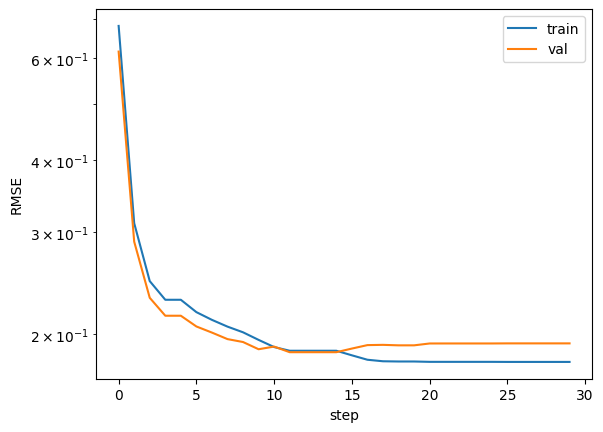

In [39]:
model5 = try_create_model2(Model5, attributes, imgs_shape)  # Attempt to create Model4
metrics5, best_model_state = fit_hybrid_dataloaders2(model5, dataset, opt="LBFGS", steps=30, lamb=.00000001)
model5.load_state_dict(best_model_state)
print(average_rmse(model5(dataset['test_img']), dataset['test_label']))
plt.plot(metrics5['train_loss'])
plt.plot(metrics5['eval_loss'])
plt.legend(['train', 'val'])
plt.ylabel('RMSE')
plt.xlabel('step')
plt.yscale('log')